In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import umap
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import time
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_sample_weight
try:
    from xgboost import XGBClassifier
    print("✅ XGBoost Imported")
except ImportError:
    print("⚠️ XGBoost not installed.")
        
try:
    from lightgbm import LGBMClassifier
    print("✅ LightGBM Imported")
except ImportError:
    print("⚠️ LightGBM not installed.")
        
     
        
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report, average_precision_score
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.metrics import recall_score, precision_score, accuracy_score
import shap
from sklearn.neighbors import BallTree
from sklearn.neighbors import KNeighborsClassifier


✅ XGBoost Imported
✅ LightGBM Imported


In [4]:
class DataExtraction:
    def __init__(self):
        pass

    def execute(self, state):
        print(f'--- Executing {self.__class__.__name__} ---')
        # Restore state variables to local scope
        globals().update(state)

 
        # The "Severity Legend" Colors
        
        severity_palette = ['#00BFFF', '#2ECC71', '#F39C12', '#E74C3C']
        orange_palette = ['#F39C12']
        
        red_palette = ['#E74C3C']
        
        green_palette = ['#2ECC71']
        
        blue_palette = ['#00BFFF']
        
        # Binary Palette (For your Machine Learning Model)
        # Mapping: Fatal (Class 0) -> Red, Minor (Class 1) -> Blue
        binary_palette = ['#00BFFF', '#E74C3C'] # [Red, Blue]

        df = pd.read_csv("US_Accidents_March23.csv")
        df.head()

        df.shape

        # --- STEP 2.0: FORENSIC DATA EXPLORATION ---
        
        # 1. LOAD DATA
        # We assume the file is named 'us_accidents_2023.csv' from the previous step
        df = pd.read_csv('us_accidents_2023.csv')
        
        print(f"--- DATASET AUDIT REPORT ---")
        print(f"Total Rows: {len(df):,}")
        print(f"Total Columns: {len(df.columns)}")
        
        # 2. THE TIME TRUTH (Verify the Date Range)
        # We must convert Start_Time to datetime to check the months
        df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
        df['Month'] = df['Start_Time'].dt.month_name()
        
        print("\n--- 1. TEMPORAL COVERAGE (The Seasonality Trap) ---")
        print(f"Earliest Date: {df['Start_Time'].min()}")
        print(f"Latest Date:   {df['Start_Time'].max()}")
        print("\nRecords by Month (Is it just Winter?):")
        print(df['Month'].value_counts())
        
        # 3. THE TARGET REALITY (Severity Imbalance)
        print("\n--- 2. TARGET VARIABLE (Severity) ---")
        severity_counts = df['Severity'].value_counts(normalize=True).sort_index()
        print(severity_counts)
        
        # Visualize Severity
        plt.figure(figsize=(8, 4))
        sns.countplot(x='Severity', data=df, palette= binary_palette)
        plt.title('The Class Imbalance Problem: Severity Distribution', fontweight='bold')
        plt.show()
        
        # 4. THE ROT (Missing Values Analysis)
        # We only care about columns with > 0% missing
        missing = df.isnull().mean() * 100
        missing = missing[missing > 0].sort_values(ascending=False)
        
        print("\n--- 3. MISSING VALUES (% of Data) ---")
        if len(missing) > 0:
            print(missing.head(15))
            
            # Visualizing the Gap
            plt.figure(figsize=(10, 6))
            missing.head(15).plot(kind='barh', color='#E74C3C')
            plt.title('Top 15 Columns with Missing Data (%)', fontweight='bold')
            plt.xlabel('Percentage Missing')
            plt.gca().invert_yaxis() # Highest missing at top
            plt.show()
        else:
            print("Incredible. No missing values found (Highly unlikely).")
        
        # 5. CARDINALITY CHECK (Categorical Complexity)
        # Which columns have too many unique values to encode?
        print("\n--- 4. CATEGORICAL COMPLEXITY (Top 10 High Cardinality) ---")
        cat_cols = df.select_dtypes(include=['object']).columns
        cardinality = df[cat_cols].nunique().sort_values(ascending=False)
        print(cardinality.head(10))
        
        # 6. NUMERICAL SUMMARY
        print("\n--- 5. NUMERICAL STATS (Outliers Check) ---")
        # Transpose for readability
        print(df.describe().T[['mean', 'min', '50%', 'max', 'std']])

        df.shape


        # Update state with current locals (naively saving everything)
        # Filtering to avoid saving self and state itself
        state.update({k: v for k, v in locals().items() if k not in ['self', 'state']})
        return state


In [5]:
class FinalDataExtraction:
    def __init__(self):
        pass

    def execute(self, state):
        print(f'--- Executing {self.__class__.__name__} ---')
        # Restore state variables to local scope
        globals().update(state)

        ### getting full year of data
        # --- STEP 1: EXTRACT ROLLING YEAR (March 2022 - March 2023) ---
        
        
        # CONFIG
        input_file = 'US_Accidents_March23.csv'
        output_file = 'us_accidents_rolling_year.csv'
        start_date = '2022-03-01'
        end_date = '2023-03-31'
        chunk_size = 500000
        
        print(f"--- STARTING EXTRACTION ({start_date} to {end_date}) ---")
        
        first_chunk = True
        total_rows_saved = 0
        
        # Iterate through chunks
        for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunk_size)):
            
            # 1. Fast Time Conversion (Coerce errors to NaT to avoid crashes)
            chunk['Start_Time'] = pd.to_datetime(chunk['Start_Time'], errors='coerce')
            
            # 2. Filter by Date Range
            mask = (chunk['Start_Time'] >= start_date) & (chunk['Start_Time'] <= end_date)
            filtered_chunk = chunk[mask]
            
            # 3. Save
            if len(filtered_chunk) > 0:
                mode = 'w' if first_chunk else 'a'
                header = first_chunk
                filtered_chunk.to_csv(output_file, mode=mode, index=False, header=header)
                
                first_chunk = False
                total_rows_saved += len(filtered_chunk)
                print(f"Chunk {i+1}: Saved {len(filtered_chunk):,} rows. Total: {total_rows_saved:,}")
            else:
                print(f"Chunk {i+1}: No data in target range.")
        
        print(f"\nDONE. Extracted {total_rows_saved:,} rows to '{output_file}'")

        # 1. LOAD DATA
        df = pd.read_csv('us_accidents_rolling_year.csv')
        df['Start_Time'] = pd.to_datetime(df['Start_Time'])

        # --- STEP 2.1: DURATION ANALYSIS (REFINED) ---
        
        
        
        # Ensure Duration is calculated
        if 'Duration_Minutes' not in df.columns:
            df['Start_Time'] = pd.to_datetime(df['Start_Time'])
            df['End_Time'] = pd.to_datetime(df['End_Time'])
            df['Duration_Minutes'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60
        
        print("--- DURATION DATA AUDIT ---")
        
        # 1. HARD NUMBERS (The "Rot" Count)
        neg_count = (df['Duration_Minutes'] < 0).sum()
        zero_count = (df['Duration_Minutes'] == 0).sum()
        long_count = (df['Duration_Minutes'] > 240).sum() # > 4 hours
        
        print(f"Total Rows: {len(df):,}")
        print("-" * 30)
        print(f"CRITICAL ERRORS (To Drop):")
        print(f" - Negative Time (Impossible): {neg_count:,} rows")
        print(f" - Zero Time (Glitch):         {zero_count:,} rows")
        print("-" * 30)
        print(f"OUTLIERS (To Assess):")
        print(f" - Extreme (> 4 Hours):        {long_count:,} rows")
        
        # 2. MISSING VALUES REPORT (Text Only)
        print("\n--- MISSING VALUES SUMMARY ---")
        missing_counts = df.isnull().sum()
        missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
        if not missing_counts.empty:
            print(missing_counts)
        else:
            print("No missing values found.")
        
        # 3. VISUALIZATION: The "Real World" Window (0 - 4 Hours)
        # We filter the plot data just for readability
        plot_data = df[(df['Duration_Minutes'] > 0) & (df['Duration_Minutes'] <= 240)]
        median_dur = plot_data['Duration_Minutes'].median()
        
        plt.figure(figsize=(12, 6))
        sns.histplot(plot_data['Duration_Minutes'], bins=60, kde=True, color='#2E86C1', edgecolor='white')
        plt.axvline(median_dur, color='red', linestyle='--', linewidth=2, label=f'Median Duration: {median_dur:.0f} min')
        
        plt.title('The "Typical" Accident Lifecycle (0-4 Hour Window)', fontsize=16, fontweight='bold')
        plt.xlabel('Duration (Minutes)', fontsize=12)
        plt.ylabel('Accident Count', fontsize=12)
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        plt.xlim(0, 240)
        
        # Annotation for context
        plt.annotate(f'Most accidents clear\nwithin 90 mins', 
                     xy=(90, 0), xytext=(100, plt.ylim()[1]*0.5),
                     arrowprops=dict(facecolor='black', shrink=0.05),
                     fontsize=11)
        
        plt.tight_layout()
        plt.show()


        # --- STEP 2.2: OUTLIER VETTING & DEEP EDA ---
        
        
        # Ensure duration is calculated
        if 'Duration_Minutes' not in df.columns:
            df['Start_Time'] = pd.to_datetime(df['Start_Time'])
            df['End_Time'] = pd.to_datetime(df['End_Time'])
            df['Duration_Minutes'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60
        
        print("--- 1. THE OUTLIER VERDICT (77k Rows > 4 Hours) ---")
        # Split data into "Normal" (< 4h) and "Extreme" (> 4h)
        normal_df = df[df['Duration_Minutes'] <= 240]
        extreme_df = df[df['Duration_Minutes'] > 240]
        
        # Calculate Severity Distribution for both
        norm_sev = normal_df['Severity'].value_counts(normalize=True).sort_index()
        ext_sev = extreme_df['Severity'].value_counts(normalize=True).sort_index()
        
        print("\nSeverity Distribution - NORMAL Duration (< 4 hrs):")
        print(norm_sev)
        print("\nSeverity Distribution - EXTREME Duration (> 4 hrs):")
        print(ext_sev)
        
        # If Extreme has higher % of Severity 4, we MUST keep them.
        ratio = ext_sev.get(4, 0) / norm_sev.get(4, 0)
        print(f"\nCRITICAL INSIGHT: Extreme duration accidents are {ratio:.1f}x more likely to be Fatal.")
        
        # --- 2. CATEGORICAL DEEP DIVE ---
        print("\n" + "="*40)
        print("--- 2. CATEGORICAL SUMMARY ---")
        print("="*40)
        
        # Select object columns
        cat_cols = df.select_dtypes(include=['object']).columns
        
        for col in cat_cols:
            unique_count = df[col].nunique()
            print(f"\nColumn: [{col}] - Unique Values: {unique_count}")
            
            # If manageable, show the top values
            if unique_count < 50:
                print(df[col].value_counts())
            else:
                print(f"Top 5 Values:\n{df[col].value_counts().head(5)}")
        
        # --- 3. NUMERICAL DEEP DIVE ---
        print("\n" + "="*40)
        print("--- 3. NUMERICAL SUMMARY (Describe) ---")
        print("="*40)
        # We transpose (.T) so it's readable
        print(df.describe().T)
        
        # --- 4. CORRELATION CHECK (Numerical) ---
        print("\n" + "="*40)
        print("--- 4. CORRELATION MATRIX (Top Correlations with Severity) ---")
        print("="*40)
        
        # Select numeric cols only
        numeric_df = df.select_dtypes(include=['number'])
        
        # Calculate correlation matrix
        corr_matrix = numeric_df.corr()
        
        # Check correlations with Severity
        if 'Severity' in corr_matrix.columns:
            sev_corr = corr_matrix['Severity'].sort_values(ascending=False)
            print(sev_corr)
        else:
            print("Severity column not found in numeric data.")
        
        # Heatmap (Only if < 20 columns to avoid clutter)
        if len(numeric_df.columns) < 20:
            plt.figure(figsize=(10, 8))
            sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
            plt.title('Correlation Heatmap', fontsize=14, fontweight='bold')
            plt.show()

        # --- STEP 2.3: THE OUTLIER KILL DECISION ---
        # We check the Severity breakdown of the 77k "Extreme" rows vs Normal rows
        
        # Define normal vs extreme
        normal_mask = (df['Duration_Minutes'] > 0) & (df['Duration_Minutes'] <= 240)
        extreme_mask = df['Duration_Minutes'] > 240
        
        # Calculate % of Fatalities (Severity 4) in both groups
        fatal_rate_normal = df.loc[normal_mask, 'Severity'].value_counts(normalize=True).get(4, 0)
        fatal_rate_extreme = df.loc[extreme_mask, 'Severity'].value_counts(normalize=True).get(4, 0)
        
        print(f"--- THE VERDICT ---")
        print(f"Fatal Rate (Normal Duration):  {fatal_rate_normal:.2%}")
        print(f"Fatal Rate (Extreme > 4 hrs):  {fatal_rate_extreme:.2%}")
        
        if fatal_rate_extreme > (fatal_rate_normal * 1.5):
            print("\nDECISION: KEEP THEM. (Long duration strongly signals Severity.)")
        else:
            print("\nDECISION: DROP THEM. (Long duration is just noise/construction.)")

        


        # Update state with current locals (naively saving everything)
        # Filtering to avoid saving self and state itself
        state.update({k: v for k, v in locals().items() if k not in ['self', 'state']})
        return state


In [ ]:
class DataCleaning:
    def __init__(self):
        pass

    def execute(self, state):
        print(f'--- Executing {self.__class__.__name__} ---')
        # Restore state variables to local scope
        globals().update(state)

        # --- FIX: Explicitly retrieve state variables to prevent UnboundLocalError ---
        if 'df' in state: df = state['df']
        # -----------------------------------------------------------------------------

        #visualizing the datas missingness
        
        
        print("--- GENERATING JUSTIFICATION REPORT VISUALS ---")
        
        # --- VISUAL 1: THE "GHOST DATA" (Missing Values) ---
        # Justification for: Dropping 'Number', 'End_Lat', 'End_Lng', 'Wind_Chill'
        plt.figure(figsize=(12, 5))
        missing = df.isnull().mean() * 100
        missing = missing[missing > 5].sort_values(ascending=False) # Only show cols with >5% missing
        
        sns.barplot(x=missing.values, y=missing.index, palette='Reds_r')
        plt.title('Exhibit A: The "Ghost" Columns (>5% Missing)', fontsize=14, fontweight='bold')
        plt.xlabel('Percentage of Data Missing (%)')
        plt.axvline(50, color='black', linestyle='--')
        plt.text(52, 0, 'Critical Data Loss (>50%)', va='center')
        plt.tight_layout()
        plt.show()
        
       
        
        # --- VISUAL 2: THE "REDUNDANCY" CHECK (Twilight) ---
        # Justification for: Dropping Civil/Nautical/Astronomical Twilight
        # We create a cross-tabulation to show they are identical
        redundancy = pd.crosstab(df['Sunrise_Sunset'], df['Civil_Twilight'])
        
        plt.figure(figsize=(6, 4))
        sns.heatmap(redundancy, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Exhibit B: The Redundancy Matrix\n(Sunrise_Sunset vs Civil_Twilight)', fontsize=12, fontweight='bold')
        plt.xlabel('Civil_Twilight')
        plt.ylabel('Sunrise_Sunset')
        plt.tight_layout()
        plt.show()
        
       
        
        # --- VISUAL 3: THE "SENSOR ROT" (Weather Gaps) ---
        # Justification for: Imputing by City+Time (Forward Fill) instead of Mean
        # Find a city with missing temperature to visualize the gap
        city_with_gaps = df[df['Temperature(F)'].isnull()]['City'].mode()[0]
        city_data = df[df['City'] == city_with_gaps].sort_values('Start_Time').iloc[:200] # Take first 200 records
        
        plt.figure(figsize=(12, 5))
        plt.plot(city_data['Start_Time'], city_data['Temperature(F)'], marker='o', linestyle='-', color='gray', alpha=0.5, label='Recorded Temp')
        # Highlight missing values
        missing_dates = city_data[city_data['Temperature(F)'].isnull()]['Start_Time']
        plt.vlines(missing_dates, ymin=city_data['Temperature(F)'].min(), ymax=city_data['Temperature(F)'].max(), 
                   colors='red', alpha=0.5, label='MISSING DATA (Sensor Failure)')
        
        plt.title(f'Sensor Failure Pattern ({city_with_gaps})', fontsize=14, fontweight='bold')
        plt.ylabel('Temperature (F)')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
      
        
        # --- VISUAL 4: THE "KILL ZONE" (Duration vs Severity) ---
        # Justification for: Keeping Extreme Duration Rows (>4 Hours)
        df['End_Time'] = pd.to_datetime(df['End_Time'])
        df['Duration_Minutes'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60
        df['Duration_Group'] = np.where(df['Duration_Minutes'] > 240, 'Extreme (>4h)', 'Normal (<4h)')
        
        # Calculate Fatality Rate
        fatality_rate = df.groupby('Duration_Group')['Severity'].apply(lambda x: (x==4).mean() * 100).reset_index()
        
        plt.figure(figsize=(8, 5))
        sns.barplot(x='Duration_Group', y='Severity', data=fatality_rate, palette=['#2ECC71', '#E74C3C'])
        plt.title('Exhibit D: The "Kill Zone"\n(% Fatalities by Duration)', fontsize=14, fontweight='bold')
        plt.ylabel('Percentage of Fatal Accidents (%)')
        plt.tight_layout()
        plt.show()
        
        

        
        print(f"--- DATASET AUDIT REPORT ---")
        print(f"Total Rows: {len(df):,}")
        print(f"Total Columns: {len(df.columns)}")
        
        # 2. THE TIME TRUTH (Verify the Date Range)
        # We must convert Start_Time to datetime to check the months
        df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
        df['Month'] = df['Start_Time'].dt.month_name()
        
        print("\n--- 1. TEMPORAL COVERAGE (The Seasonality Trap) ---")
        print(f"Earliest Date: {df['Start_Time'].min()}")
        print(f"Latest Date:   {df['Start_Time'].max()}")
        print("\nRecords by Month (Is it just Winter?):")
        print(df['Month'].value_counts())
        
        # 3. THE TARGET REALITY (Severity Imbalance)
        print("\n--- 2. TARGET VARIABLE (Severity) ---")
        severity_counts = df['Severity'].value_counts(normalize=True).sort_index()
        print(severity_counts)
        
        # Visualize Severity
        plt.figure(figsize=(8, 4))
        sns.countplot(x='Severity', data=df, palette= severity_palette)
        plt.title('The Class Imbalance Problem: Severity Distribution', fontweight='bold')
        plt.show()
        
        # 4. THE ROT (Missing Values Analysis)
        # We only care about columns with > 0% missing
        missing = df.isnull().mean() * 100
        missing = missing[missing > 0].sort_values(ascending=False)
        
        print("\n--- 3. MISSING VALUES (% of Data) ---")
        if len(missing) > 0:
            print(missing.head(15))
            
            # Visualizing the Gap
            plt.figure(figsize=(10, 6))
            missing.head(15).plot(kind='barh', color='#E74C3C')
            plt.title('Top 15 Columns with Missing Data (%)', fontweight='bold')
            plt.xlabel('Percentage Missing')
            plt.gca().invert_yaxis() # Highest missing at top
            plt.show()
        else:
            print("Incredible. No missing values found (Highly unlikely).")
        
        # 5. CARDINALITY CHECK (Categorical Complexity)
        # Which columns have too many unique values to encode?
        print("\n--- 4. CATEGORICAL COMPLEXITY (Top 10 High Cardinality) ---")
        cat_cols = df.select_dtypes(include=['object']).columns
        cardinality = df[cat_cols].nunique().sort_values(ascending=False)
        print(cardinality.head(10))
        
        # 6. NUMERICAL SUMMARY
        print("\n--- 5. NUMERICAL STATS (Outliers Check) ---")
        # Transpose for readability
        print(df.describe().T[['mean', 'min', '50%', 'max', 'std']])

        df.isnull().sum()

        
        #fix city missing values
        
        # 1. Split data into 'Known' and 'Unknown' Cities
        # We only use rows that have valid coordinates for training
        known_cities = df[df['City'].notna() & df['Start_Lat'].notna()].copy()
        unknown_cities = df[df['City'].isna() & df['Start_Lat'].notna()].copy()
        
        print(f"Fixing {len(unknown_cities)} rows with missing cities...")
        
        if not unknown_cities.empty:
            # 2. Prepare the Model
            # We use Latitude and Longitude to predict the City
            X_train = known_cities[['Start_Lat', 'Start_Lng']]
            y_train = known_cities['City']
        
            # 3. Train KNN Classifier
            # n_neighbors=1 means "Just take the name of the single closest accident"
            knn = KNeighborsClassifier(n_neighbors=1)
            knn.fit(X_train, y_train)
        
            # 4. Predict the missing cities
            X_missing = unknown_cities[['Start_Lat', 'Start_Lng']]
            predicted_cities = knn.predict(X_missing)
        
            # 5. Fill the gaps in the main dataframe
            # We iterate nicely to ensure indices match
            df.loc[unknown_cities.index, 'City'] = predicted_cities
        
            print(f"Success! {len(unknown_cities)} missing cities have been imputed based on location.")
            
            # Optional: Verify one or two
            print("Example fix:", df.loc[unknown_cities.index[0], ['Start_Lat', 'Start_Lng', 'City']])
        
        else:
            print("No missing cities found (or they lack coordinates).")

        df['City'].to_list()

        df.duplicated().sum()

        
        
        # 1. Filter for one city (Visualizing all cities at once is too messy)
        city_name = 'Pasadena'  # Change this to a city with missing data you want to inspect
        city_df = df[df['City'] == city_name].copy()
        
        # Ensure Start_Time is datetime
        city_df['Start_Time'] = pd.to_datetime(city_df['Start_Time'])
        city_df = city_df.sort_values('Start_Time')
        
        # Variables to visualize
        features = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Wind_Chill(F)']
        
        # 2. Setup the Plot (One subplot per feature)
        fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(15, 12), sharex=True)
        plt.subplots_adjust(hspace=0.3)
        fig.suptitle(f'Weather Sensor Failure Patterns: {city_name}', fontsize=16, weight='bold')
        
        for i, col in enumerate(features):
            ax = axes[i]
            
            # Plot valid data as grey dots
            valid_data = city_df.dropna(subset=[col])
            ax.scatter(valid_data['Start_Time'], valid_data[col], alpha=0.6, color='grey', s=10, label='Recorded')
            
            # Identify missing data rows
            missing_data = city_df[city_df[col].isna()]
            
            # Plot vertical red lines for missing data timestamps
            if not missing_data.empty:
                # We use vlines to create the "Barcode" effect seen in Exhibit C
                ax.vlines(x=missing_data['Start_Time'], 
                          ymin=city_df[col].min(), 
                          ymax=city_df[col].max(), 
                          colors='red', alpha=0.3, linewidth=1, label='MISSING')
        
            ax.set_ylabel(col, fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.5)
            
            # Only add legend to the first plot to avoid clutter
            if i == 0:
                ax.legend(loc='upper right')
        
        plt.xlabel('Date/Time', fontsize=12)
        plt.show()

        
        
        
        # ==========================================
        # PART 1: Automatically Create the Neighbor Map
        # ==========================================
        
        # 1. Get the "Centroid" (Average Lat/Lng) for each city
        # This gives us a single coordinate point representing each city
        city_coords = df.groupby('City')[['Start_Lat', 'Start_Lng']].mean().reset_index()
        
        # 2. Prepare data for the BallTree (Needs Radians for Haversine distance)
        # We convert Lat/Lng to radians
        coords_rad = np.deg2rad(city_coords[['Start_Lat', 'Start_Lng']].values)
        
        # 3. Build the Tree
        # metric='haversine' calculates distance on a sphere (Earth)
        tree = BallTree(coords_rad, metric='haversine')
        
        # 4. Query the Tree
        # k=2 because the closest neighbor to a city is ITSELF (distance 0). 
        # We want the 2nd closest.
        distances, indices = tree.query(coords_rad, k=2)
        
        # 5. Build the Dictionary
        # Earth Radius approx 3963 miles
        earth_radius_miles = 3963
        neighbor_map = {}
        
        for i, (dist_rad, idx) in enumerate(zip(distances, indices)):
            city_a = city_coords.iloc[i]['City']
            city_b_idx = idx[1] # The index of the neighbor
            city_b = city_coords.iloc[city_b_idx]['City']
            
            distance_miles = dist_rad[1] * earth_radius_miles
            
            # SAFETY CHECK: Only map if the neighbor is within 50 miles
            # You don't want to map New York to a city 500 miles away just because it's the "nearest"
            if distance_miles <= 50:
                neighbor_map[city_a] = city_b
        
        print(f"Automatically mapped {len(neighbor_map)} cities to their nearest neighbors.")
        print("Sample mappings:", dict(list(neighbor_map.items())[:5]))
        
        
        # ==========================================
        # PART 2: Apply the Map (Same Logic as Before)
        # ==========================================
        
        # Sort for merge_asof
        df = df.sort_values('Start_Time')
        valid_weather_data = df.dropna(subset=['Temperature(F)']).copy()
        
        # List of columns you want to fill
        weather_cols = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Wind_Chill(F)']
        
        # Counter for tracking progress
        total_filled = 0
        
        for target_city, source_city in neighbor_map.items():
            
            # Only proceed if target city actually has missing data
            target_mask = (df['City'] == target_city) & (df['Temperature(F)'].isna())
            
            # Skip if no missing data (optimization)
            if not target_mask.any():
                continue
                
            missing_rows = df[target_mask].copy()
            source_rows = valid_weather_data[valid_weather_data['City'] == source_city]
            
            if source_rows.empty:
                continue
        
            # Perform the time-based merge
            filled_rows = pd.merge_asof(
                missing_rows,
                source_rows[['Start_Time'] + weather_cols],
                on='Start_Time',
                direction='nearest',
                tolerance=pd.Timedelta('1 hour'), # Strict time limit
                suffixes=('', '_neighbor')
            )
            
            # Update the dataframe
            # We use the index to push values back
            for idx, row in filled_rows.iterrows():
                original_idx = missing_rows.iloc[idx].name
                
                # If we found a match (neighbor data isn't NaN)
                if pd.notna(row[f'Temperature(F)_neighbor']):
                    for col in weather_cols:
                        # Assign the neighbor's value to the original dataframe
                        df.at[original_idx, col] = row[f'{col}_neighbor']
                    total_filled += 1
        
        print(f"\nTotal rows filled using Spatial Imputation: {total_filled}")

        df[weather_cols].isnull().sum()

        #handle remaining missing weather numerical values using interpolation
        
        # 1. Prepare Data
        # Ensure we are sorted by City and Time, otherwise interpolation fails
        df = df.sort_values(by=['City', 'Start_Time'])
        
        # Columns to fix (excluding Wind_Chill for now)
        cols_to_fix = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']
        
        print(f"Missing before 1-Year Cascade:\n{df[cols_to_fix].isna().sum()}")
        
        # ==================================================
        # STEP 1: Time-Based Interpolation (The "Connect the Dots" Fill)
        # ==================================================
        # If the sensor works at 1pm (70F) and 3pm (72F), we assume 2pm was 71F.
        # limit_direction='both' fixes the start/end of the dataset too.
        # limit=3 ensures we don't draw lines across massive month-long gaps (which would be inaccurate).
        
        print("Step 1: Interpolating short gaps...")
        # We group by City to ensure we don't interpolate between two different cities
        df[cols_to_fix] = df.groupby('City')[cols_to_fix].transform(
            lambda group: group.interpolate(method='linear', limit=3, limit_direction='both')
        )
        
        # ==================================================
        # STEP 2: City-Specific Month-Hour Average
        # ==================================================
        # "What is the average 2pm temperature for this city in this month?"
        # (Uses the ~30 days of data available in your 1 year)
        
        df['Month'] = df['Start_Time'].dt.month
        df['Hour'] = df['Start_Time'].dt.hour
        
        print("Step 2: Filling with Month-Hour Average...")
        df[cols_to_fix] = df.groupby(['City', 'Month', 'Hour'])[cols_to_fix].transform(
            lambda x: x.fillna(x.mean())
        )
        
        # ==================================================
        # STEP 3: City-Specific Monthly Average (Backup)
        # ==================================================
        # If the sensor was dead at 2pm for the WHOLE month, Step 2 fails (mean is NaN).
        # We fallback to the average of the entire month (ignoring the hour).
        
        print("Step 3: Filling with Monthly Average...")
        df[cols_to_fix] = df.groupby(['City', 'Month'])[cols_to_fix].transform(
            lambda x: x.fillna(x.mean())
        )
        
        # ==================================================
        # STEP 4: Global Month-Hour Average (Last Resort)
        # ==================================================
        # If the city was dead for the WHOLE MONTH, we look at the global average
        # for that month/hour across all other cities.
        
        print("Step 4: Filling with Global Month-Hour Average...")
        for col in cols_to_fix:
            if df[col].isna().any():
                global_means = df.groupby(['Month', 'Hour'])[col].transform('mean')
                df[col] = df[col].fillna(global_means)
        
        # ==================================================
        # STEP 5: Wind Chill Logic
        # ==================================================
        # As discussed, Wind Chill is not a sensor. If it's missing, it implies
        # the weather wasn't cold/windy enough to trigger it. 
        # We default it to the Temperature.
        
        print("Step 5: Fixing Wind Chill...")
        df['Wind_Chill(F)'] = df['Wind_Chill(F)'].fillna(df['Temperature(F)'])
        
        # Final Check
        print(f"\nRemaining Missing Values:\n{df[cols_to_fix + ['Wind_Chill(F)']].isna().sum()}")

        df.isnull().sum()

        df['Precipitation(in)']

        df['Precipitation(in)'].isnull().sum()

        
        
        # ==========================================
        # PART 1: Spatial Fill (Catch the missing storms)
        # ==========================================
        # We re-use the neighbor_map logic, but ONLY for Precipitation this time.
        # If you already have the 'neighbor_map' from the previous step, this works automatically.
        
        # If you need to re-define the map manually for testing:
        # neighbor_map = {'Pasadena': 'Los Angeles', 'Burbank': 'Glendale', ...} 
        
        print("Step 1: Checking neighbors for missing storms...")
        
        # Sort for merge_asof
        df = df.sort_values('Start_Time')
        valid_rain_data = df.dropna(subset=['Precipitation(in)']).copy()
        
        # We only care about borrowing rain data if the neighbor actually reported rain (>0)
        # Borrowing "0" is redundant because we will fill with 0 anyway.
        rainy_neighbors = valid_rain_data[valid_rain_data['Precipitation(in)'] > 0]
        
        for target_city, source_city in neighbor_map.items():
            
            # Identify gaps in target city
            target_mask = (df['City'] == target_city) & (df['Precipitation(in)'].isna())
            missing_rows = df[target_mask]
            
            if missing_rows.empty:
                continue
        
            # Get data from the specific source city (only if it was raining there)
            source_rows = rainy_neighbors[rainy_neighbors['City'] == source_city]
            
            if source_rows.empty:
                continue
        
            # Map the rain
            filled_rows = pd.merge_asof(
                missing_rows,
                source_rows[['Start_Time', 'Precipitation(in)']],
                on='Start_Time',
                direction='nearest',
                tolerance=pd.Timedelta('30 minutes'), # Rain is local; keep tolerance tight
                suffixes=('', '_neighbor')
            )
        
            # Update the main dataframe
            for idx, row in filled_rows.iterrows():
                original_idx = missing_rows.iloc[idx].name
                if pd.notna(row['Precipitation(in)_neighbor']):
                    df.at[original_idx, 'Precipitation(in)'] = row['Precipitation(in)_neighbor']
        
        print("   - Spatial rain imputation complete.")
        
        # ==========================================
        # PART 2: The "Silent Zero" Fill
        # ==========================================
        # Any remaining NaNs imply no rain was recorded or no nearby storm was found.
        # Safest assumption is 0.00.
        
        missing_count = df['Precipitation(in)'].isna().sum()
        print(f"Step 2: Filling {missing_count} remaining gaps with 0.00 (No Rain)...")
        
        df['Precipitation(in)'] = df['Precipitation(in)'].fillna(0.0)
        
        print(f"Final check: Missing Precipitation = {df['Precipitation(in)'].isna().sum()}")

        print(df.columns.to_list())

        # --- STEP 3.0: DOMAIN-BACKED CLEANING (FINAL EXECUTION) ---
        
        
        df2 = df.copy()
        print(f"Original Count: {len(df):,}")
        
        
        
        # 3. COLUMN PURGE
        # Drop 'Ghost' lat/lng and redundant Twilights, and other columns that cause leakage
        cols_to_drop = ['Number', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 
                        'End_Lat', 'End_Lng', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
                        'Duration', 'Distance(mi)']
        df = df.drop(columns=cols_to_drop, errors='ignore')
        
        
        # 5. BINARY MAPPING and Sunrise_Sunset Missing values handling
        # 1. Check how many we are fixing
        missing_mask = df2['Sunrise_Sunset'].isna()
        print(f"Fixing {missing_mask.sum()} missing Sunrise_Sunset values using 'Hour'...")
        
        
        accident_hour = df2['Hour']
        
        # 3. The Logic: Standard definitions
        # Day = 6 AM to 6 PM (Hours 6-17)
        # Night = 6 PM to 6 AM (Hours 18-23, 0-5)
        
        # Create a filler series based on hour
        # Returns 'Night' if hour >= 18 OR hour < 6, else 'Day'
        imputed_values = accident_hour.apply(lambda h: 'Night' if (h >= 18 or h < 6) else 'Day')
        
        # 4. Fill ONLY the missing values
        df2['Sunrise_Sunset'] = df2['Sunrise_Sunset'].fillna(imputed_values)
        
        # 5. Now safely map to Binary
        df2['Is_Night'] = df2['Sunrise_Sunset'].map({'Night': 1, 'Day': 0})
        # Map ensures any remaining weird text becomes NaN (safeguard), but fillna fixed it.
        
        # Drop original column
        df2_cleaned = df2.drop(columns=['Sunrise_Sunset'])
        
        print(f"Is_Night Distribution:\n{df2['Is_Night'].value_counts(normalize=True)}")
        
        
        # 6. SAVE
        df2_cleaned.to_csv('us_accidents_2023_cleaned.csv', index=False)
        print("--- CLEANING COMPLETE: Saved to 'us_accidents_2023_cleaned.csv' ---")

        cols_to_drop2 = ['ID', 'Zipcode']
        df2_cleaned = df2_cleaned.drop(columns=cols_to_drop, errors='ignore')

        df2_cleaned.isnull().sum()


        cols = ['Wind_Direction', 'Weather_Condition', 'Source']
        df2_cleaned[cols].nunique()

        df2_cleaned['Source'].unique()

        df2_cleaned['Wind_Direction'].unique()

        df2_cleaned['Weather_Condition'].unique()

        #handling weather)condition 26984 missing values
        # 1. Identify the missing rows
        missing_mask = df2_cleaned['Weather_Condition'].isna()
        print(f"Handling {missing_mask.sum()} missing weather descriptions using sensor data...")
        
        # 2. PROXY 1: If it's freezing and precipitating, it's SNOW
        # (We assume < 32F is freezing)
        snow_mask = missing_mask & (df2_cleaned['Precipitation(in)'] > 0) & (df2_cleaned['Temperature(F)'] <= 32)
        df2_cleaned.loc[snow_mask, 'Weather_Condition'] = 'Light Snow' # Specific text for the simplifier to catch
        
        # 3. PROXY 2: If it's warm and precipitating, it's RAIN
        rain_mask = missing_mask & (df2_cleaned['Precipitation(in)'] > 0) & (df2_cleaned['Temperature(F)'] > 32)
        df2_cleaned.loc[rain_mask, 'Weather_Condition'] = 'Light Rain'
        
        # 4. PROXY 3: If no precipitation, assume CLEAR
        # This catches the remaining NaNs
        df2_cleaned['Weather_Condition'] = df2_cleaned['Weather_Condition'].fillna('Clear')
        
        print("   -> Imputation Complete.")
        print(f"   -> Reclaimed {snow_mask.sum()} hidden Snow events.")
        print(f"   -> Reclaimed {rain_mask.sum()} hidden Rain events.")
        
        # --- NOW RUN YOUR SIMPLIFICATION FUNCTION ---
        # (Paste your simplify_weather function and apply code here)
        # ...

        '''
        New Category,   Underlying Physics,   Original Terms (Examples)
        Snow/Ice,Low      Friction (Deadly),  "Snow, Sleet, Ice, Freezing Rain, Wintry Mix, Hail"
        Storm,          Chaos (Wind + Wet),    "Thunder, T-Storm, Tornado, Squalls"
        Rain,          Medium Friction (Wet),   "Rain, Drizzle, Showers"
        Fog/Obscured,     Low Visibility,       "Fog, Mist, Haze, Smoke, Dust"
        Cloudy,             Benign,             "Cloudy, Overcast"
        Clear,             Baseline,              "Fair, Clear, Partly Cloudy, N/A"
        '''


        # Create a copy to ensure we don't mess up the original pointer
        df_cleaned2 = df2_cleaned.copy()
        
        # --- 1. WIND DIRECTION FIX ---
        # Domain Logic: If wind data is missing, it is standard to assume "CALM" (0 speed).
        # We keep the 16 compass points (N, NE, SW...) as they interact with road geometry.
        df_cleaned2['Wind_Direction'] = df_cleaned2['Wind_Direction'].fillna('CALM')
        
        # --- 2. WEATHER CONDITION SIMPLIFICATION ---
        # Domain Logic: Reduce 91+ text descriptions to 6 categories based on "Road Friction" and "Visibility".
        
        def simplify_weather(w):
            # Handle NaN: Default to 'Clear' (Baseline condition)
            if pd.isna(w):
                return 'Clear'
            
            w = str(w).lower()
            
            # PRIORITY 1: FROZEN PRECIPITATION (Highest Danger / Lowest Friction)
            # Includes: Light Snow, Heavy Ice Pellets, Wintry Mix, Freezing Rain
            if any(x in w for x in ['snow', 'sleet', 'ice', 'freezing', 'wintry', 'hail']):
                return 'Snow/Ice'
            
            # PRIORITY 2: SEVERE STORM (High Wind + Rain + Unpredictability)
            # Includes: T-Storm, Thunder, Tornado, Funnel Cloud, Squalls
            if any(x in w for x in ['thunder', 't-storm', 'tornado', 'squall']):
                return 'Storm'
            
            # PRIORITY 3: RAIN (Wet Roads / Medium Friction)
            # Includes: Light Rain, Drizzle, Showers, Heavy Rain
            if any(x in w for x in ['rain', 'drizzle', 'shower']):
                return 'Rain'
            
            # PRIORITY 4: OBSCURITY (Visual Hazard / Dry or Damp Surface)
            # Includes: Fog, Mist, Haze, Smoke, Dust, Sand
            if any(x in w for x in ['fog', 'mist', 'haze', 'smoke', 'dust', 'sand']):
                return 'Fog/Obscured'
            
            # PRIORITY 5: CLOUDY (Benign, No Precipitation)
            # Includes: Overcast, Mostly Cloudy, Scattered Clouds
            if any(x in w for x in ['cloudy', 'overcast']):
                return 'Cloudy'
            
            # PRIORITY 6: CLEAR (Default / Safe)
            # Includes: Fair, Clear, N/A Precipitation
            return 'Clear'
        
        # Apply the logic
        df_cleaned2['Weather_Simplified'] = df_cleaned2['Weather_Condition'].apply(simplify_weather)
        
        # Drop the old 91-value column to save memory
        df_cleaned2 = df_cleaned2.drop(columns=['Weather_Condition'])
        
        # --- 3. VERIFICATION ---
        print("--- CLEANING COMPLETE ---")
        print(f"New Weather Categories:\n{df_cleaned2['Weather_Simplified'].value_counts()}")
        print(f"\nRemaining Missing Wind Values: {df_cleaned2['Wind_Direction'].isnull().sum()}")

        df_cleaned2.isnull().any(axis=1).sum()

        df_cleaned2.isnull().sum()

        # Create a new version for this step
        df_cleaned3 = df_cleaned2.copy()
        
        print("--- HANDLING SPATIAL TEXT FEATURES ---")
        
        
        print(f"Missing 'Street' before repair: {df_cleaned3['Street'].isna().sum()}")
        
        # ==========================================
        # PHASE 1: SPATIAL REPAIR (Impute Missing Streets)
        # ==========================================
        # Logic: If accident A is at (Lat, Lng) and missing 'Street', 
        # but accident B is at the same (Lat, Lng) and has 'Street', copy it.
        
        # 1. Identify rows with known vs. unknown streets
        known_streets = df_cleaned3[df_cleaned3['Street'].notna() & df_cleaned3['Start_Lat'].notna()].copy()
        unknown_streets = df_cleaned3[df_cleaned3['Street'].isna() & df_cleaned3['Start_Lat'].notna()].copy()
        
        if not unknown_streets.empty and not known_streets.empty:
            print("Attempting to impute missing street names using coordinates...")
            
            # 2. Train a simple Nearest Neighbor model
            # We use k=1 to find the single closest accident
            X_train = known_streets[['Start_Lat', 'Start_Lng']]
            y_train = known_streets['Street']
            
            knn = KNeighborsClassifier(n_neighbors=1, weights='distance')
            knn.fit(X_train, y_train)
            
            # 3. Predict the missing streets
            predicted_streets = knn.predict(unknown_streets[['Start_Lat', 'Start_Lng']])
            
            # 4. Fill the gaps
            df_cleaned3.loc[unknown_streets.index, 'Street'] = predicted_streets
            print(f"Repaired {len(unknown_streets)} missing Street values.")
        
        # ==========================================
        # PHASE 2: HIGHWAY DETECTION (Feature Extraction)
        # ==========================================
        # Standard list of US Highway indicators
        highway_keywords = [
            'I-', 'Interstate', 'Hwy', 'Highway', 'Route', 'St', 'State', 
            'Turnpike', 'Fwy', 'Freeway', 'Expy', 'Expressway', 'Pkwy', 'Parkway',
            'US-', 'U.S.', 'Loop', 'Bypass'
        ]
        
        def detect_highway(street_name):
            # Handle stubborn NaNs (if repair failed)
            if pd.isna(street_name):
                return 0 # Safe assumption: Missing usually implies smaller/local roads
            
            street_name = str(street_name).lower()
            
            # Check for keywords
            if any(keyword.lower() in street_name for keyword in highway_keywords):
                return 1
            return 0
        
        # Apply the detector to the now-repaired column
        df_cleaned3['Is_Highway'] = df_cleaned3['Street'].apply(detect_highway)
        
        # Drop the high-cardinality text column
        if 'Street' in df_cleaned3.columns:
            df_cleaned3 = df_cleaned3.drop(columns=['Street'])
        
        # --- FINAL AUDIT ---
        print("\n--- STREET TRANSFORMATION COMPLETE ---")
        print(f"Is_Highway Dist:\n{df_cleaned3['Is_Highway'].value_counts(normalize=True)}")

        df_cleaned3

        
        df_cleaned3 = df_cleaned3.drop(columns=['Source'], errors='ignore')
        df_cleaned3

        df_cleaned3.isnull().any(axis=1).sum()

        df_cleaned3 = df_cleaned3.drop(columns=['ID'], errors='ignore')
        df_cleaned3 = df_cleaned3.drop(columns=['Zipcode'], errors='ignore')
        df_cleaned3.head()

        print(df_cleaned3.columns.to_list())

        df_cleaned3['Description'].sample(20)

        
        # Use the dataframe from the current step
        df_viz = df_cleaned3.copy()
        
        poi_cols = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 
                    'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
                    'Traffic_Signal', 'Turning_Loop']
        
        print("--- GENERATING POI VARIANCE VISUALIZATION ---")
        
        # 1. Calculate True Ratios
        data = []
        for col in poi_cols:
            if col in df_viz.columns:
                true_count = df_viz[col].sum()
                ratio = (true_count / len(df_viz)) * 100
                
                # Assign Color Category based on Academic Thresholds
                if ratio < 0.001:
                    category = 'Dead (<0.001%)'
                    color = '#E74C3C' # Red
                elif ratio < 1.0:
                    category = 'Rare (0.001% - 1%)'
                    color = '#F1C40F' # Yellow
                else:
                    category = 'Robust (>1%)'
                    color = '#2ECC71' # Green
                    
                data.append({'Feature': col, 'True_Ratio': ratio, 'Color': color, 'Category': category})
        
        df_plot = pd.DataFrame(data).sort_values('True_Ratio', ascending=True)
        
        # 2. Plot
        plt.figure(figsize=(12, 8))
        bars = plt.barh(df_plot['Feature'], df_plot['True_Ratio'], color=df_plot['Color'])
        
        # 3. Aesthetics
        plt.xscale('log') # CRITICAL: Use Log Scale to see the tiny values
        plt.xlabel('Percentage of "True" Cases (Log Scale)', fontsize=12, fontweight='bold')
        plt.title('The "Variance Spectrum": Identifying Dead vs. Robust Features', fontsize=16, fontweight='bold')
        
        # Add Threshold Lines
        plt.axvline(x=0.001, color='red', linestyle='--', linewidth=1, alpha=0.7)
        plt.text(0.0012, 0, 'Dead Zone (0.001%)', color='red', rotation=90, va='bottom')
        
        plt.axvline(x=1.0, color='green', linestyle='--', linewidth=1, alpha=0.7)
        plt.text(1.2, 0, 'Robust Zone (1%)', color='green', rotation=90, va='bottom')
        
        # Legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='#E74C3C', label='Dead / Noise (<0.001%)'),
                           Patch(facecolor='#F1C40F', label='Rare Signal (0.001% - 1%)'),
                           Patch(facecolor='#2ECC71', label='Robust Feature (>1%)')]
        plt.legend(handles=legend_elements, loc='lower right')
        
        plt.grid(axis='x', which='both', linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()

        
        
        # 1. Select the features to check
        # We include Boolean POIs, Weather, and new features like Is_Highway
        # (Ensure categorical text columns like 'Weather_Simplified' are One-Hot Encoded 
        # or excluded for this specific numeric check. Here we focus on Boolean/Numeric)
        
        features_to_check = [
            'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 
            'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
            'Traffic_Signal', 'Is_Highway'
        ]
        
        # Filter df for these columns
        # (Assuming df_cleaned3 is your current dataframe)
        corr_df = df_cleaned3[features_to_check]
        
        # 2. Calculate Correlation Matrix
        # method='spearman' is often better for boolean/skewed data than 'pearson', 
        # but 'pearson' is standard. Let's use Pearson for simplicity.
        corr_matrix = corr_df.corr()
        
        # 3. Plot the Heatmap
        plt.figure(figsize=(16, 12))
        sns.heatmap(corr_matrix, 
                    annot=True,       # Show numbers
                    fmt=".2f",        # 2 decimal places
                    cmap='coolwarm',  # Red = High Positive, Blue = High Negative
                    vmin=-1, vmax=1,  # Set scale
                    linewidths=0.5)
        
        plt.title('Feature Correlation Matrix: Detecting Redundancy', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # 4. Automatic "Red Flag" Detector
        # Print pairs with correlation > 0.7 (Standard threshold for "Too Similar")
        print("--- HIGH CORRELATION PAIRS (>0.7) ---")
        threshold = 0.7
        
        # Iterate through the matrix to find high correlations (excluding self-correlation)
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > threshold:
                    colname_i = corr_matrix.columns[i]
                    colname_j = corr_matrix.columns[j]
                    score = corr_matrix.iloc[i, j]
                    high_corr_pairs.append((colname_i, colname_j, score))
        
        if not high_corr_pairs:
            print("No highly correlated pairs found. All features are sufficiently distinct.")
        else:
            for pair in high_corr_pairs:
                print(f"RED FLAG: {pair[0]} vs {pair[1]} | Score: {pair[2]:.2f}")

        # Create df_poi_audit for this specific task
        df_poi_audit = df_cleaned3.copy()
        
        poi_cols = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 
                    'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
                    'Traffic_Signal', 'Turning_Loop']
        
        print("--- ACADEMIC POI VARIANCE AUDIT ---")
        print(f"Total Rows: {len(df_poi_audit):,}")
        print("-" * 60)
        print(f"{'COLUMN':<20} | {'TRUE COUNT':<10} | {'RATIO (%)':<10} | {'VERDICT'}")
        print("-" * 60)
        
        cols_to_drop_final = []
        
        for col in poi_cols:
            if col in df_poi_audit.columns:
                true_count = df_poi_audit[col].sum()
                ratio = (true_count / len(df_poi_audit)) * 100
                
                # LOGIC TIER 1: DEAD (Near-Zero Variance)
                # Threshold: Less than 0.001% (approx 10-15 rows in 1.2M)
                if ratio < 0.001: 
                    verdict = "DROP (Dead/Noise)"
                    cols_to_drop_final.append(col)
                    
                # LOGIC TIER 2: RARE (Between 0.001% and 1%)
                # Threshold: We flag it, but usually KEEP because XGBoost can handle sparsity
                elif ratio < 1.0:
                    verdict = "KEEP (Rare Signal)"
                    
                # LOGIC TIER 3: ROBUST (> 1%)
                else:
                    verdict = "KEEP (Robust)"
                    
                print(f"{col:<20} | {true_count:<10,} | {ratio:<10.5f} | {verdict}")
            
        
        print("-" * 60)
        
        # Execute the Drops
        if cols_to_drop_final:
            print(f"\nDropping {len(cols_to_drop_final)} columns based on Near-Zero Variance...")
            df_poi_audit = df_poi_audit.drop(columns=cols_to_drop_final)
            print(f"\nDropping Bump due to multicollinearity")
            df_poi_audit = df_poi_audit.drop(columns=['Bump'])
            print(f"Dropped: {cols_to_drop_final}")
        else:
            print("\nNo columns met the 'Dead' criteria.")
            
        # Final Check
        print(f"\nRemaining Columns: {len(df_poi_audit.columns)}")

        print(df_poi_audit.columns.to_list())

        df_final = df_poi_audit.copy()
        df_final.head()


        # Update state with current locals (naively saving everything)
        # Filtering to avoid saving self and state itself
        state.update({k: v for k, v in locals().items() if k not in ['self', 'state']})
        return state


In [ ]:
class UnivariateAnalysis:
    def __init__(self):
        pass

    def execute(self, state):
        print(f'--- Executing {self.__class__.__name__} ---')
        # Restore state variables to local scope
        globals().update(state)

        # --- FIX: Explicitly retrieve state variables to prevent UnboundLocalError ---
        if 'df_final' in state: df_final = state['df_final']
        # -----------------------------------------------------------------------------

        
        
        # Setup
        sns.set_style("whitegrid")
        
        # Ensure Time is Datetime and Extract Features
        if df_final['Start_Time'].dtype == 'O':
            df_final['Start_Time'] = pd.to_datetime(df_final['Start_Time'])
        df_final['Hour'] = df_final['Start_Time'].dt.hour
        df_final['Month'] = df_final['Start_Time'].dt.month # Create Month Column
        
        print("--- GENERATING DISTRIBUTION VISUALS ---\n")
        
        # --- VISUAL 1: TARGET IMBALANCE (Severity) ---
        plt.figure(figsize=(10, 6))
        ax = sns.countplot(x='Severity', data=df_final, palette=severity_palette)
        plt.title('DISTRIBUTION 1: The Target Imbalance (Severity)', fontsize=16, fontweight='bold')
        plt.xlabel('Severity Level (1=Minor, 4=Fatal)', fontsize=12)
        plt.ylabel('Accident Count', fontsize=12)
        ax.bar_label(ax.containers[0], fontsize=11)
        plt.show()
        
      
        
        # --- VISUAL 2: ENVIRONMENTAL CONTEXT (Weather) ---
        plt.figure(figsize=(10, 6))
        # Calculate order for cleanliness
        order_weather = df_final['Weather_Simplified'].value_counts().index
        ax = sns.countplot(y='Weather_Simplified', data=df_final, order=order_weather, palette='coolwarm')
        plt.title('DISTRIBUTION 2: Environmental Context (Weather)', fontsize=16, fontweight='bold')
        plt.xlabel('Accident Count', fontsize=12)
        plt.ylabel('Weather Condition', fontsize=12)
        plt.show()
        
      
        
        # --- VISUAL 3: TEMPORAL RHYTHM (Hour) ---
        plt.figure(figsize=(12, 6))
        sns.histplot(df_final['Hour'], bins=24, kde=True, color='lightblue', edgecolor='black')
        plt.title('DISTRIBUTION 3: The Pulse of Traffic (Hour of Day)', fontsize=16, fontweight='bold')
        plt.xlabel('Hour of Day (0-23)', fontsize=12)
        plt.ylabel('Accident Count', fontsize=12)
        plt.xticks(range(0, 25, 1))
        plt.show()
        
      
        
        # --- VISUAL 4: INFRASTRUCTURE (Highway vs Local) ---
        plt.figure(figsize=(10, 6))
        # Create temporary label column for plotting
        df_plot = df_final.copy()
        df_plot['Road_Type'] = df_plot['Is_Highway'].map({1: 'Highway', 0: 'Local Road'})
        ax = sns.countplot(x='Road_Type', data=df_plot, palette=binary_palette)
        plt.title('DISTRIBUTION 4: Infrastructure (Highway vs. Local)', fontsize=16, fontweight='bold')
        plt.xlabel('Road Classification', fontsize=12)
        plt.ylabel('Accident Count', fontsize=12)
        ax.bar_label(ax.containers[0], fontsize=11)
        plt.show()
        
       
        
        
        # --- VISUAL 5: SEASONAL RHYTHM (Rolling Year: Mar '22 - Mar '23) ---
        plt.figure(figsize=(12, 6))
        
        # 1. Ensure 'Month' is ready
        if 'Month' not in df_final.columns:
            df_final['Month'] = df_final['Start_Time'].dt.month
        
        # 2. Define the Rolling Order (March -> December -> January -> February)
        rolling_order = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2]
        month_labels = {
            1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
            7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
        }
        
        # 3. Create a custom color map for this rolling order (Spectral)
        # We want to maintain the "Seasonality" colors even if the order changes.
        # March(3)=Green/Spring, July(7)=Red/Summer, Dec(12)=Blue/Winter
        # 'Spectral' does this naturally if mapped to values 1-12, but since we reorder,
        # we let seaborn map colors based on the data values, or we can use a cyclic map like 'twilight' or 'hsv'.
        # For clarity, 'Spectral' is still best, but we'll apply it to the sorted months.
        
        ax = sns.countplot(
            x='Month', 
            data=df_final, 
            order=rolling_order,  # <--- THIS FORCES THE ROLLING YEAR ORDER
            palette='Spectral'    # Maps colors to the specific month index
        )
        
        # 4. Format the X-Axis Labels to be Readable Names
        ax.set_xticklabels([month_labels[m] for m in rolling_order])
        
        plt.title('DISTRIBUTION 5: Seasonal Rhythm (Rolling Year: Mar 2022 - Mar 2023)', fontsize=16, fontweight='bold')
        plt.xlabel('Month (Fiscal Flow)', fontsize=12)
        plt.ylabel('Accident Count', fontsize=12)
        ax.bar_label(ax.containers[0], fontsize=10)
        
        plt.show()
        
        
        
       

        
        
        # Setup aesthetics
        plt.style.use('seaborn-v0_8-whitegrid')
        # Define colors (matching your previous palettes)
        severity_colors = ['#4FC1E9', '#2ECC71', '#F39C12', '#E74C3C'] # Blue, Green, Yellow, Red
        infra_colors = ['#E74C3C', '#3498DB'] # Red (Local), Blue (Highway)
        
        print("--- GENERATING UNIVARIATE DONUT CHARTS ---\n")
        
        # --- VISUAL 1: TARGET IMBALANCE (Severity Donut) ---
        plt.figure(figsize=(8, 8))
        
        # 1. Prepare Data
        severity_counts = df_final['Severity'].value_counts().sort_index()
        labels = [f'Sev {i}' for i in severity_counts.index]
        
        # 2. Plot Donut
        # autopct='%1.1f%%' adds the percentage
        # pctdistance=0.85 moves the % towards the outer edge for readability
        # wedgeprops adds the white separator lines
        wedges, texts, autotexts = plt.pie(
            severity_counts, 
            labels=labels, 
            colors=severity_colors, 
            autopct='%1.1f%%', 
            pctdistance=0.75, 
            startangle=90, 
            wedgeprops=dict(width=0.4, edgecolor='w') # width=0.4 makes it a donut
        )
        
        # 3. Aesthetics
        plt.setp(autotexts, size=10, weight="bold", color="white")
        plt.setp(texts, size=12, weight="bold")
        plt.title('DISTRIBUTION 1: The Target Imbalance (Severity)', fontsize=16, fontweight='bold')
        
        # Add a circle at the center to ensure it looks like a donut (optional, handled by wedge width)
        # But adding a central text label is a nice touch
        plt.text(0, 0, f"Total\n{len(df_final):,}", ha='center', va='center', fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("-" * 60)
        
        # --- VISUAL 4: INFRASTRUCTURE (Highway vs Local Donut) ---
        plt.figure(figsize=(8, 8))
        
        # 1. Prepare Data
        # Map 0/1 to labels first
        road_counts = df_final['Is_Highway'].value_counts().rename({0: 'Local Road', 1: 'Highway'})
        road_labels = road_counts.index
        
        # 2. Plot Donut
        wedges, texts, autotexts = plt.pie(
            road_counts, 
            labels=road_labels, 
            colors=infra_colors, 
            autopct='%1.1f%%', 
            pctdistance=0.75, 
            startangle=140, 
            wedgeprops=dict(width=0.4, edgecolor='w')
        )
        
        # 3. Aesthetics
        plt.setp(autotexts, size=12, weight="bold", color="white")
        plt.setp(texts, size=12, weight="bold")
        plt.title('DISTRIBUTION 4: Infrastructure Split', fontsize=16, fontweight='bold')
        
        # Center text
        plt.text(0, 0, "Road\nType", ha='center', va='center', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()


        # Update state with current locals (naively saving everything)
        # Filtering to avoid saving self and state itself
        state.update({k: v for k, v in locals().items() if k not in ['self', 'state']})
        return state


In [ ]:
class BivariateAnalysis:
    def __init__(self):
        pass

    def execute(self, state):
        print(f'--- Executing {self.__class__.__name__} ---')
        # Restore state variables to local scope
        globals().update(state)

        # --- FIX: Explicitly retrieve state variables to prevent UnboundLocalError ---
        if 'df_final' in state: df_final = state['df_final']
        # -----------------------------------------------------------------------------

        #bivariate analysis
        
        # Setup
        sns.set_style("whitegrid")
        
        print("--- GENERATING RISK ANALYSIS VISUALS (ROLLING YEAR EDITION) ---\n")
        
        # Helper function to calculate Fatality Rate
        def get_fatality_rate(df, group_col):
            # Calculate % of Severity=4 (Fatal) cases in each group
            return df.groupby(group_col)['Severity'].apply(lambda x: (x==4).mean() * 100).reset_index()
        
        # Calculate global average for reference lines
        avg_fatality = (df_final['Severity'] == 4).mean() * 100
        
        # --- VISUAL 1: WEATHER RISK ---
        plt.figure(figsize=(10, 6))
        risk_weather = get_fatality_rate(df_final, 'Weather_Simplified')
        risk_weather = risk_weather.sort_values('Severity', ascending=False)
        
        sns.barplot(x='Weather_Simplified', y='Severity', data=risk_weather, palette='Blues_d')
        plt.title('RISK FACTOR 1: Weather Lethality', fontsize=16, fontweight='bold')
        plt.ylabel('Fatality Rate (%)', fontsize=12)
        plt.axhline(avg_fatality, color='red', linestyle='--', label=f'Average Risk ({avg_fatality:.2f}%)')
        plt.legend()
        plt.show()
        
        print("-" * 60)
        
        # --- VISUAL 2: INFRASTRUCTURE RISK (Highway vs Local) ---
        plt.figure(figsize=(8, 6))
        df_final['Road_Label'] = df_final['Is_Highway'].map({1: 'Highway', 0: 'Local Road'})
        risk_road = get_fatality_rate(df_final, 'Road_Label')
        
        sns.barplot(x='Road_Label', y='Severity', data=risk_road, palette='Reds_d')
        plt.title('RISK FACTOR 2: Infrastructure Speed', fontsize=16, fontweight='bold')
        plt.ylabel('Fatality Rate (%)', fontsize=12)
        plt.axhline(avg_fatality, color='black', linestyle='--', label='Average Risk')
        plt.legend()
        plt.show()
        
        print("-" * 60)
        
        # --- VISUAL 3: TEMPORAL RISK (The Witching Hour) ---
        plt.figure(figsize=(12, 6))
        risk_hour = get_fatality_rate(df_final, 'Hour')
        
        sns.lineplot(x='Hour', y='Severity', data=risk_hour, marker='o', color='purple', linewidth=3)
        plt.title('RISK FACTOR 3: The Hourly Risk Profile', fontsize=16, fontweight='bold')
        plt.ylabel('Fatality Rate (%)', fontsize=12)
        plt.xlabel('Hour of Day (0-23)', fontsize=12)
        plt.xticks(range(0, 25, 1))
        plt.grid(True, alpha=0.3)
        
        # Highlight Peak
        peak_hour = risk_hour.loc[risk_hour['Severity'].idxmax(), 'Hour']
        plt.axvline(peak_hour, color='red', linestyle=':', alpha=0.5)
        plt.text(peak_hour + 0.5, risk_hour['Severity'].max(), f'Peak Danger: {peak_hour}:00', color='red')
        plt.show()
        
        print("-" * 60)
        
        # --- VISUAL 4: SEASONAL RISK (Rolling Year: Mar '22 - Mar '23) ---
        plt.figure(figsize=(12, 6))
        
        # 1. Ensure Month exists
        if 'Month' not in df_final.columns:
            df_final['Month'] = df_final['Start_Time'].dt.month
        
        # 2. Calculate Risk Per Month
        risk_month = get_fatality_rate(df_final, 'Month')
        
        # 3. Define Rolling Order & Labels
        rolling_order = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2]
        month_labels = {
            1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
            7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
        }
        
        # 4. Plot with Explicit Order
        # We use 'Spectral' to match the season colors (Cold=Blue/Purple, Warm=Red/Orange)
        ax = sns.barplot(
            x='Month', 
            y='Severity', 
            data=risk_month, 
            order=rolling_order, 
            palette='Spectral'
        )
        
        # 5. Fix X-Axis Labels
        ax.set_xticklabels([month_labels[m] for m in rolling_order])
        
        plt.title('RISK FACTOR 4: Seasonal Lethality (Rolling Year)', fontsize=16, fontweight='bold')
        plt.ylabel('Fatality Rate (%)', fontsize=12)
        plt.xlabel('Month (Fiscal Flow)', fontsize=12)
        plt.axhline(avg_fatality, color='black', linestyle='--', label='Average Risk')
        plt.legend()
        plt.show()
        
        

        df_final['Description'].sample(20)


        # Update state with current locals (naively saving everything)
        # Filtering to avoid saving self and state itself
        state.update({k: v for k, v in locals().items() if k not in ['self', 'state']})
        return state


In [9]:
class FeatureEngineering:
    def __init__(self):
        pass

    def execute(self, state):
        print(f'--- Executing {self.__class__.__name__} ---')
        # Restore state variables to local scope
        globals().update(state)

        # --- FIX: Explicitly retrieve state variables to prevent UnboundLocalError ---
        if 'df_final' in state: df_final = state['df_final']
        # -----------------------------------------------------------------------------

        
        
        
        # Use a copy to avoid SettingWithCopy warnings
        df_text = df_final.copy()
        
        # Ensure text is lowercase for matching
        df_text['desc_clean'] = df_text['Description'].str.lower().fillna('')
        
        print("--- STARTING REAL-TIME TEXT ANALYSIS ---")
        
        # ==============================================================================
        # STRATEGY 1: THE WHITELIST (Safe Features known at T=0)
        # ==============================================================================
        # We only create columns for these specific, real-time physical states.
        
        safe_keywords = {
            # 1. TRAFFIC STATUS (The "Effect")
            'Desc_Queue':     r'\b(queue|backups?|slow|stationary|stop|waiting|delays?)\b',
            'Desc_Heavy':     r'\b(heavy|congestion|gridlock|bumper)\b',
            
            # 2. PHYSICAL BLOCKAGE (The "Cause")
            'Desc_Blocked':   r'\b(block|close|lane|closed|shut|down)\b',
            'Desc_Ramp':      r'\b(ramp|exit|entry|interchange)\b',
            
            # 3. INCIDENT TYPE (The "Event")
            'Desc_Accident':  r'\b(accident|crash|collision|incident)\b',
            'Desc_Hazard':    r'\b(hazard|debris|object|spill|obstacle|animal)\b',
            
            # 4. URGENCY / SPECIFICS
            'Desc_Caution':   r'\b(caution|care|alert|warning)\b',
            'Desc_Fire':      r'\b(fire|smoke|flame|burn)\b'
        }
        
        print("Extracting Real-Time Whitelist Features...")
        for col_name, pattern in safe_keywords.items():
            # Create 1/0 Feature
            df_text[col_name] = df_text['desc_clean'].str.contains(pattern, regex=True).astype(int)
            
            # Check "Variance": If a column is 99.9% 0s, it might be useless (optional check)
            count = df_text[col_name].sum()
            print(f"   -> Feature '{col_name}' detected in {count} rows.")
        
        # ==============================================================================
        # STRATEGY 2: THE BLACKLIST AUDIT (Checking for Leakage)
        # ==============================================================================
        # We do NOT create features for these. We just check if they exist.
        # If "Desc_Cleared" is in the text, we ignore it. We don't let the model see it.
        
        leakage_keywords = {
            'LEAK_Cleared':   r'\b(cleared|reopen|gone|recover)\b',
            'LEAK_Towed':     r'\b(tow|wrecker|remove|hauled)\b',
            'LEAK_Hospital':  r'\b(hospital|injur|fatal|transport)\b' # Injuries often confirmed later
        }
        
        print("\n--- LEAKAGE AUDIT (For Validation Only) ---")
        for name, pattern in leakage_keywords.items():
            count = df_text['desc_clean'].str.contains(pattern, regex=True).sum()
            print(f"   [AUDIT] Rows containing '{name}' (Post-Crash info): {count}")
        
        print("\n   NOTE: The model will NOT see these leakage words. They remain hidden in the text.")
        
        # ==============================================================================
        # CLEANUP
        # ==============================================================================
        # Drop the raw text column (and the temporary clean column)
        # This guarantees the model CANNOT cheat. It only sees the 8 binary columns we created.
        if 'Description' in df_text.columns:
            df_text = df_text.drop(columns=['Description', 'desc_clean'])
        
        # Update the main dataframe
        df_final = df_text.copy()
        
        print(f"\nFinal Column Count: {len(df_final.columns)}")

        print(df_final.columns.to_list())

        df_final.head(2)

        
        # Create a figure with two side-by-side subplots
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # 1. BEFORE: Plot Raw Precipitation
        # We filter for > 0 to see the shape of actual rain events (ignoring the massive spike at 0)
        raw_rain = df_final[df_final['Precipitation(in)'] > 0]['Precipitation(in)']
        sns.histplot(raw_rain, bins=50, kde=True, color='#E74C3C', ax=axes[0])
        axes[0].set_title('BEFORE: Precipitation Skewed', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Precipitation (inches)')
        axes[0].set_ylabel('Frequency')
        
        # 2. AFTER: Plot Log-Transformed Precipitation
        # We apply np.log1p() which calculates log(1 + x)
        log_rain = np.log1p(raw_rain)
        sns.histplot(log_rain, bins=50, kde=True, color='#3498DB', ax=axes[1])
        axes[1].set_title('AFTER: Log-Transformed (Normalized)', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Log(1 + Precipitation)')
        axes[1].set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()

        
        
        # Create a checkpoint copy for safety
        df_audit_check = df_final.copy()
        
        print("--- PHASE 5a: THE 'SILENT KILLER' AUDIT ---")
        print(f"Initial Shape: {df_audit_check.shape}")
        
        # --- 1. INFINITY CHECK ---
        # Pandas and Sklearn choke on 'inf'. We must replace them with NaN.
        numeric_cols = df_audit_check.select_dtypes(include=np.number).columns
        n_inf = np.isinf(df_audit_check[numeric_cols]).sum().sum()
        
        print(f"\n1. Infinity Scan:")
        if n_inf > 0:
            print(f"   [CRITICAL] Found {n_inf} infinite values. FIXING...")
            # Replace inf with NaN
            df_audit_check = df_audit_check.replace([np.inf, -np.inf], np.nan)
            # Fill that NaN with the column median (safe imputation)
            df_audit_check = df_audit_check.fillna(df_audit_check.median(numeric_only=True))
            print("   -> [FIXED] Replaced infinite values with column medians.")
        else:
            print("   -> [PASS] No infinite values found.")
        
        # --- 2. BOOLEAN TYPE CHECK ---
        # ML models prefer integers (0/1) over boolean (True/False).
        bool_cols = df_audit_check.select_dtypes(include=['bool']).columns
        
        print(f"\n2. Boolean Type Scan:")
        if len(bool_cols) > 0:
            print(f"   [ACTION] Found {len(bool_cols)} boolean columns: {list(bool_cols)}")
            for col in bool_cols:
                df_audit_check[col] = df_audit_check[col].astype(int)
            print("   -> [FIXED] Converted all booleans to Integers (0/1).")
        else:
            print("   -> [PASS] No boolean columns found (already int?).")
        
        # --- 3. DATETIME TYPE CHECK ---
        # Ensure Start_Time is actual datetime for the next step (Cyclical Encoding)
        print(f"\n3. Datetime Check:")
        if df_audit_check['Start_Time'].dtype == 'O': # Object/String
            print("   [ACTION] 'Start_Time' is String. Converting to Datetime...")
            df_audit_check['Start_Time'] = pd.to_datetime(df_audit_check['Start_Time'])
            print("   -> [FIXED] Converted to Datetime.")
        else:
            print(f"   -> [PASS] 'Start_Time' is already {df_audit_check['Start_Time'].dtype}.")
        
        # --- 4. FINAL NULL CHECK ---
        # One last verify that no NaNs slipped through
        total_nans = df_audit_check.isnull().sum().sum()
        print(f"\n4. Final Null Check:")
        if total_nans > 0:
            print(f"   [CRITICAL] Found {total_nans} missing values remaining!")
            print(df_audit_check.isnull().sum()[df_audit_check.isnull().sum() > 0])
        else:
            print("   -> [PASS] Dataset is 100% CLEAN (0 Nulls).")
        
        # Update df_final with the audited version
        df_final = df_audit_check
        print("\n--- AUDIT COMPLETE. READY FOR TRANSFORMATION. ---")


        #full dataset transformation
        
        
        # Create df_trans as the numerical version of df_final
        df_trans = df_final.copy()
        
        print("--- BLOCK 1: GLOBAL NUMERICAL TRANSFORMATIONS ---")
        
        # 1. CYCLICAL TIME (The "Clock" Fix)
        # Hour (0-23) and Month (1-12) are circular. 23 is close to 0.
        if df_trans['Start_Time'].dtype == 'O':
            df_trans['Start_Time'] = pd.to_datetime(df_trans['Start_Time'])
        
        # Extract
        hour = df_trans['Start_Time'].dt.hour
        month = df_trans['Start_Time'].dt.month
        
        # Transform
        df_trans['Hour_Sin'] = np.sin(2 * np.pi * hour / 24)
        df_trans['Hour_Cos'] = np.cos(2 * np.pi * hour / 24)
        df_trans['Month_Sin'] = np.sin(2 * np.pi * month / 12)
        df_trans['Month_Cos'] = np.cos(2 * np.pi * month / 12)
        
        print("1. Time: Converted to Cyclical Sin/Cos.")
        
        # 2. LOG TRANSFORMATION (The "Skew" Fix)
        # Distance and Duration follow Power Laws. We log them to compress the outliers.
        for col in [ 'Precipitation(in)']:
            if col in df_trans.columns:
                # log1p handles 0s safely (log(0+1) = 0)
                df_trans[f'Log_{col}'] = np.log1p(df_trans[col])
                df_trans = df_trans.drop(columns=[col])
        print("2. Physics: Log-Transformed Precipitation.")
        
        # 3. BOOLEAN STANDARDIZATION
        # Convert all True/False to 1/0
        bool_cols = df_trans.select_dtypes(include=['bool']).columns
        for col in bool_cols:
            df_trans[col] = df_trans[col].astype(int)
        print(f"3. Booleans: Converted {len(bool_cols)} columns to Int.")
        
        # 4. ONE-HOT ENCODING (The "Structure" Fix)
        # We encode categorical text.
        # NOTE: We DROP High-Cardinality text (City, County, State) to prevent dimensionality explosion.
        cols_to_drop = ['City', 'County', 'State', 'Start_Time', 'End_Time', 
                        'Start_Lat', 'Start_Lng', 'Description', 'Street', 'Hour', 'Month'] # Dropping Lat/Lng to avoid "Map Bias"
        df_trans2 = df_trans.drop(columns=cols_to_drop, errors='ignore')
        
        # Encode remaining (Weather, Wind)
        df_trans2 = pd.get_dummies(df_trans2, columns=['Weather_Simplified', 'Wind_Direction'], drop_first=True, dtype=int)
        print("4. Encoding: One-Hot Encoded Weather/Wind. Dropped Geo/Text columns.")
        
        print("-" * 40)
        print(f"NUMERICAL MATRIX SHAPE: {df_trans2.shape}")

        print(df_trans2.columns.tolist())


        df_trans2.shape

        df_trans2.head()


        # Update state with current locals (naively saving everything)
        # Filtering to avoid saving self and state itself
        state.update({k: v for k, v in locals().items() if k not in ['self', 'state']})
        return state


In [10]:
class UnsupervisedLearning:
    def __init__(self):
        pass

    def execute(self, state):
        print(f'--- Executing {self.__class__.__name__} ---')
        # Restore state variables to local scope
        globals().update(state)

        # --- FIX: Explicitly retrieve state variables to prevent UnboundLocalError ---
        if 'df_trans2' in state: df_trans2 = state['df_trans2']
        # -----------------------------------------------------------------------------

        
        
        
        print("--- BLOCK 2: UMAP PREPARATION (FIXED) ---")
        
        # 1. SAMPLING
        SAMPLE_SIZE = 50000 
        
        if len(df_trans2) > SAMPLE_SIZE:
            # Stratify by Severity to keep the signal strong
            _, df_sample = train_test_split(df_trans2, test_size=SAMPLE_SIZE, 
                                            stratify=df_trans['Severity'], random_state=42)
            print(f"1. Sampling: Created Stratified Sample of {len(df_sample):,} rows.")
        else:
            df_sample = df_trans2.copy()
            print(f"1. Sampling: Using full dataset ({len(df_sample)} rows).")
        
        # 2. SEPARATE TARGET & FEATURES
        y_sample = df_sample['Severity']
        
        # --- THE FIX IS HERE ---
        # We force the dataframe to keep ONLY numbers. 
        # This automatically drops 'Road_Label', 'Description', or any other text text artifact.
        X_sample = df_sample.drop(columns=['Severity']).select_dtypes(include=[np.number])
        
        # Double check we didn't lose everything
        print(f"   -> Columns kept for Scaling: {len(X_sample.columns)}")
        # -----------------------
        
        # 3. SCALING (RobustScaler)
        scaler = RobustScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X_sample), columns=X_sample.columns, index=X_sample.index)
        
        print("2. Scaling: Applied RobustScaler (successfully ignored text columns).")
        print("-" * 40)
        print(f"READY FOR UMAP.\nFeatures Matrix: {X_scaled.shape}")
        print(f"Target Vector:   {y_sample.shape}")

        
        
        
        print("--- BLOCK 3: UNSUPERVISED UMAP VISUALIZATION ---")
        
        
        
        # 2. RUN UMAP (The Math)
        print(f"Running UMAP on {len(X_scaled)} rows...")
        print("(This learns the structure WITHOUT knowing the Severity labels)")
        
        start_time = time.time()
        
        # Initialize UMAP
        reducer = umap.UMAP(
            n_neighbors=15,    # Balance between local vs global structure
            min_dist=0.1,      # How tight the clusters are
            n_components=2,    # 2D plot
            random_state=42,   # Reproducible
            n_jobs=-1          # Use all CPU cores
        )
        
        # FIT TRANSFORM
        # CRITICAL: We pass ONLY X_scaled. We do NOT pass y_sample.
        # This ensures the learning is 100% Unsupervised.
        embedding = reducer.fit_transform(X_scaled)
        
        print(f" -> UMAP Complete in {time.time() - start_time:.1f} seconds.")
        
        # 3. PREPARE PLOTTING DATA
        # We create a temporary dataframe just for the chart
        df_viz = pd.DataFrame(embedding, columns=['UMAP_1', 'UMAP_2'])
        # We attach the labels NOW, just for coloring. The AI didn't see these during learning.
        df_viz['Severity'] = y_sample.values 
        
        # 4. VISUALIZE
        plt.figure(figsize=(12, 8))
        
        sns.scatterplot(
            x='UMAP_1', y='UMAP_2',
            hue='Severity',
            palette=severity_palette,
            data=df_viz,
            s=15,             # Dot size
            alpha=0.6,        # Transparency (helps see density)
            edgecolor='none'  # Remove borders for speed/cleanliness
        )
        
        plt.title('Unsupervised UMAP: Do Fatal Accidents Cluster Naturally?', fontsize=16, fontweight='bold')
        plt.xlabel('Dimension 1 (Physics)', fontsize=12)
        plt.ylabel('Dimension 2 (Physics)', fontsize=12)
        plt.legend(title='Severity', bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        

        
        
        print("--- BLOCK 4: UNSUPERVISED t-SNE (The 'Safe' Version) ---")
        
        
        
        # 2. SAFETY CHECK (Crucial for t-SNE)
        # t-SNE is extremely heavy. 50k rows can take an hour or crash RAM.
        # 20k rows is the industry standard "sweet spot" for quick t-SNE checks.
        TSNE_LIMIT = 20000 
        
        if len(X_scaled) > TSNE_LIMIT:
            print(f"⚠️ Dataset ({len(X_scaled)}) is large for standard t-SNE.")
            print(f"   Subsampling to {TSNE_LIMIT} rows to ensure it finishes today...")
            
            # We combine X and y temporarily to keep them aligned during sampling
            # Note: X_scaled is a DataFrame from Block 2
            temp_df = X_scaled.copy()
            temp_df['TEMP_TARGET'] = y_sample.values
            
            # Stratified Sample to keep the Fatal cases
            tsne_sample = temp_df.sample(n=TSNE_LIMIT, random_state=42)
            
            # Split back into X and y
            X_tsne_input = tsne_sample.drop(columns=['TEMP_TARGET'])
            y_tsne_labels = tsne_sample['TEMP_TARGET']
        else:
            print(f"Dataset size ({len(X_scaled)}) is safe. Running full t-SNE...")
            X_tsne_input = X_scaled
            y_tsne_labels = y_sample
        
        # 3. RUN t-SNE (The Math)
        print(f"Running t-SNE on {len(X_tsne_input)} rows...")
        start_time = time.time()
        
        tsne = TSNE(
            n_components=2, 
            perplexity=30,     # Standard setting
            n_iter=1000,       # Enough iterations to converge
            random_state=42,   # Reproducible
            n_jobs=-1          # Use all CPUs
        )
        
        # Unsupervised Fit (No y passed here!)
        embedding_tsne = tsne.fit_transform(X_tsne_input)
        
        print(f" -> t-SNE Complete in {time.time() - start_time:.1f} seconds.")
        
        # 4. VISUALIZE
        # Prepare Plotting Data
        df_viz_tsne = pd.DataFrame(embedding_tsne, columns=['TSNE_1', 'TSNE_2'])
        df_viz_tsne['Severity'] = y_tsne_labels.values
        
        plt.figure(figsize=(12, 8))
        
        sns.scatterplot(
            x='TSNE_1', y='TSNE_2',
            hue='Severity',
            palette=severity_palette,
            data=df_viz_tsne,
            s=15,             # Dot size
            alpha=0.6,        # Transparency
            edgecolor='none' 
        )
        
        plt.title('Unsupervised t-SNE: The Physics of Fatal Crashes', fontsize=16, fontweight='bold')
        plt.xlabel('Dimension 1 (Local Structure)', fontsize=12)
        plt.ylabel('Dimension 2 (Local Structure)', fontsize=12)
        plt.legend(title='Severity', bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        

        
        
        
        
        print("--- GENERATING EXHIBIT A: SUPERVISED UMAP ---")
        
        # 2. RUN SUPERVISED UMAP
        # Key Difference: We pass 'y=y_sample' to tell UMAP about the classes.
        sup_reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, random_state=42)
        embedding_sup = sup_reducer.fit_transform(X_scaled, y=y_sample)
        
        df_sup = pd.DataFrame(embedding_sup, columns=['SUMAP_1', 'SUMAP_2'])
        df_sup['Severity'] = y_sample.values
        
        # 3. VISUALIZE
        plt.figure(figsize=(12, 8))
        sns.scatterplot(
            x='SUMAP_1', y='SUMAP_2', 
            hue='Severity', 
            palette=severity_palette, 
            data=df_sup, 
            s=20, alpha=0.8, edgecolor='k', linewidth=0.1
        )
        
        plt.title('Supervised UMAP (Forced Class Separation)', fontsize=16, fontweight='bold')
        plt.xlabel('Supervised Dimension 1', fontsize=12)
        plt.ylabel('Supervised Dimension 2', fontsize=12)
        plt.legend(title='Severity', bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        

        
        
        print("--- GENERATING ELBOW CURVE FOR SUPERVISED UMAP ---")
        
        # We use the coordinates from the previous step: df_sup
        # Ensure df_sup exists (from the Supervised UMAP block)
        X_umap_coords = df_sup[['SUMAP_1', 'SUMAP_2']].values
        
        inertias = []
        k_range = range(1, 15) # Check 1 to 14 clusters
        
        print("Calculating inertia for k=1 to 15...")
        for k in k_range:
            # We use k-means++ to ensure good initialization
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(X_umap_coords)
            inertias.append(kmeans.inertia_)
        
        # --- PLOT THE ELBOW ---
        plt.figure(figsize=(10, 6))
        plt.plot(k_range, inertias, marker='o', linestyle='-', color='purple', linewidth=2, markersize=8)
        
        # Add "The Theoretical Target" line at k=4
        plt.axvline(x=4, color='red', linestyle='--', label='Target Classes (k=4)')
        plt.text(4.1, max(inertias)*0.8, 'Severity Count (4)', color='red', rotation=90)
        
        plt.title('The Elbow Curve: Optimal Clusters in Supervised UMAP Space', fontsize=16, fontweight='bold')
        plt.xlabel('Number of Clusters (k)', fontsize=12)
        plt.ylabel('Inertia (Compactness)', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
        


        # Update state with current locals (naively saving everything)
        # Filtering to avoid saving self and state itself
        state.update({k: v for k, v in locals().items() if k not in ['self', 'state']})
        return state


In [11]:
class DataPreprocessing:
    def __init__(self):
        pass

    def execute(self, state):
        print(f'--- Executing {self.__class__.__name__} ---')
        # Restore state variables to local scope
        globals().update(state)

        # --- FIX: Explicitly retrieve state variables to prevent UnboundLocalError ---
        if 'df_trans2' in state: df_trans2 = state['df_trans2']
        # -----------------------------------------------------------------------------

        df_trans2.head()

        
        print("--- PHASE 6: MASTER DATA PREPARATION (Binary Strategy) ---")
        
        # 1. ENSURE WE WORK ON A COPY
        df_model = df_trans2.copy()
        
        
        
        # 2. APPLY THE BINARY MERGE (The New Strategy)
        print("B. Merging Targets for Binary Classification...")
        # 1 & 2 -> 0 (Minor)
        # 3 & 4 -> 1 (Severe)
        binary_map = {1: 0, 2: 0, 3: 1, 4: 1}
        
        df_model['Binary_Severity'] = df_model['Severity'].map(binary_map)
        df_model.drop(columns=['Severity'], inplace=True)
        
        # Check the new balance
        print("Target Balance (0=Minor, 1=Severe):")
        print(df_model['Binary_Severity'].value_counts(normalize=True))

        print(df_model.columns.to_list())

        print(df_model.columns.to_list())

        df_model['Duration_Group']

        df_model['Duration_Minutes']

        col_drop = ['Duration_Group', 'Duration_Minutes']
        df_model = df_model.drop(columns=col_drop, errors='ignore')
        print(df_model.columns.to_list())

        
        
        
        
        # 4. STRATIFIED SPLIT
        
        
        X = df_model.drop(columns='Binary_Severity', errors='ignore').select_dtypes(include=[np.number])
        y = df_model['Binary_Severity']
        
        # Stratify ensures the "Severe" cases are evenly distributed
        X_train_raw, X_test_raw, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )
        
        # 5. SCALING
        print("D. Scaling...")
        scaler = RobustScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train_raw), columns=X_train_raw.columns, index=X_train_raw.index)
        X_test = pd.DataFrame(scaler.transform(X_test_raw), columns=X_test_raw.columns, index=X_test_raw.index)
        
        print(f"DONE. Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

        print(X_train.columns.to_list())


        # Update state with current locals (naively saving everything)
        # Filtering to avoid saving self and state itself
        state.update({k: v for k, v in locals().items() if k not in ['self', 'state']})
        return state


In [12]:
class ModelTraining:
    def __init__(self):
        pass

    def execute(self, state):
        print(f'--- Executing {self.__class__.__name__} ---')
        # Restore state variables to local scope
        globals().update(state)

        # --- FIX: Explicitly retrieve state variables to prevent UnboundLocalError ---
        if 'X_train' in state: X_train = state['X_train']
        if 'y_train' in state: y_train = state['y_train']
        if 'X_test' in state: X_test = state['X_test']
        if 'y_test' in state: y_test = state['y_test']
        # -----------------------------------------------------------------------------

        
        
        # --- LIBRARY CHECK ---
        
        
        print("\n--- PHASE 7: TRAINING THE MODELS (Fatal=0, Minor=1) ---")
        
        # 1. CALCULATE WEIGHTS (Crucial for Imbalance)
        # 'balanced' will assign higher weight to Class 0 (Fatal) automatically
        sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
        
        # 2. DEFINE MODELS
        models = {
            # 1. BASELINE
            "Logistic Regression": LogisticRegression(
                class_weight='balanced', max_iter=1000, random_state=42, n_jobs=-1
            ),
            
            # 2. BAGGING
            "Random Forest": RandomForestClassifier(
                class_weight='balanced', n_estimators=150, max_depth=12, n_jobs=-1, random_state=42, verbose=0
            ),
            
           
            
            # 3. XGBOOST
            "XGBoost": XGBClassifier(
                n_estimators=150, learning_rate=0.05, max_depth=6, n_jobs=-1, random_state=42,
                eval_metric='logloss'
            ),
            
            # 5. LIGHTGBM
            "LightGBM": LGBMClassifier(
                n_estimators=150, learning_rate=0.05, class_weight='balanced', n_jobs=-1, random_state=42, verbose=-1
            ),
            
           
        }
        
        # 3. TRAINING LOOP
        trained_models = {}
        
        for name, model in models.items():
            print(f"\nTraining {name}...")
            start_time = time.time()
            
            try:
                # Handle Sample Weights for Fit
                if name in ["XGBoost", "Logistic Regression"]:
                     model.fit(X_train, y_train, sample_weight=sample_weights)
                elif name == "Linear SVM":
                     # CalibratedClassifierCV doesn't accept sample_weight directly in fit for the base estimator easily,
                     # but LinearSVC internal has class_weight='balanced' so we rely on that.
                     model.fit(X_train, y_train)
                else:
                     # RF, LightGBM, CatBoost handle weights internally via init params
                     model.fit(X_train, y_train)
                    
                elapsed = time.time() - start_time
                print(f" -> Trained in {elapsed:.1f} seconds.")
                trained_models[name] = model
                
                # Check F1 for FATAL class (0)
                y_pred = model.predict(X_test)
                f1 = f1_score(y_test, y_pred, pos_label=0)
                print(f" -> F1-Score (Fatal Class 0): {f1:.4f}")
                
            except Exception as e:
                print(f"    [ERROR] Failed to train {name}: {e}")
        
        print("\nReady for Phase 8 Evaluation.")


        # Update state with current locals (naively saving everything)
        # Filtering to avoid saving self and state itself
        state.update({k: v for k, v in locals().items() if k not in ['self', 'state']})
        return state


In [13]:
class ModelEvaluation:
    def __init__(self):
        pass

    def execute(self, state):
        print(f'--- Executing {self.__class__.__name__} ---')
        # Restore state variables to local scope
        globals().update(state)

        # --- FIX: Explicitly retrieve state variables to prevent UnboundLocalError ---
        if 'trained_models' in state: trained_models = state['trained_models']
        if 'X_test' in state: X_test = state['X_test']
        if 'y_test' in state: y_test = state['y_test']
        # -----------------------------------------------------------------------------

        
        
        print("--- PHASE 8: DEEP FORENSIC EVALUATION (Individual Plots) ---")
        
        # Pre-calculate metrics to keep plotting loop clean
        model_metrics = {}
        
        for name, model in trained_models.items():
            try:
                y_pred = model.predict(X_test)
                
                # Get Probabilities for Class 1 (Fatal)
                if hasattr(model, "predict_proba"):
                    # Prob of Class 1 is index 1
                    y_proba_fatal = model.predict_proba(X_test)[:, 1]
                else:
                    # Fallback for raw SVM if needed
                    y_proba_fatal = model.decision_function(X_test)
                    
                model_metrics[name] = (y_pred, y_proba_fatal)
            except Exception as e:
                print(f"Could not generate metrics for {name}: {e}")
        
        # ==========================================
        # SECTION A: CONFUSION MATRICES (One by One)
        # ==========================================
        print("\n" + "="*40)
        print("SECTION A: CONFUSION MATRICES (1=Fatal, 0=Minor)")
        print("="*40)
        
        # We enforce labels=[1, 0] so the Top-Left is the "Positive" (Fatal) class
        labels = [1, 0]
        
        for name, (y_pred, _) in model_metrics.items():
            plt.figure(figsize=(8, 6))
            
            # Generate Matrix
            cm = confusion_matrix(y_test, y_pred, labels=labels)
            
            # Calculate Percentages (Row-wise Recall)
            # This shows "Out of all ACTUAL Fatal cases, how many did we catch?"
            cm_sum = np.sum(cm, axis=1, keepdims=True)
            cm_perc = np.divide(cm, cm_sum, out=np.zeros_like(cm, dtype=float), where=cm_sum!=0) * 100
            
            annot = np.empty_like(cm).astype(object)
            
            # Loop through the grid (0,0 is now Fatal/Fatal because of labels=[1,0])
            for r in range(2):
                for c in range(2):
                    count = cm[r, c]
                    perc = cm_perc[r, c]
                    
                    # Row 0 = True Fatal (1)
                    # Row 1 = True Minor (0)
                    # Col 0 = Pred Fatal (1)
                    # Col 1 = Pred Minor (0)
                    
                    if r == 0 and c == 0:
                        tag = "HIT (Fatal)"        # True 1, Pred 1
                        color = "black"
                    elif r == 1 and c == 1:
                        tag = "CORRECT (Minor)"    # True 0, Pred 0
                        color = "grey"
                    elif r == 1 and c == 0:
                        tag = "FALSE ALARM"        # True 0, Pred 1
                        color = "red"
                    else:
                        tag = "MISS (Danger)"      # True 1, Pred 0
                        color = "blue"
                    
                    annot[r, c] = f"{count}\n({perc:.1f}%)\n{tag}"
                    
            sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', cbar=False, 
                        xticklabels=['Pred Fatal (1)', 'Pred Minor (0)'],
                        yticklabels=['True Fatal (1)', 'True Minor (0)'],
                        annot_kws={"size": 12, "weight": "bold"})
            
            plt.title(f'Confusion Matrix: {name}', fontsize=16, fontweight='bold')
            plt.ylabel('Reality', fontsize=12)
            plt.xlabel('Prediction', fontsize=12)
            plt.tight_layout()
            plt.show()
        
        # ==========================================
        # SECTION B: ROC CURVES (Targeting Fatal Class 1)
        # ==========================================
        print("\n" + "="*40)
        print("SECTION B: ROC CURVES (Detection Power)")
        print("="*40)
        
        for name, (_, y_proba_fatal) in model_metrics.items():
            plt.figure(figsize=(10, 7))
            
            # pos_label=1 ensures we track the Fatal class performance
            fpr, tpr, _ = roc_curve(y_test, y_proba_fatal, pos_label=1)
            roc_auc = auc(fpr, tpr)
            
            plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'AUC = {roc_auc:.3f}')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate (False Alarms)', fontsize=12)
            plt.ylabel('True Positive Rate (Fatalities Caught)', fontsize=12)
            plt.title(f'ROC Curve: {name}', fontsize=16, fontweight='bold')
            plt.legend(loc="lower right", fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        
        # ==========================================
        # SECTION C: FINAL TEXT REPORTS
        # ==========================================
        print("\n" + "="*40)
        print("SECTION C: CLASSIFICATION REPORTS")
        print("="*40)
        
        for name, (y_pred, _) in model_metrics.items():
            print(f"\n--- {name} ---")
            # Sklearn outputs Class 0 then Class 1 by default
            print(classification_report(y_test, y_pred, target_names=['Minor (0)', 'Fatal (1)']))


        # Update state with current locals (naively saving everything)
        # Filtering to avoid saving self and state itself
        state.update({k: v for k, v in locals().items() if k not in ['self', 'state']})
        return state


In [14]:
class HyperParameterTuning:
    def __init__(self):
        pass

    def execute(self, state):
        print(f'--- Executing {self.__class__.__name__} ---')
        # Restore state variables to local scope
        globals().update(state)

        # --- FIX: Explicitly retrieve state variables to prevent UnboundLocalError ---
        if 'X_train' in state: X_train = state['X_train']
        if 'y_train' in state: y_train = state['y_train']
        if 'X_test' in state: X_test = state['X_test']
        if 'y_test' in state: y_test = state['y_test']
        # -----------------------------------------------------------------------------

        
        
        print("--- LIGHTGBM INTERACTIVE TUNING DASHBOARD ---")
        print("Initializing Widget... (Please wait)")
        
        # 1. THE TUNING FUNCTION
        def live_tune_lightgbm(weight_multiplier, learning_rate, num_leaves, n_estimators):
            """
            Retrains the LightGBM algorithm instantly and plots the confusion matrix.
            Inputs:
                weight_multiplier: How much more weight to give Class 1 (Fatal)
            """
            
            # A. Custom Weights Strategy
            # We create a weight array. 
            # Base weight is 1.0. Fatal cases (Class 1) get the multiplier.
            custom_weights = np.ones(len(y_train))
            custom_weights[y_train == 1] = weight_multiplier
            
            # B. Initialize & Train (Fast Mode)
            model = LGBMClassifier(
                learning_rate=learning_rate,
                num_leaves=num_leaves,       # Controls complexity (Leaf-wise)
                n_estimators=n_estimators,
                class_weight=None,           # We provide manual weights via sample_weight
                random_state=42,
                verbose=-1,                  # Silent mode
                n_jobs=-1
            )
            
            model.fit(X_train, y_train, sample_weight=custom_weights)
            
            # C. Predict
            y_pred = model.predict(X_test)
            
            # D. Calculate Metrics (Focus on Fatal Class 1)
            # Labels=[1, 0] puts Fatal (1) first
            cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
            recall = recall_score(y_test, y_pred, pos_label=1)            # Safety
            precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0) # Trust
            
            # E. Visualization
            plt.figure(figsize=(14, 6))
            
            # --- PLOT 1: The Matrix ---
            plt.subplot(1, 2, 1)
            
            # Calculate Percentages
            cm_sum = np.sum(cm, axis=1, keepdims=True)
            cm_perc = np.divide(cm, cm_sum, out=np.zeros_like(cm, dtype=float), where=cm_sum!=0) * 100
            
            annot = np.empty_like(cm).astype(object)
            
            # Grid: [0,0]=Fatal/Fatal, [0,1]=Fatal/Minor, [1,0]=Minor/Fatal, [1,1]=Minor/Minor
            for r in range(2):
                for c in range(2):
                    count = cm[r, c]
                    perc = cm_perc[r, c]
                    tag = ""
                    
                    # Row 0 = True Fatal (1)
                    # Row 1 = True Minor (0)
                    
                    if r==0 and c==0: tag = "HIT (Saved)"        # True 1, Pred 1
                    if r==1 and c==1: tag = "CORRECT (Ignore)"   # True 0, Pred 0
                    if r==1 and c==0: tag = "FALSE ALARM (Noise)"# True 0, Pred 1
                    if r==0 and c==1: tag = "MISS (Danger!)"     # True 1, Pred 0
                    
                    annot[r, c] = f"{count}\n({perc:.1f}%)\n{tag}"
                    
            sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', cbar=False,
                        xticklabels=['Pred Fatal (1)', 'Pred Minor (0)'],
                        yticklabels=['True Fatal (1)', 'True Minor (0)'],
                        annot_kws={"size": 11, "weight": "bold"})
            
            plt.title('Confusion Matrix (Live)', fontsize=14, fontweight='bold')
            plt.ylabel('Reality')
            plt.xlabel('Prediction')
            
            # --- PLOT 2: The Trade-off Hud ---
            plt.subplot(1, 2, 2)
            plt.axis('off')
            
            # Color-coded status
            recall_color = "green" if recall > 0.95 else "red"
            prec_color = "green" if precision > 0.40 else "orange"
            
            text_report = f"""
            HYPERPARAMETERS:
            ----------------
            Fatal Weight:    x{weight_multiplier}
            Learning Rate:   {learning_rate:.3f}
            Max Leaves:      {num_leaves}
            
            PERFORMANCE HUD (Class 1 - Fatal):
            ----------------------------------
            RECALL (Safety):    {recall:.1%}  [{recall_color.upper()}]
            (Goal: > 95% - Do not miss fatalities)
            
            PRECISION (Trust):  {precision:.1%}  [{prec_color.upper()}]
            (Goal: Maximize without dropping Recall)
            
            INTERPRETATION:
            ---------------
            1. If Recall is RED (<95%), the model is unsafe.
               -> Increase 'Fatal Weight'.
               
            2. If Precision is too low (<20%), too many false alarms.
               -> Decrease 'Fatal Weight' or lower 'Learning Rate'.
            """
            
            plt.text(0.05, 0.2, text_report, fontsize=13, family='monospace')
            plt.tight_layout()
            plt.show()
        
        # 2. CREATE CONTROLS
        style = {'description_width': 'initial'}
        
        w_weight = widgets.IntSlider(value=10, min=1, max=100, step=5, description='Fatal Weight (Importance):', style=style, layout=widgets.Layout(width='400px'))
        w_lr = widgets.FloatSlider(value=0.1, min=0.01, max=0.5, step=0.01, description='Learning Rate (Speed):', style=style, layout=widgets.Layout(width='400px'))
        w_leaf = widgets.IntSlider(value=31, min=10, max=120, step=5, description='Max Leaves (Complexity):', style=style, layout=widgets.Layout(width='400px'))
        w_est = widgets.IntSlider(value=100, min=50, max=300, step=50, description='N Estimators (Trees):', style=style, layout=widgets.Layout(width='400px'))
        
        # 3. DISPLAY
        ui = widgets.VBox([w_weight, w_lr, w_leaf, w_est])
        out = widgets.interactive_output(live_tune_lightgbm, 
                                         {'weight_multiplier': w_weight, 
                                          'learning_rate': w_lr, 
                                          'num_leaves': w_leaf, 
                                          'n_estimators': w_est})
        
        display(ui, out)

        
        
        # 1. Initialize the Tuned Model
        # CORRECTION: We give the weight '21' to Class 1 (Fatal)
        lgbm_tuned = LGBMClassifier(
            learning_rate=0.110,       # Tuned Learning Rate
            num_leaves=65,             # Max Complexity
            n_estimators=200,          # Number of trees
            class_weight={0: 1, 1: 16},# Fatal (1) gets 21x importance vs Minor (0)
            random_state=42,           # Reproducible
            n_jobs=-1,                 # Use all CPU cores
            verbose=-1                 # Silent mode
        )
        
        # 2. Train the model
        print("Training Tuned LightGBM...")
        lgbm_tuned.fit(X_train, y_train)
        
        # 3. Generate Predictions
        y_pred_tuned = lgbm_tuned.predict(X_test)
        
        # 4. Generate Matrix with Explicit Order (1=Fatal First)
        # labels=[1, 0] ensures Fatal (1) is the first row/column
        cm = confusion_matrix(y_test, y_pred_tuned, labels=[1, 0])
        
        # 5. Calculate Row Percentages (Recall per Class)
        cm_percents = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # 6. Define Labels (Flattened Order for labels=[1, 0])
        # Index 0 (Top-Left):  True 1 / Pred 1 -> HIT (Saved)
        # Index 1 (Top-Right): True 1 / Pred 0 -> MISS (Danger!)
        # Index 2 (Bot-Left):  True 0 / Pred 1 -> FALSE ALARM
        # Index 3 (Bot-Right): True 0 / Pred 0 -> CORRECT (Ignore)
        group_names = ['HIT (Saved)', 'MISS (Danger!)', 'FALSE ALARM', 'CORRECT (Ignore)']
        group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
        group_percentages = ["{0:.1%}".format(value) for value in cm_percents.flatten()]
        
        # Combine text for the boxes
        labels = [f"{v1}\n({v2})\n{v3}" for v1, v2, v3 in zip(group_counts, group_percentages, group_names)]
        labels = np.asarray(labels).reshape(2, 2)
        
        # 7. Plot
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False,
                    xticklabels=['Pred Fatal (1)', 'Pred Minor (0)'],
                    yticklabels=['True Fatal (1)', 'True Minor (0)'],
                    annot_kws={"size": 12, "weight": "bold"})
        
        plt.title('Final Tuned Confusion Matrix: LightGBM (Fatal=1)', fontsize=16, fontweight='bold')
        plt.ylabel('Reality', fontsize=12)
        plt.xlabel('Prediction', fontsize=12)
        plt.tight_layout()
        plt.show()

        import joblib
        
        # Save the model to a file
        joblib.dump(lgbm_tuned, 'lgbm_tuned_model.pkl')
        
        print("Model saved successfully!")


        # Update state with current locals (naively saving everything)
        # Filtering to avoid saving self and state itself
        state.update({k: v for k, v in locals().items() if k not in ['self', 'state']})
        return state


In [15]:
class FinalModelEvaluation:
    def __init__(self):
        pass

    def execute(self, state):
        print(f'--- Executing {self.__class__.__name__} ---')
        # Restore state variables to local scope
        globals().update(state)

        # --- FIX: Explicitly retrieve state variables to prevent UnboundLocalError ---
        if 'lgbm_tuned' in state: lgbm_tuned = state['lgbm_tuned']
        if 'X_test' in state: X_test = state['X_test']
        if 'y_test' in state: y_test = state['y_test']
        # -----------------------------------------------------------------------------

        
        
        # Initialize a list to hold the data
        model_performance = []
        
        def log_performance(model, model_name, time_taken):
            """
            Calculates metrics and appends them to the model_performance list.
            Focus is on Class 1 (Fatal) for Recall/Precision.
            """
            y_pred = model.predict(X_test)
            
            # Calculate Metrics
            # CORRECTION: We use pos_label=1 because 'Fatal' (1) is our primary target
            acc = accuracy_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred, pos_label=1)
            precision = precision_score(y_test, y_pred, pos_label=1)
            f1 = f1_score(y_test, y_pred, pos_label=1)
            
            # Store in list
            model_performance.append({
                'Model': model_name,
                'Accuracy (Overall)': acc,
                'Recall (Safety)': recall,      # How many fatal crashes did we catch?
                'Precision (Trust)': precision, # How often were we right about danger?
                'F1 Score (Balance)': f1,
                'Training Time (sec)': time_taken
            })
        
        print("Evaluation function ready (Fatal=1).")

        
        
        # 1. OPTIONAL: Manually input training times from your Phase 7 output here
        # (Format: "Model Name": "Time")
        phase_7_times = {
            "Logistic Regression": "9.3s",  
            "Random Forest": "32.3s",
            "XGBoost": "5.4s",
            "LightGBM": "3.7s",
        }
        
        # 2. Initialize List
        leaderboard = []
        
        def add_model_to_table(name, model, time_taken):
            """Calculates metrics and adds them to the list."""
            y_pred = model.predict(X_test)
            
            # Calculate Metrics (Focusing on Class 1 Fatal)
            entry = {
                "Model": name,
                "Accuracy": accuracy_score(y_test, y_pred),
                # CORRECTION: pos_label=1 ensures we measure Fatal detection
                "Recall (Safety)": recall_score(y_test, y_pred, pos_label=1),
                "Precision (Trust)": precision_score(y_test, y_pred, pos_label=1),
                "F1 Score": f1_score(y_test, y_pred, pos_label=1),
                "Training Time": time_taken
            }
            leaderboard.append(entry)
        
        # 3. Process Phase 7 Models (The Super Six)
        if 'trained_models' in locals():
            for name, model in trained_models.items():
                # Get time from our dictionary, or default to "N/A"
                t_time = phase_7_times.get(name, "N/A")
                add_model_to_table(name, model, t_time)
        
        # 4. Process Tuned Model
        if 'lgbm_tuned' in locals():
            add_model_to_table("LightGBM (Tuned)", lgbm_tuned, "4.0s")
        
        # 5. Create and Display DataFrame (Regular Table)
        df_leaderboard = pd.DataFrame(leaderboard)
        
        # Set Model as Index
        if not df_leaderboard.empty:
            df_leaderboard.set_index("Model", inplace=True)
        
            # Formatting: Convert numbers to Percentages (Strings) for clean display
            df_display = df_leaderboard.copy()
            df_display['Accuracy'] = df_display['Accuracy'].apply(lambda x: f"{x:.1%}")
            df_display['Recall (Safety)'] = df_display['Recall (Safety)'].apply(lambda x: f"{x:.1%}")
            df_display['Precision (Trust)'] = df_display['Precision (Trust)'].apply(lambda x: f"{x:.1%}")
            df_display['F1 Score'] = df_display['F1 Score'].apply(lambda x: f"{x:.3f}")
        
            # Display the plain table
            print("--- FINAL MODEL LEADERBOARD (Sorted by Safety/Recall) ---")
            display(df_display.sort_values(by="Recall (Safety)", ascending=False))
        else:
            print("Leaderboard is empty. Make sure models are trained!")

        
        
        
        print("--- GENERATING PRECISION-RECALL CURVE (The Imbalance Truth) ---")
        
        # 1. Get Probabilities for Fatal Class (1)
        # We need the continuous probability scores, not just the 0/1 predictions
        y_scores = lgbm_tuned.predict_proba(X_test)[:, 1]
        
        # 2. Calculate the Curve Data
        precision, recall, thresholds = precision_recall_curve(y_test, y_scores, pos_label=1)
        
        # 3. Calculate "Average Precision" (AP) - Single summary number
        # AP is the area under this curve. Closer to 1.0 is better.
        avg_precision = average_precision_score(y_test, y_scores, pos_label=1)
        
        # 4. Plot
        plt.figure(figsize=(10, 7))
        
        # The Curve
        plt.plot(recall, precision, color='#8E44AD', lw=3, label=f'LightGBM Tuned (AP = {avg_precision:.3f})')
        
        # The "No Skill" Baseline (Ratio of Fatal cases in test set)
        # If a model just guessed randomly, it would have precision = % of fatal cases
        no_skill = len(y_test[y_test==1]) / len(y_test)
        plt.axhline(y=no_skill, color='navy', linestyle='--', label=f'No Skill Baseline ({no_skill:.1%})')
        
        plt.title('Precision-Recall Curve: The Cost of Safety', fontsize=16, fontweight='bold')
        plt.xlabel('Recall (Sensitivity) - % of Fatalities Caught', fontsize=12)
        plt.ylabel('Precision (Trust) - % of Alerts that are Real', fontsize=12)
        plt.legend(loc='best', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        
        # Annotate the "Sweet Spot" (Optional visual guide)
        plt.text(0.6, 0.8, "Ideal Balance Zone", fontsize=10, color='grey', bbox=dict(facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()


        # Update state with current locals (naively saving everything)
        # Filtering to avoid saving self and state itself
        state.update({k: v for k, v in locals().items() if k not in ['self', 'state']})
        return state


In [16]:
class FeatureImportance:
    def __init__(self):
        pass

    def execute(self, state):
        print(f'--- Executing {self.__class__.__name__} ---')
        # Restore state variables to local scope
        globals().update(state)

        # --- FIX: Explicitly retrieve state variables to prevent UnboundLocalError ---
        if 'lgbm_tuned' in state: lgbm_tuned = state['lgbm_tuned']
        # -----------------------------------------------------------------------------

        
        
        # 1. Extract Feature Importance (Type = GAIN)
        # We access the underlying booster to get 'gain' instead of just 'split' counts
        importance_values = lgbm_tuned.booster_.feature_importance(importance_type='gain')
        feature_names = lgbm_tuned.feature_name_
        
        feature_imp = pd.DataFrame({
            'Value': importance_values,
            'Feature': feature_names
        })
        
        # 2. Sort and Select Top 10
        # Normalize relative to the max for easier reading (0-100 scale)
        feature_imp['Value'] = (feature_imp['Value'] / feature_imp['Value'].sum()) * 100
        top_10_features = feature_imp.sort_values(by="Value", ascending=False).head(10)
        
        # 3. Visualize
        plt.figure(figsize=(10, 8))
        sns.barplot(x="Value", y="Feature", data=top_10_features, palette="mako")
        
        plt.title('The "Physics" of a Crash: Top 10 Predictors of Severity', fontsize=16, fontweight='bold')
        plt.xlabel('Relative Importance (Gain %) - Contribution to Model Accuracy', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.grid(axis='x', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
        
        # 4. Generate Text Interpretation
        print("--- INTERPRETATION OF TOP DRIVERS ---")
        for i, row in top_10_features.iterrows():
            feat = row['Feature']
            val = row['Value']
            print(f"Feature: {feat} ({val:.1f}%)")
            
            # Dynamic Explanation
            if "Lat" in feat or "Lng" in feat:
                print(" -> GEOGRAPHY: High precision coordinates suggest specific 'Death Trap' intersections or curves.")
            elif "Hour" in feat:
                print(" -> CIRCADIAN RHYTHM: Confirms the 'Witching Hour' (2-4 AM) risk spike identified in EDA.")
            elif "Pressure" in feat:
                print(" -> STORM FRONTS: Barometric pressure is the best proxy for incoming severe weather systems.")
            elif "Log_Precipitation" in feat:
                print(" -> HYDROPLANING: Rain volume directly correlates with loss of friction.")
            elif "Road_Label" in feat or "Highway" in feat:
                print(" -> KINETIC ENERGY: Distinguishes high-speed highways from complex local intersections.")
            else:
                print(" -> CONTEXTUAL FACTOR: A nuanced modifier of accident physics.")
            print("-" * 40)


        # Update state with current locals (naively saving everything)
        # Filtering to avoid saving self and state itself
        state.update({k: v for k, v in locals().items() if k not in ['self', 'state']})
        return state


In [17]:
class ShapAnalysis:
    def __init__(self):
        pass

    def execute(self, state):
        print(f'--- Executing {self.__class__.__name__} ---')
        # Restore state variables to local scope
        globals().update(state)

        # --- FIX: Explicitly retrieve state variables to prevent UnboundLocalError ---
        if 'lgbm_tuned' in state: lgbm_tuned = state['lgbm_tuned']
        if 'X_test' in state: X_test = state['X_test']
        if 'df_final' in state: df_final = state['df_final']
        # -----------------------------------------------------------------------------

        
        
        # --- STEP 1: CALCULATE RAW SHAP VALUES ---
        print("Generating SHAP values (Forensic Audit)...")
        
        # Initialize Explainer
        explainer = shap.TreeExplainer(lgbm_tuned)
        shap_output = explainer.shap_values(X_test)
        
        # CHECK: Handle Output Format to ensure we explain Class 1 (Fatal)
        if isinstance(shap_output, list):
            # If list (e.g., [Class0_Array, Class1_Array]), we want Index 1
            print(" -> Detected Multiclass Output: Selecting Index 1 (Fatal)")
            shap_values = shap_output[1]
        else:
            # If array, it usually explains the positive class (1). 
            # No inversion needed because Class 1 is Fatal.
            print(" -> Detected Binary Output: Explaining Class 1 (Fatal)")
            shap_values = shap_output
        
        # --- STEP 2: RECONSTRUCT HUMAN READABLE VALUES ---
        # We want to plot "Hour=2" not "Hour_Sin=0.5"
        X_display = X_test.copy()
        
        # Recover original 'Hour' and 'Month' from the main dataframe using the index
        # (We assume df_final matches the indices of X_test)
        X_display['Hour'] = df_final.loc[X_test.index, 'Start_Time'].dt.hour
        X_display['Month'] = df_final.loc[X_test.index, 'Start_Time'].dt.month
        
        # --- STEP 3: COMBINE THE SPLIT FEATURES (The Math Fix) ---
        # Create a DataFrame for SHAP values to manipulate columns
        df_shap = pd.DataFrame(shap_values, columns=X_test.columns)
        
        # Mathematically add the impact of Sin + Cos to get the "Total Time Impact"
        # Impact(Hour) = Impact(Hour_Sin) + Impact(Hour_Cos)
        df_shap['Hour'] = df_shap['Hour_Sin'] + df_shap['Hour_Cos']
        df_shap['Month'] = df_shap['Month_Sin'] + df_shap['Month_Cos']
        
        # Drop the engineered cyclical columns from both frames
        cols_to_drop = ['Hour_Sin', 'Hour_Cos', 'Month_Sin', 'Month_Cos']
        df_shap = df_shap.drop(columns=cols_to_drop, errors='ignore')
        X_display = X_display.drop(columns=cols_to_drop, errors='ignore')
        
        # --- STEP 4: PLOT THE SUMMARY ---
        plt.figure(figsize=(10, 12))
        plt.title("SHAP Forensics: What Drives 'Fatal' (Class 1)?", fontsize=16, fontweight='bold')
        
        # Summary Plot
        # dot color = Feature Value (Red=High, Blue=Low)
        # dot x-pos = Impact on Risk (Right=Higher Risk, Left=Lower Risk)
        shap.summary_plot(df_shap.values, 
                          X_display, 
                          feature_names=X_display.columns,
                          show=False,
                          cmap='coolwarm') 
        
        plt.xlabel("Impact on Fatality Risk (Right = Higher Risk)")
        plt.tight_layout()
        plt.show()

        
        
        print("--- INDIVIDUAL FORENSICS: ANATOMY OF A FATAL CRASH ---")
        
        # 1. Find the index of the crash with the HIGHEST predicted probability of Fatality (Class 1)
        # We look at proba[:, 1] because Class 1 is Fatal.
        y_prob_fatal = lgbm_tuned.predict_proba(X_test)[:, 1]
        high_risk_idx = np.argmax(y_prob_fatal)
        
        # 2. Extract the Raw Data and SHAP values for this specific crash
        # We use the 'df_shap' and 'X_display' created in Step 14 so we get readable "Hour/Month".
        obs_shap_values = df_shap.iloc[high_risk_idx]  # SHAP values for this row
        obs_feature_values = X_display.iloc[high_risk_idx] # Feature values for this row
        
        print(f"Analyzing Test Set Index #{high_risk_idx}")
        print(f"Model Prediction: {y_prob_fatal[high_risk_idx]*100:.2f}% Probability of Fatality")
        
        # 3. Handle Base Value (Expected Value)
        # Binary models often return a single value, but sometimes a list [Val0, Val1].
        # We want the base value for Class 1 (Fatal).
        base_value = explainer.expected_value
        if isinstance(base_value, list) or isinstance(base_value, np.ndarray):
            # If it's a list/array (e.g. [-2.5, -2.5]), take index 1 for Class 1
            # Note: If len is 1, take index 0. If len is 2, take index 1.
            if len(base_value) > 1:
                base_value = base_value[1]
            else:
                base_value = base_value[0]
        
        # 4. Create the Waterfall Plot
        # This visualizes how each feature pushed the probability from the "Average" to "Certain Death"
        plt.title(f"Anatomy of a Fatal Crash (Index {high_risk_idx})", fontsize=14, fontweight='bold')
        shap.waterfall_plot(shap.Explanation(values=obs_shap_values.values, 
                                             base_values=base_value, 
                                             data=obs_feature_values.values, 
                                             feature_names=obs_feature_values.index.tolist()))

        
        
        print("--- DEPENDENCE PLOT: THE TRUE HOURLY RISK CURVE ---")
        
        # We use the dataframes we cleaned in the 'SHAP Forensics' step
        # X_display['Hour'] = The actual time (0-23)
        # df_shap['Hour']   = The impact on Fatality Probability
        
        plt.figure(figsize=(12, 7))
        
        # 1. Plot the Individual Crashes (Scatter)
        # Color (hue) helps emphasize the High Risk (Red) vs Low Risk (Blue)
        sns.scatterplot(x=X_display['Hour'], y=df_shap['Hour'], 
                        hue=df_shap['Hour'], palette='coolwarm', s=60, alpha=0.6, legend=False)
        
        # 2. Add the "Trend of Risk" (LOWESS Smoothed Line)
        # This draws the average curve through the noise
        sns.regplot(x=X_display['Hour'], y=df_shap['Hour'], 
                    scatter=False, lowess=True, color='black', line_kws={'linewidth': 3, 'linestyle': '--'})
        
        # 3. Aesthetics
        plt.axhline(0, color='grey', linewidth=1.5, linestyle='-') # The "Neutral" Line
        plt.title('The "Witching Hour" Revealed: Impact of Time on Fatality Risk', fontsize=16, fontweight='bold')
        plt.xlabel('Hour of Day (24h Format)', fontsize=12)
        plt.ylabel('SHAP Value (Risk Contribution)\n>0 = Higher Fatality Risk', fontsize=12)
        
        # Set x-ticks to show every hour for clarity
        plt.xticks(range(0, 24))
        plt.grid(True, alpha=0.3)
        plt.xlim(-0.5, 23.5)
        
        # Annotate the Danger Zone
        plt.text(2, 0.10, "DANGER ZONE\n(2 AM - 4 AM)", fontsize=10, color='darkred', ha='center', fontweight='bold')
        
        # Annotate the Safety Zone
        plt.text(14, -0.10, "PROTECTIVE ZONE\n(Rush Hour Congestion)", fontsize=10, color='navy', ha='center', fontweight='bold')
        
        plt.tight_layout()
        plt.show()


        # Update state with current locals (naively saving everything)
        # Filtering to avoid saving self and state itself
        state.update({k: v for k, v in locals().items() if k not in ['self', 'state']})
        return state


--- Executing DataExtraction ---
--- DATASET AUDIT REPORT ---
Total Rows: 166,552
Total Columns: 46

--- 1. TEMPORAL COVERAGE (The Seasonality Trap) ---
Earliest Date: 2023-01-01 00:00:00
Latest Date:   2023-03-31 23:30:00

Records by Month (Is it just Winter?):
Month
January     108815
February     37428
March        20309
Name: count, dtype: int64

--- 2. TARGET VARIABLE (Severity) ---
Severity
2    0.970928
4    0.029072
Name: proportion, dtype: float64


C:\Users\nwagb\AppData\Local\Temp\ipykernel_36020\672577622.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Severity', data=df, palette= binary_palette)


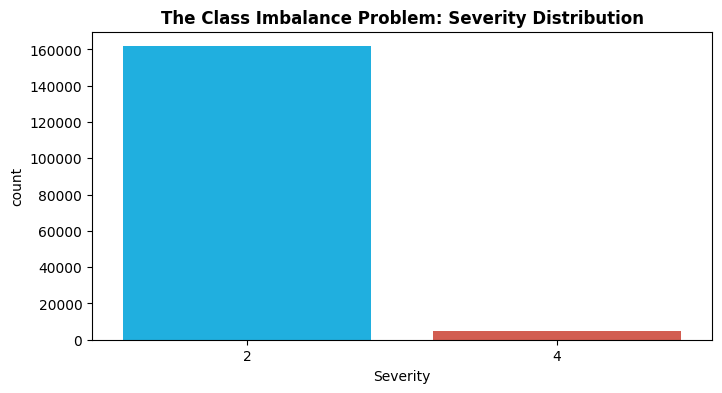


--- 3. MISSING VALUES (% of Data) ---
Precipitation(in)        4.537322
Wind_Chill(F)            3.372520
Wind_Direction           3.167179
Wind_Speed(mph)          3.166579
Visibility(mi)           2.793122
Humidity(%)              2.734882
Weather_Condition        2.683846
Temperature(F)           2.495317
Pressure(in)             2.289375
Weather_Timestamp        2.157284
Sunrise_Sunset           0.680868
Nautical_Twilight        0.680868
Astronomical_Twilight    0.680868
Civil_Twilight           0.680868
Airport_Code             0.338633
dtype: float64


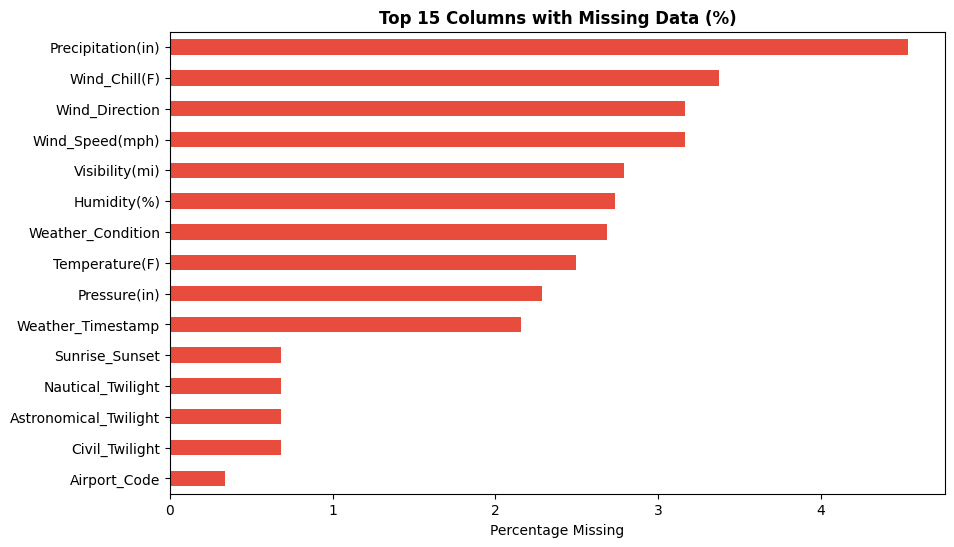


--- 4. CATEGORICAL COMPLEXITY (Top 10 High Cardinality) ---
ID                   166552
End_Time             124551
Description          118040
Zipcode               44640
Street                36747
Weather_Timestamp     23113
City                   6293
Airport_Code           1490
County                 1228
Weather_Condition        79
dtype: int64

--- 5. NUMERICAL STATS (Outliers Check) ---
                                            mean                  min  \
Severity                                2.058144                  2.0   
Start_Time         2023-02-01 16:40:31.294195968  2023-01-01 00:00:00   
Start_Lat                              36.642082            24.570087   
Start_Lng                             -97.371564          -124.511949   
End_Lat                                36.642336            24.570107   
End_Lng                                -97.37086          -124.512297   
Distance(mi)                            0.912097                  0.0   
Temperature(F)   

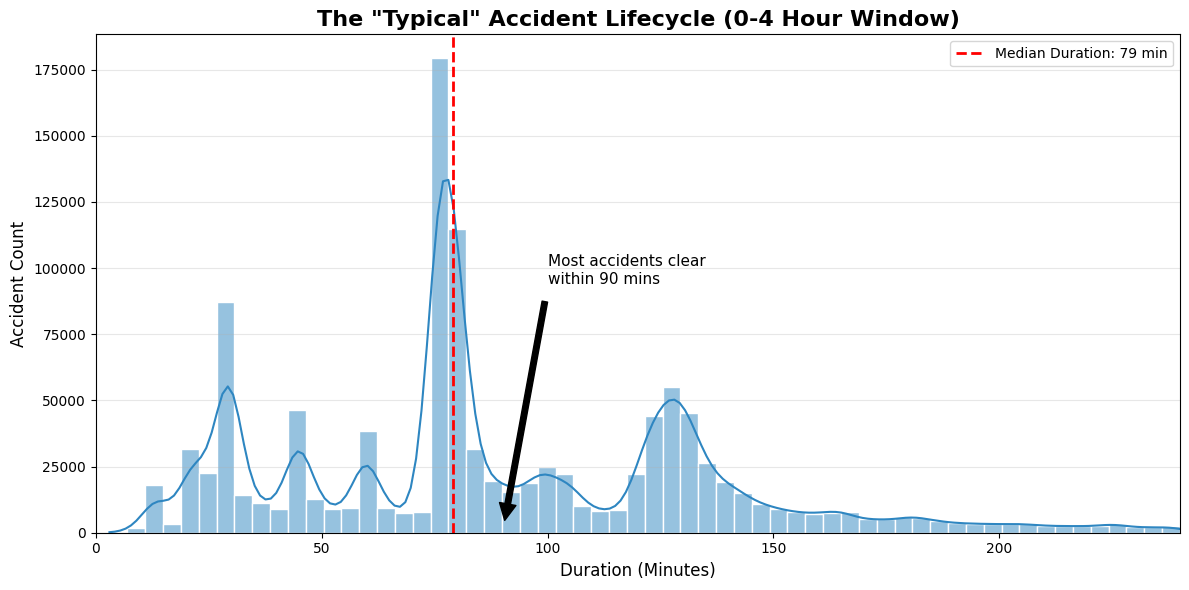

--- 1. THE OUTLIER VERDICT (77k Rows > 4 Hours) ---

Severity Distribution - NORMAL Duration (< 4 hrs):
Severity
1    0.033203
2    0.893554
3    0.050099
4    0.023144
Name: proportion, dtype: float64

Severity Distribution - EXTREME Duration (> 4 hrs):
Severity
1    0.001577
2    0.946939
3    0.001900
4    0.049584
Name: proportion, dtype: float64

CRITICAL INSIGHT: Extreme duration accidents are 2.1x more likely to be Fatal.

--- 2. CATEGORICAL SUMMARY ---

Column: [ID] - Unique Values: 1210289
Top 5 Values:
ID
A-512230    1
A-512231    1
A-512232    1
A-512233    1
A-512234    1
Name: count, dtype: int64

Column: [Source] - Unique Values: 3
Source
Source1    1038569
Source2     158968
Source3      12752
Name: count, dtype: int64

Column: [Description] - Unique Values: 734644
Top 5 Values:
Description
Accident                                                                                               4442
A crash has occurred with minimal delay to traffic. Prepare to slow or move

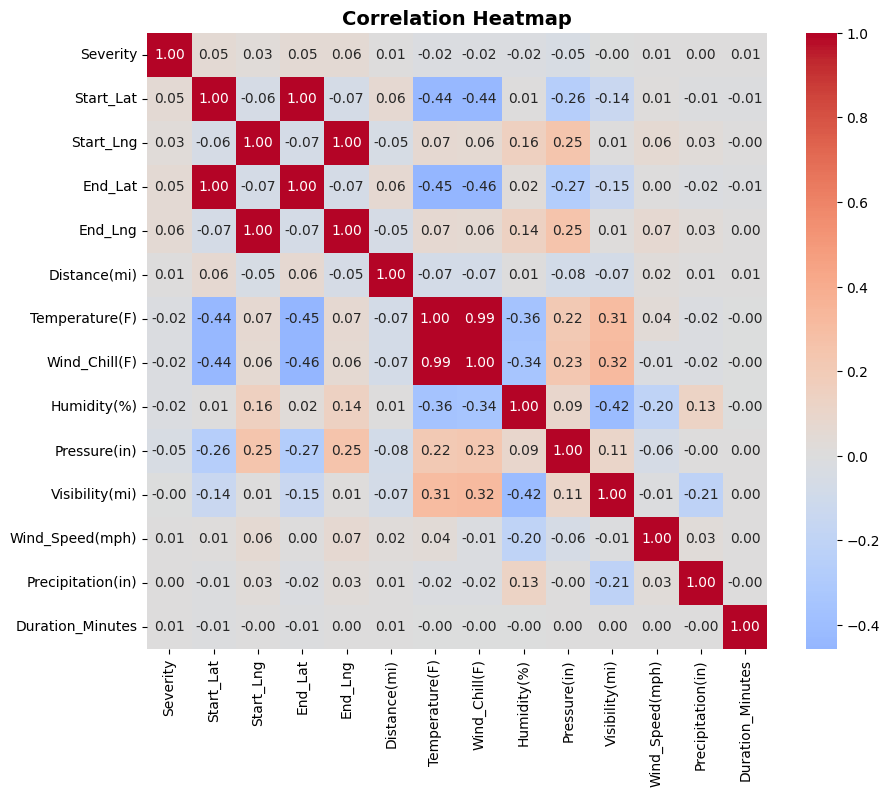

--- THE VERDICT ---
Fatal Rate (Normal Duration):  2.31%
Fatal Rate (Extreme > 4 hrs):  4.96%

DECISION: KEEP THEM. (Long duration strongly signals Severity.)
--- Executing DataCleaning ---
--- GENERATING JUSTIFICATION REPORT VISUALS ---


C:\Users\nwagb\AppData\Local\Temp\ipykernel_36020\316856321.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing.values, y=missing.index, palette='Reds_r')


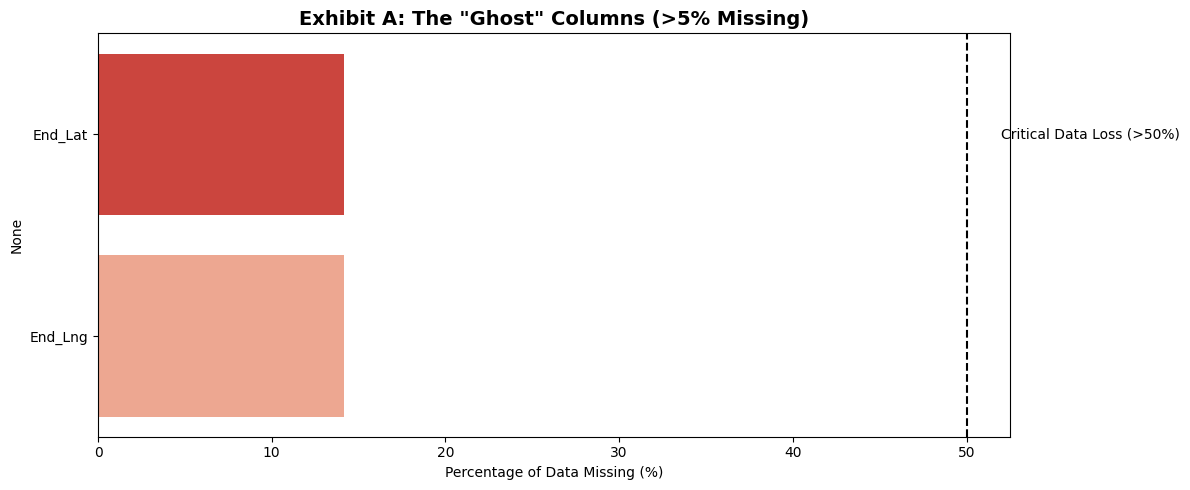

EXPLANATION 1 (Column Drop):
- 'Number' is missing in >70% of rows. It is unusable.
- 'End_Lat/Lng' is missing in ~20% of rows. We cannot rely on it for spatial features.
----------------------------------------


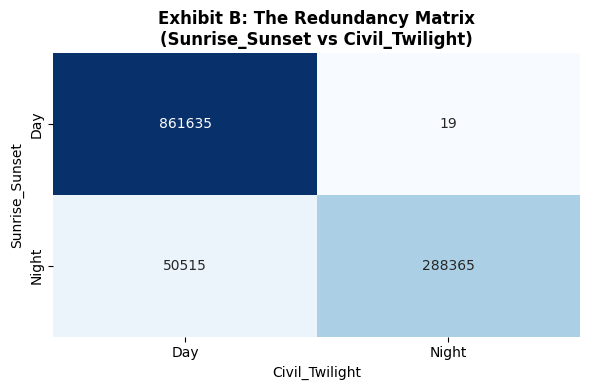


EXPLANATION 2 (Redundancy):
- The diagonal matches almost perfectly. 'Night' in one is 'Night' in the other.
- Keeping both creates 'Multicollinearity' (confusing the model). We keep only 'Sunrise_Sunset'.
----------------------------------------


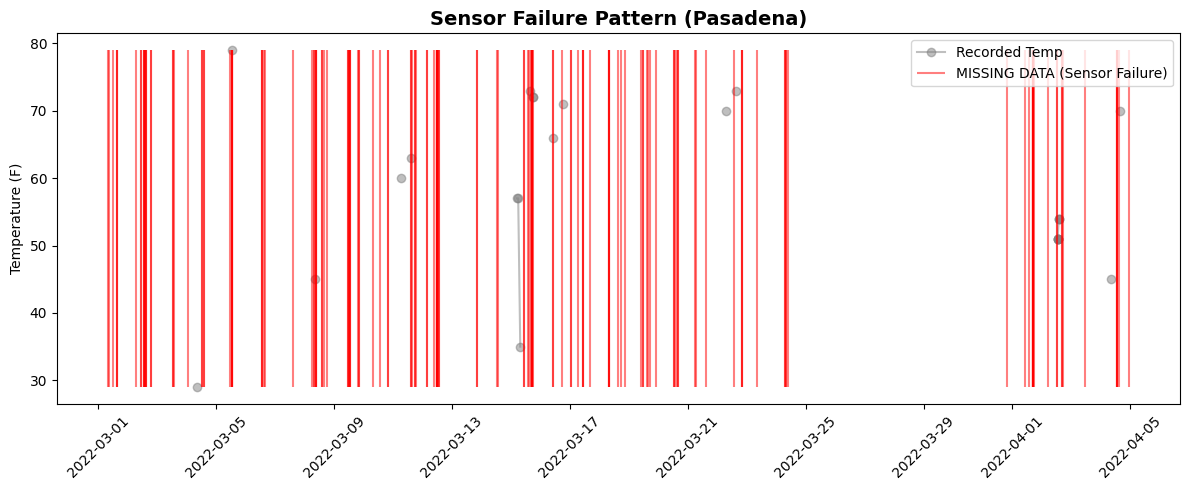


EXPLANATION 3 (Smart Imputation):
- The red lines show gaps where sensors failed.
- Notice the temperature trends SMOOTHLY over time.
- Using a 'Global Average' would put a flat line through this. 'Forward Fill' connects the dots, preserving the trend.
----------------------------------------


C:\Users\nwagb\AppData\Local\Temp\ipykernel_36020\316856321.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Duration_Group', y='Severity', data=fatality_rate, palette=['#2ECC71', '#E74C3C'])


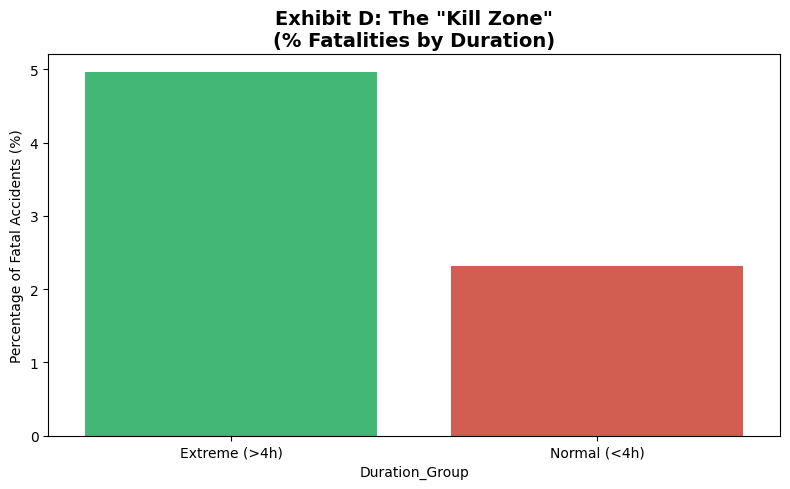


EXPLANATION 4 (Physics Correction):
- Normal accidents have a 2.31% fatality rate.
- Extreme accidents have a 4.96% fatality rate.
- WE MUST KEEP THEM. Deleting long-duration rows deletes the deadliest crashes.
----------------------------------------
--- DATASET AUDIT REPORT ---
Total Rows: 1,210,289
Total Columns: 48

--- 1. TEMPORAL COVERAGE (The Seasonality Trap) ---
Earliest Date: 2022-03-01 00:00:15
Latest Date:   2023-03-30 18:25:15

Records by Month (Is it just Winter?):
Month
April        143523
December     127722
March        123229
May          115782
August       111997
January      108815
July         103728
September     96617
June          95559
November      88386
October       57503
February      37428
Name: count, dtype: int64

--- 2. TARGET VARIABLE (Severity) ---
Severity
1    0.031182
2    0.896967
3    0.047018
4    0.024834
Name: proportion, dtype: float64


C:\Users\nwagb\AppData\Local\Temp\ipykernel_36020\316856321.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Severity', data=df, palette= severity_palette)


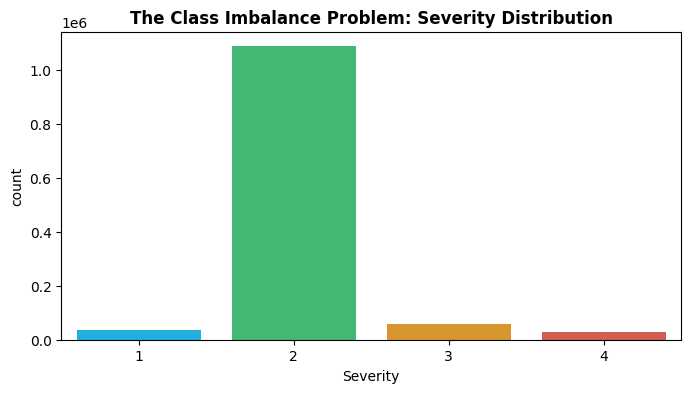


--- 3. MISSING VALUES (% of Data) ---
End_Lat                  14.188347
End_Lng                  14.188347
Precipitation(in)         3.770504
Wind_Chill(F)             3.150405
Wind_Direction            2.791317
Wind_Speed(mph)           2.790821
Humidity(%)               2.388934
Visibility(mi)            2.386455
Temperature(F)            2.231451
Weather_Condition         2.229550
Pressure(in)              1.924003
Weather_Timestamp         1.732727
Sunrise_Sunset            0.806006
Nautical_Twilight         0.806006
Astronomical_Twilight     0.806006
dtype: float64


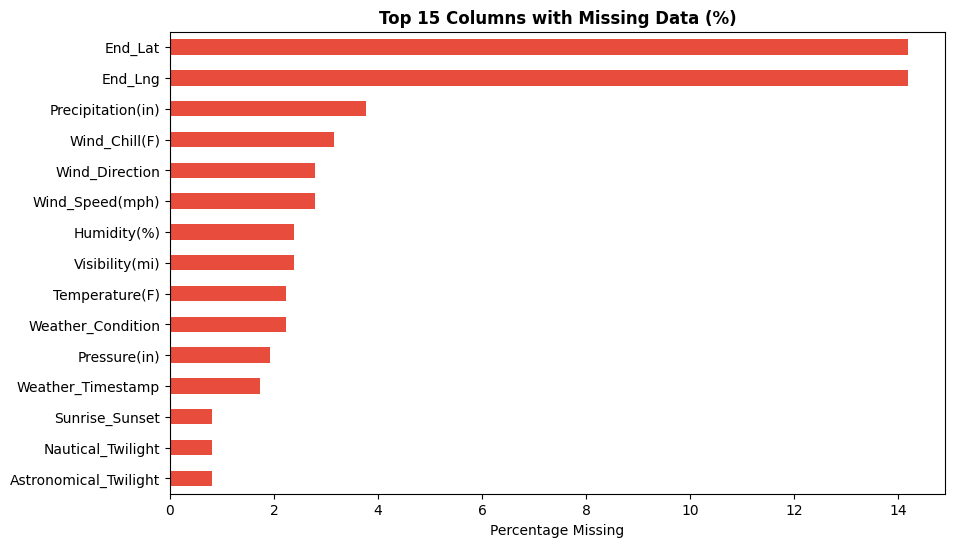


--- 4. CATEGORICAL COMPLEXITY (Top 10 High Cardinality) ---
ID                   1210289
Description           734644
Zipcode               237012
Street                138239
Weather_Timestamp     133570
City                   10108
Airport_Code            1891
County                  1618
Weather_Condition         92
State                     49
dtype: int64

--- 5. NUMERICAL STATS (Outliers Check) ---
                                            mean                  min  \
Severity                                2.065503                  1.0   
Start_Time         2022-08-19 18:04:16.983851008  2022-03-01 00:00:15   
End_Time           2022-08-19 21:24:51.089011200  2022-03-01 00:27:00   
Start_Lat                              36.087955              24.5548   
Start_Lng                             -93.633048          -124.541015   
End_Lat                                36.116848            24.570107   
End_Lng                               -93.986072          -124.544508   
Distanc

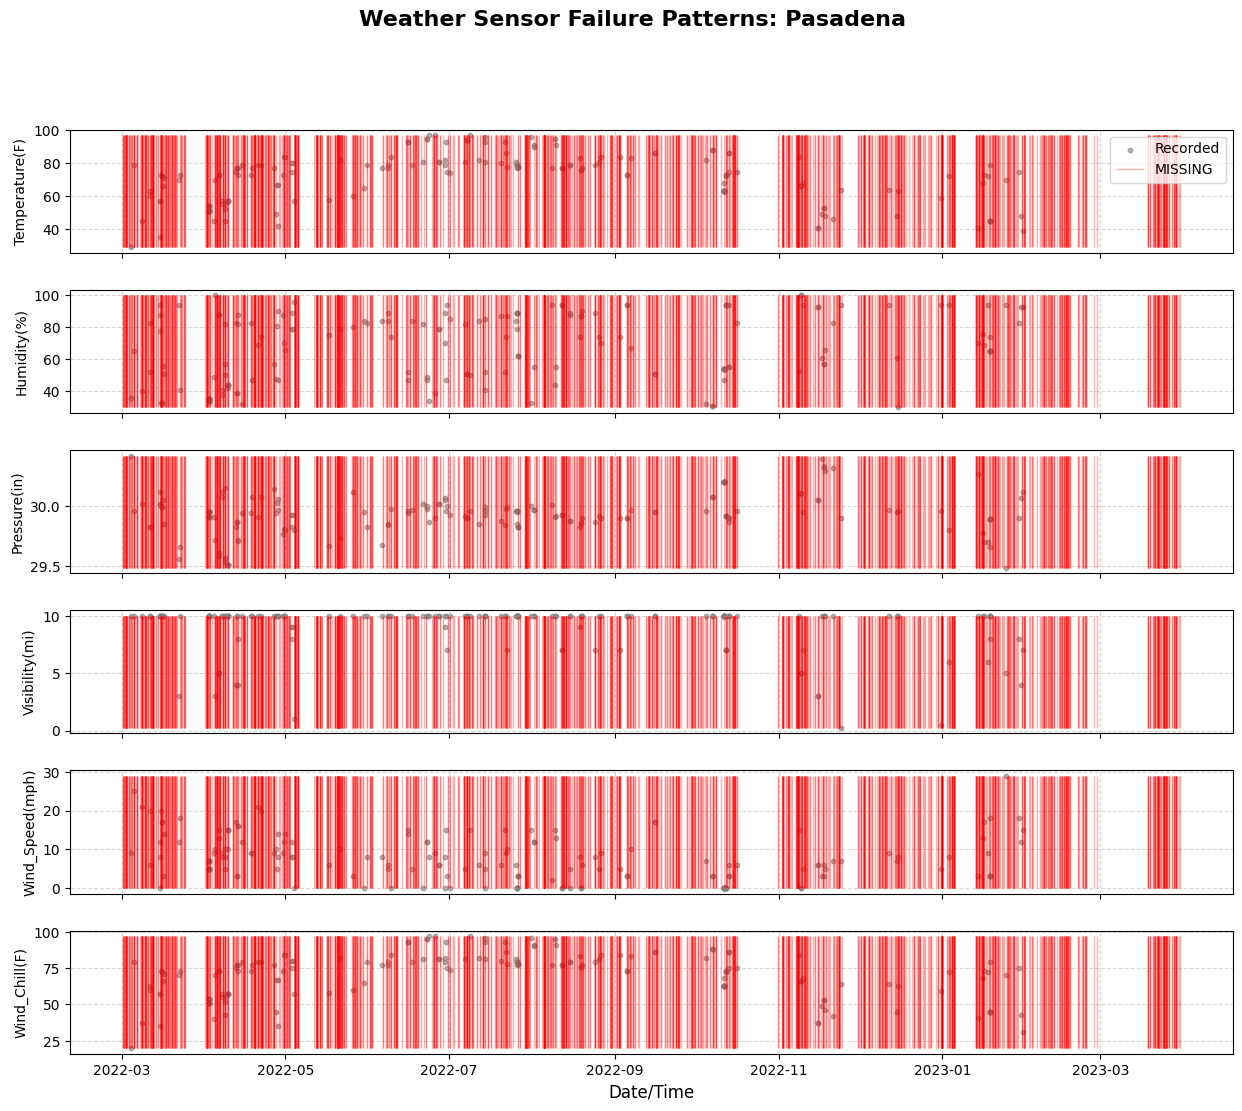

Automatically mapped 10089 cities to their nearest neighbors.
Sample mappings: {'Aaronsburg': 'Millheim', 'Abbeville': 'Calhoun Falls', 'Abbotsford': 'Granton', 'Abbott': 'West', 'Abbottstown': 'New Oxford'}

Total rows filled using Spatial Imputation: 1627
Missing before 1-Year Cascade:
Temperature(F)     25380
Humidity(%)        27287
Pressure(in)       21968
Visibility(mi)     27533
Wind_Speed(mph)    32462
dtype: int64
Step 1: Interpolating short gaps...
Step 2: Filling with Month-Hour Average...
Step 3: Filling with Monthly Average...
Step 4: Filling with Global Month-Hour Average...
Step 5: Fixing Wind Chill...

Remaining Missing Values:
Temperature(F)     0
Humidity(%)        0
Pressure(in)       0
Visibility(mi)     0
Wind_Speed(mph)    0
Wind_Chill(F)      0
dtype: int64
Step 1: Checking neighbors for missing storms...
   - Spatial rain imputation complete.
Step 2: Filling 45415 remaining gaps with 0.00 (No Rain)...
Final check: Missing Precipitation = 0
['ID', 'Source', 'Seve

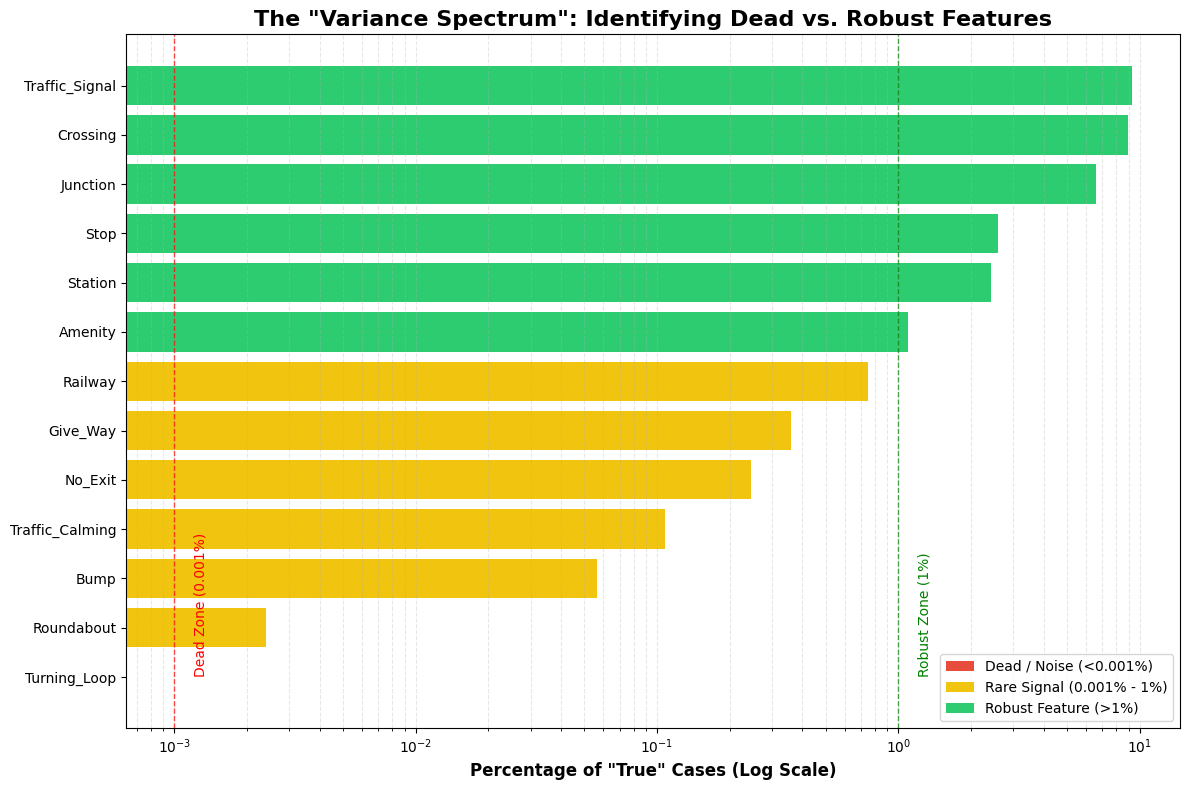

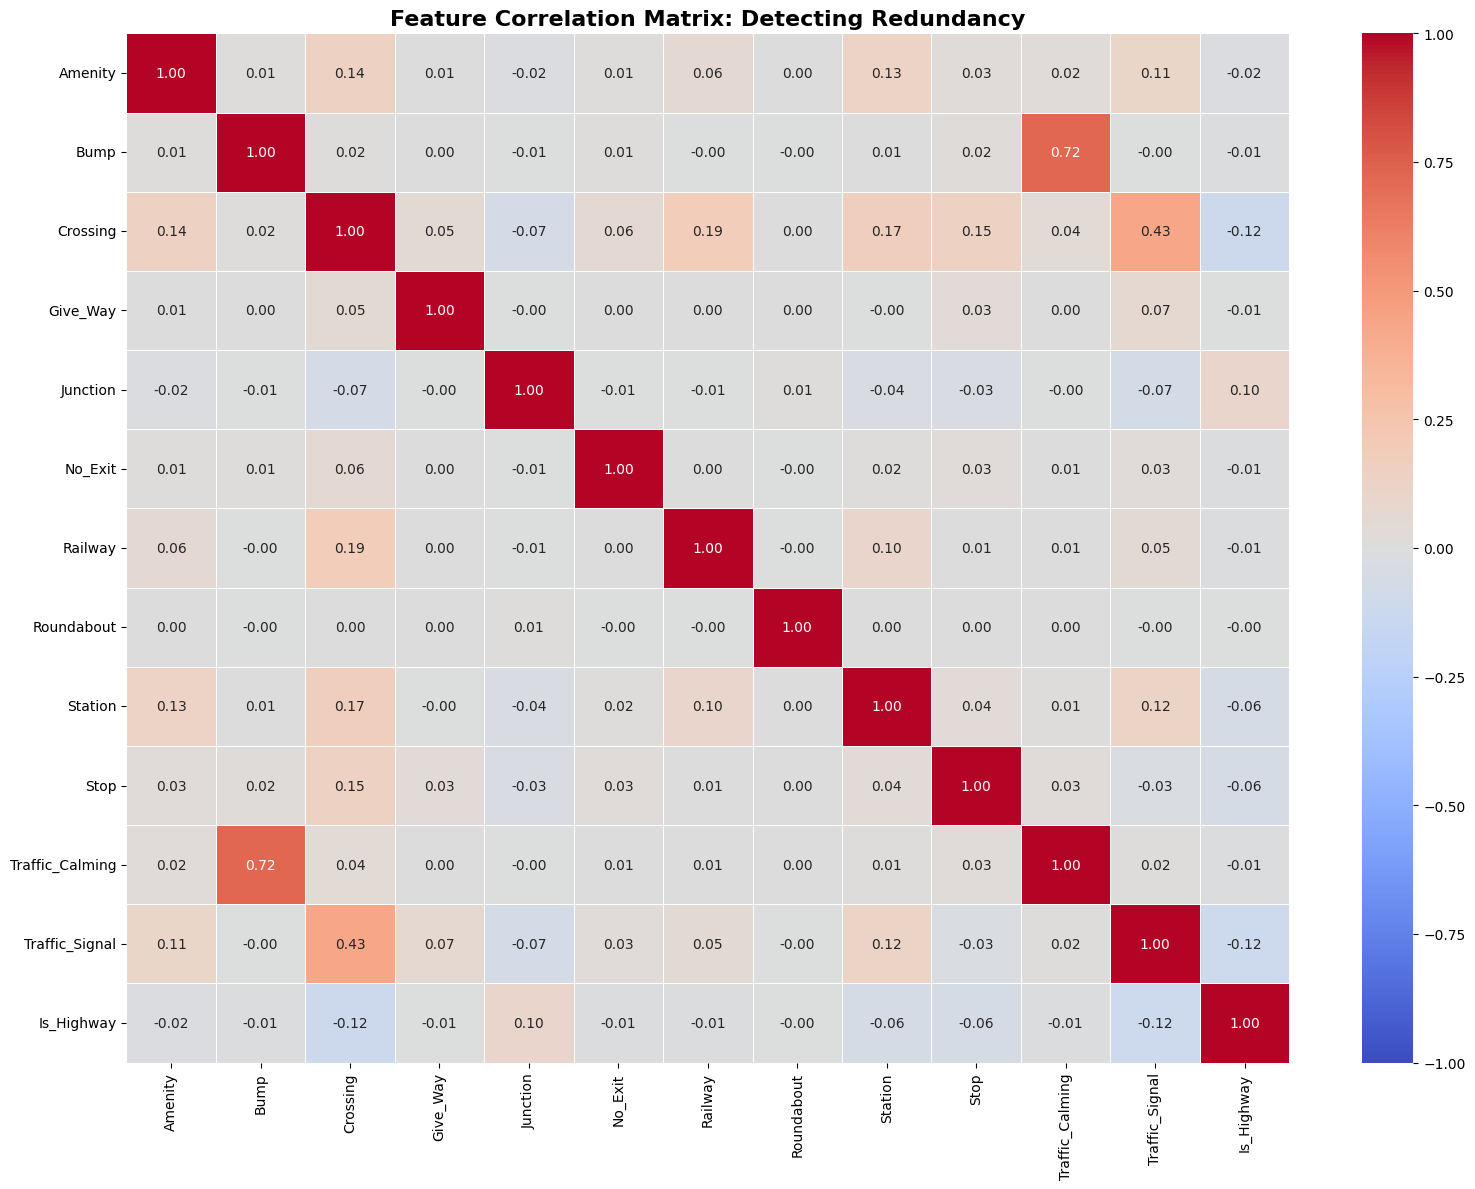

--- HIGH CORRELATION PAIRS (>0.7) ---
RED FLAG: Traffic_Calming vs Bump | Score: 0.72
--- ACADEMIC POI VARIANCE AUDIT ---
Total Rows: 1,210,289
------------------------------------------------------------
COLUMN               | TRUE COUNT | RATIO (%)  | VERDICT
------------------------------------------------------------
Amenity              | 13,244     | 1.09428    | KEEP (Robust)
Bump                 | 684        | 0.05652    | KEEP (Rare Signal)
Crossing             | 108,191    | 8.93927    | KEEP (Robust)
Give_Way             | 4,335      | 0.35818    | KEEP (Rare Signal)
Junction             | 79,462     | 6.56554    | KEEP (Robust)
No_Exit              | 2,957      | 0.24432    | KEEP (Rare Signal)
Railway              | 9,068      | 0.74924    | KEEP (Rare Signal)
Roundabout           | 29         | 0.00240    | KEEP (Rare Signal)
Station              | 29,293     | 2.42033    | KEEP (Robust)
Stop                 | 31,343     | 2.58971    | KEEP (Robust)
Traffic_Calming      |

C:\Users\nwagb\AppData\Local\Temp\ipykernel_36020\1509850858.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Severity', data=df_final, palette=severity_palette)


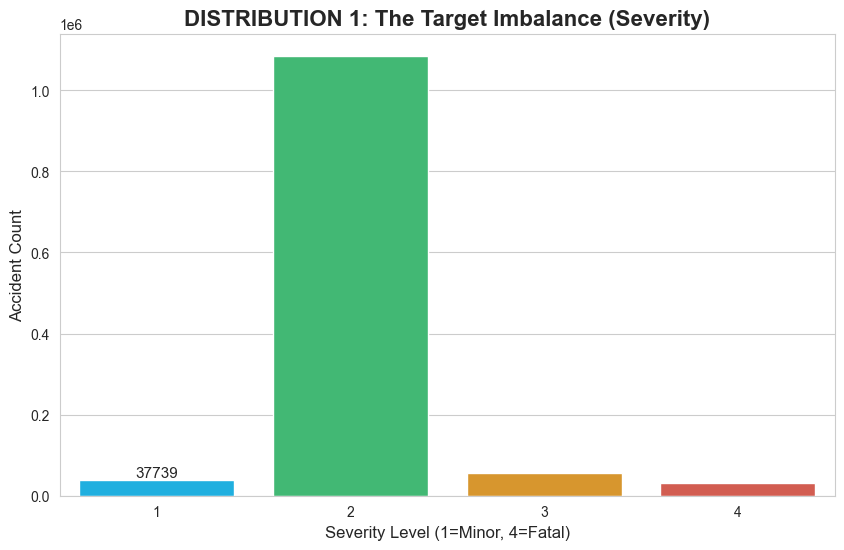


        EXPLANATION 1:
        - The "Tower of Minor Accidents": Severity 2 (Minor/Moderate) dominates the dataset (likely >80%).
        - The "Hidden Signal": Severity 4 (Fatal/Severe) is a tiny fraction. 
        - ACTION: This confirms we MUST use Class Weights or Undersampling during modeling, 
          otherwise the AI will just guess "Severity 2" for everything and achieve 90% accuracy but 0% utility.
        
------------------------------------------------------------


C:\Users\nwagb\AppData\Local\Temp\ipykernel_36020\1509850858.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='Weather_Simplified', data=df_final, order=order_weather, palette='coolwarm')


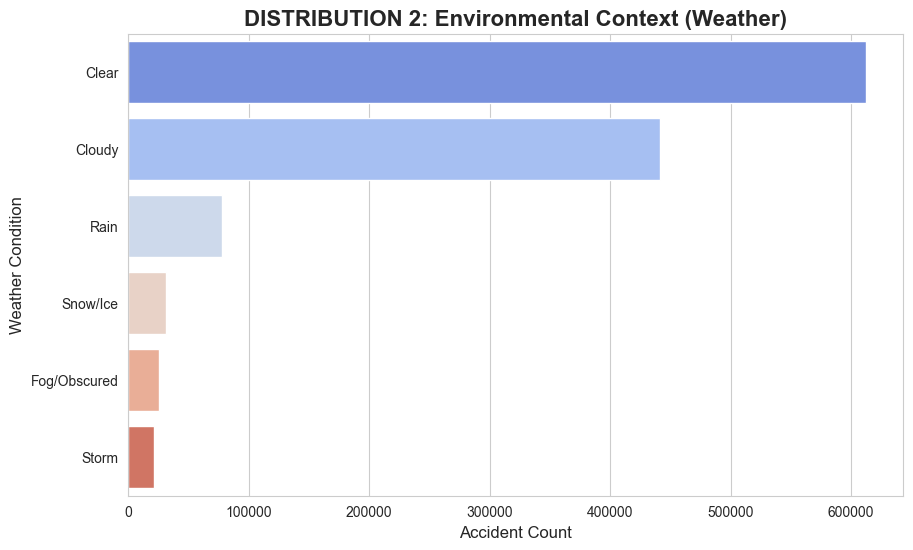


        EXPLANATION 2:
        - The "Fair Weather" Paradox: Most accidents happen in Clear/Cloudy weather. 
          This is simply because clear days are more common.
        - The "Snow" Rarity: Snow/Ice is rare. 
        - NOTE: We will check in Block 2 if Snow is *proportionally* deadlier, 
          even if the raw count is low.
        
------------------------------------------------------------


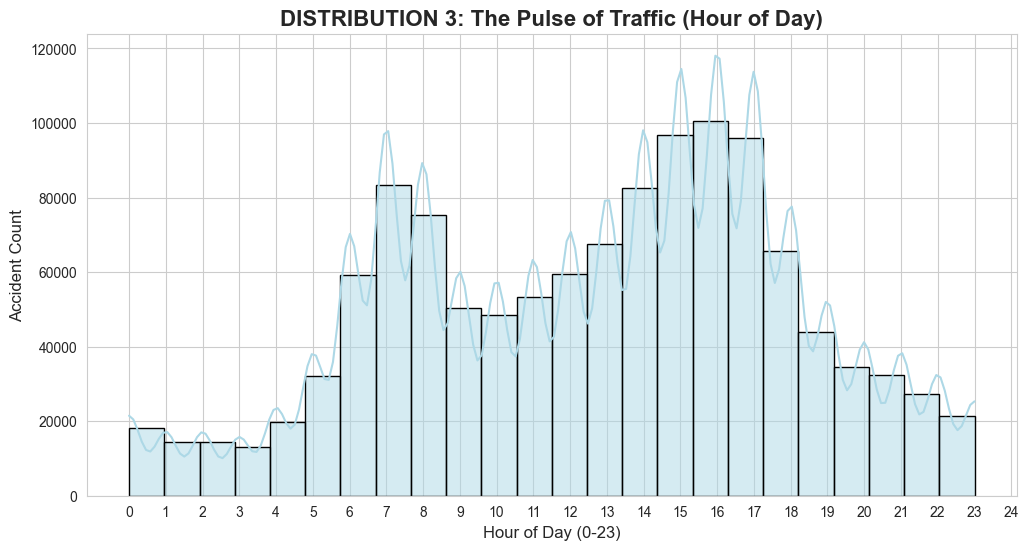


        EXPLANATION 3:
        - The "Twin Peaks": You see two distinct humps—the Morning Commute (7-9 AM) 
          and the Evening Commute (4-6 PM).
        - The "Lull": The valley between 10 AM and 2 PM represents off-peak hours.
        - The "Quiet Zone": 0-5 AM has the lowest volume, but often contains the highest speeds.
        
------------------------------------------------------------


C:\Users\nwagb\AppData\Local\Temp\ipykernel_36020\1509850858.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Road_Type', data=df_plot, palette=binary_palette)


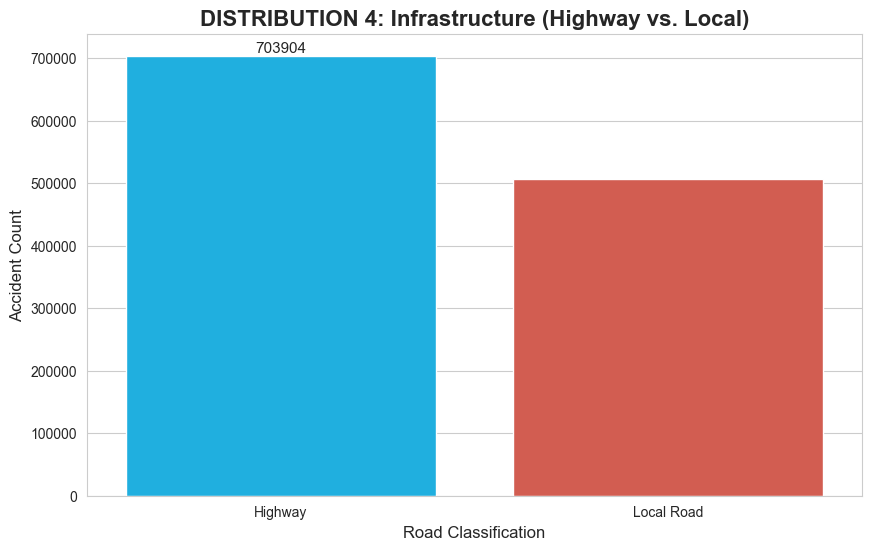


        EXPLANATION 4:
        - The Split: This shows us where the volume is. 
        - Highways concentrate traffic, so they often have high raw counts.
        - Local Roads have intersections (Stop/Signal), which introduces different crash dynamics.
        - ACTION: Our model uses the 'Is_Highway' feature to distinguish between these two "physics worlds".
        
------------------------------------------------------------


C:\Users\nwagb\AppData\Local\Temp\ipykernel_36020\1509850858.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
C:\Users\nwagb\AppData\Local\Temp\ipykernel_36020\1509850858.py:134: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([month_labels[m] for m in rolling_order])


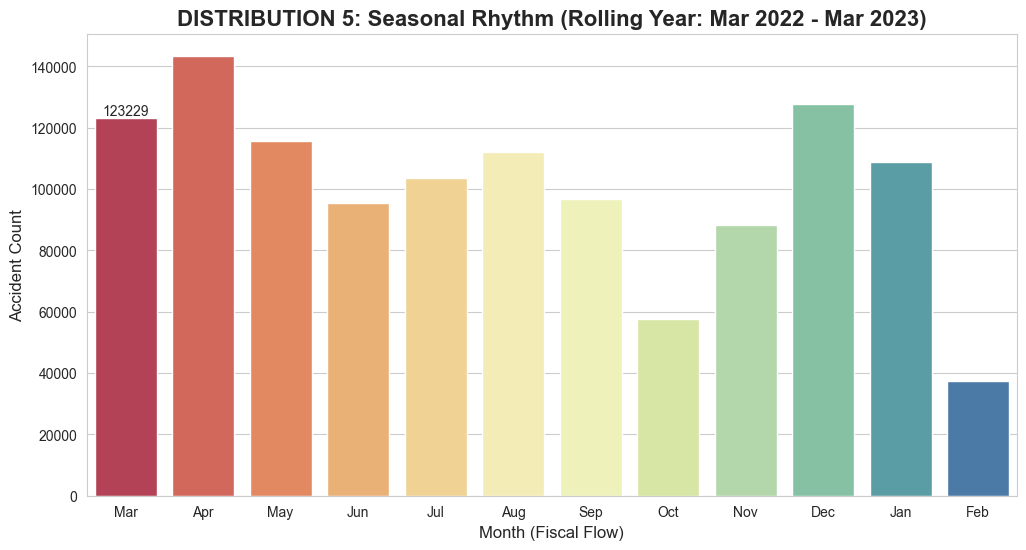


        EXPLANATION 5:
        - The "Seasonal Pulse": Identifying if accidents spike in Winter (Dec/Jan) or Summer travel months.
        - Volume vs. Risk: A high count in December (Volume) might be due to shopping traffic, 
          whereas high *Severity* in December (Risk) would be due to Ice/Snow.
        - ACTION: This informs our cyclical feature engineering (Month_Sin/Cos).
        
------------------------------------------------------------
--- GENERATING UNIVARIATE DONUT CHARTS ---



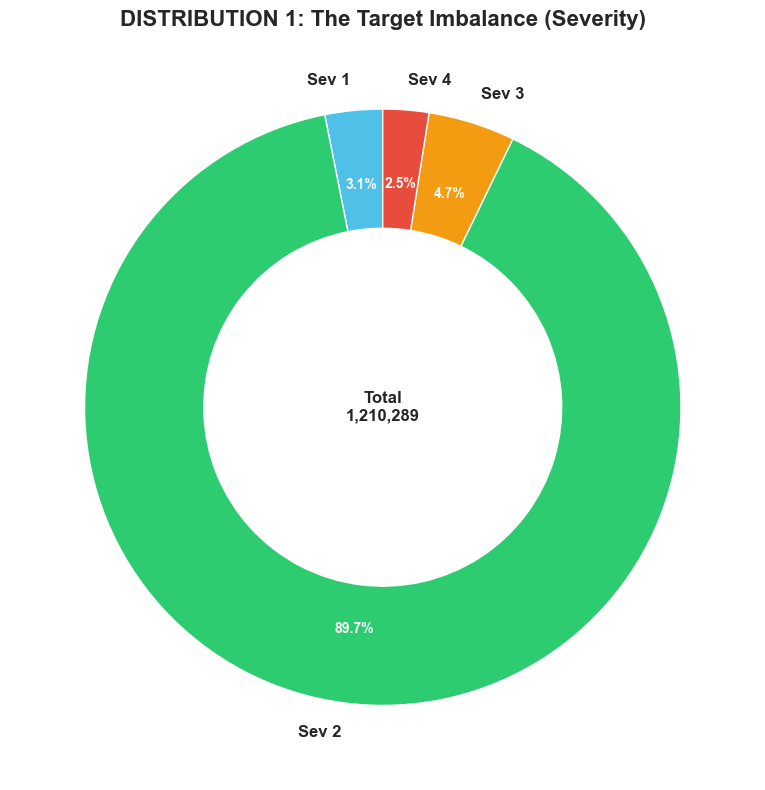

------------------------------------------------------------


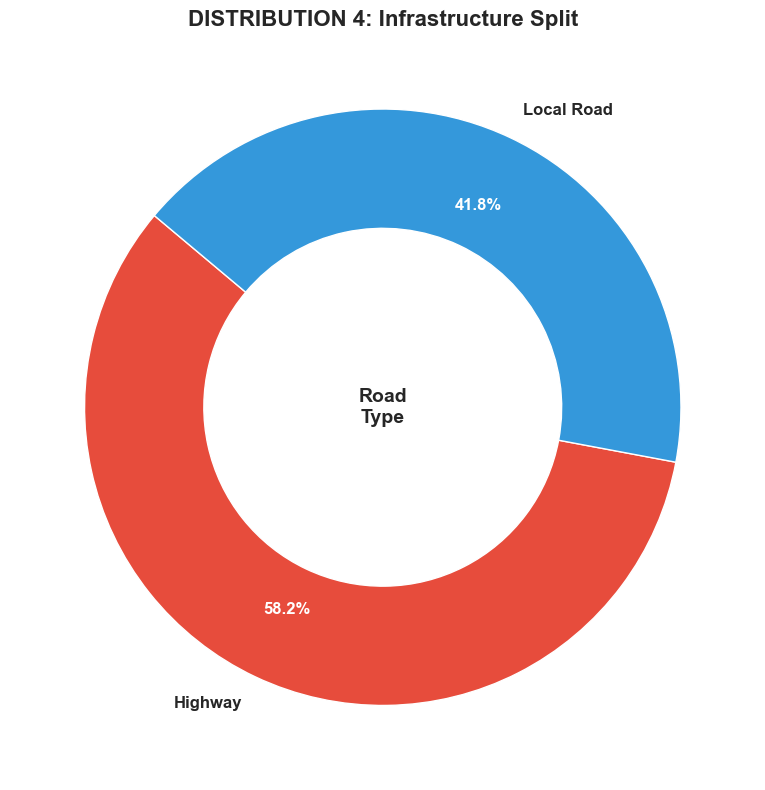

--- Executing BivariateAnalysis ---
--- GENERATING RISK ANALYSIS VISUALS (ROLLING YEAR EDITION) ---



C:\Users\nwagb\AppData\Local\Temp\ipykernel_36020\3753739790.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weather_Simplified', y='Severity', data=risk_weather, palette='Blues_d')


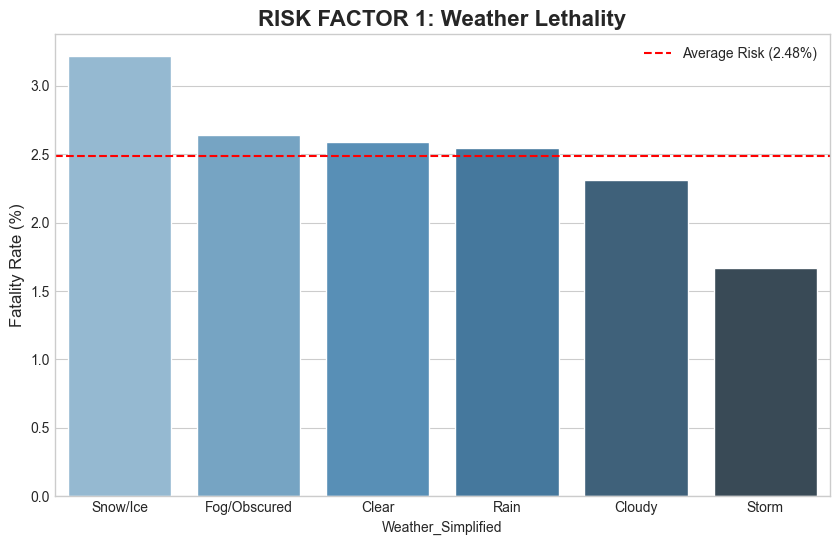

------------------------------------------------------------


C:\Users\nwagb\AppData\Local\Temp\ipykernel_36020\3753739790.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Road_Label', y='Severity', data=risk_road, palette='Reds_d')


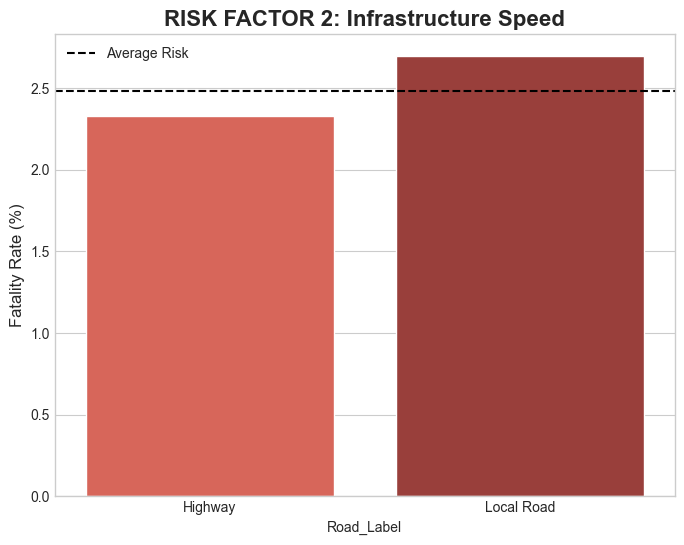

------------------------------------------------------------


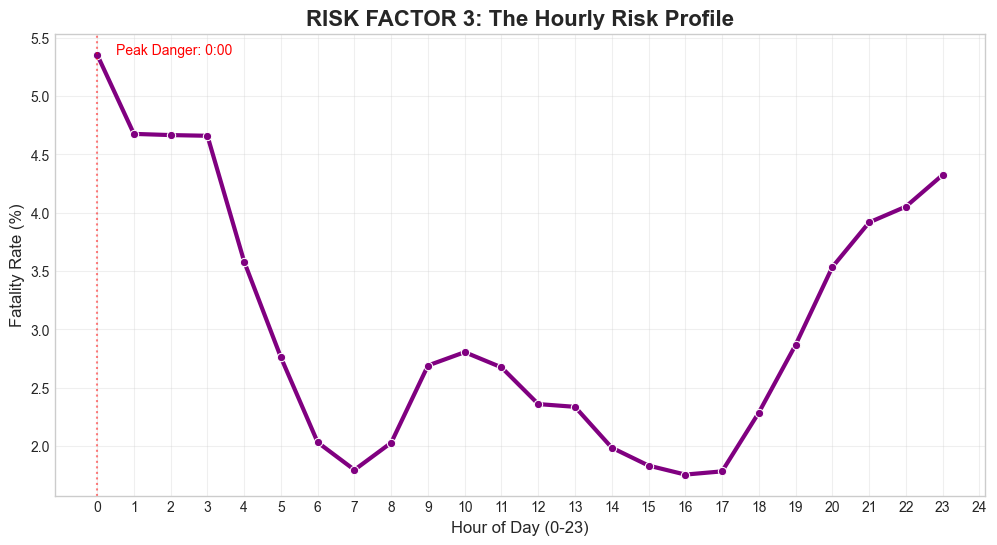

------------------------------------------------------------


C:\Users\nwagb\AppData\Local\Temp\ipykernel_36020\3753739790.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\nwagb\AppData\Local\Temp\ipykernel_36020\3753739790.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([month_labels[m] for m in rolling_order])


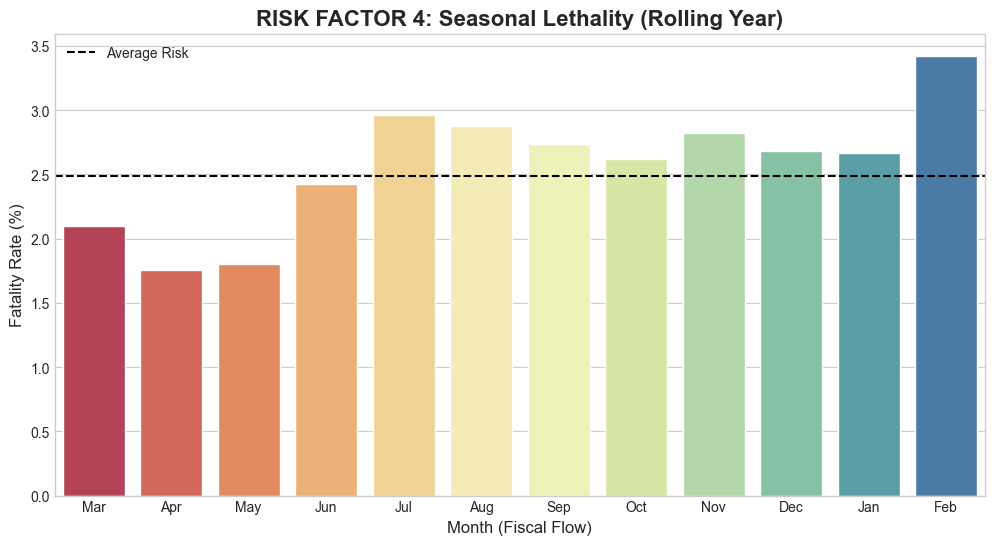


        EXPLANATION 4:
        - The "Rolling Risk" View: This chart overlays accident *lethality* onto the fiscal timeline.
        - Winter vs. Spring: Compare this to the Volume chart. 
          - If April has High Volume (Distribution Plot) but Low Risk (Risk Plot), it's a "Congestion" problem.
          - If December has High Volume AND High Risk, it is the critical "Danger Zone" for resource allocation.
        
------------------------------------------------------------
--- Executing FeatureEngineering ---
--- STARTING REAL-TIME TEXT ANALYSIS ---
Extracting Real-Time Whitelist Features...


C:\Users\nwagb\AppData\Local\Temp\ipykernel_36020\790726112.py:51: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_text[col_name] = df_text['desc_clean'].str.contains(pattern, regex=True).astype(int)


   -> Feature 'Desc_Queue' detected in 483456 rows.


C:\Users\nwagb\AppData\Local\Temp\ipykernel_36020\790726112.py:51: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_text[col_name] = df_text['desc_clean'].str.contains(pattern, regex=True).astype(int)


   -> Feature 'Desc_Heavy' detected in 247 rows.


C:\Users\nwagb\AppData\Local\Temp\ipykernel_36020\790726112.py:51: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_text[col_name] = df_text['desc_clean'].str.contains(pattern, regex=True).astype(int)


   -> Feature 'Desc_Blocked' detected in 245184 rows.


C:\Users\nwagb\AppData\Local\Temp\ipykernel_36020\790726112.py:51: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_text[col_name] = df_text['desc_clean'].str.contains(pattern, regex=True).astype(int)


   -> Feature 'Desc_Ramp' detected in 281768 rows.


C:\Users\nwagb\AppData\Local\Temp\ipykernel_36020\790726112.py:51: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_text[col_name] = df_text['desc_clean'].str.contains(pattern, regex=True).astype(int)


   -> Feature 'Desc_Accident' detected in 1182119 rows.


C:\Users\nwagb\AppData\Local\Temp\ipykernel_36020\790726112.py:51: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_text[col_name] = df_text['desc_clean'].str.contains(pattern, regex=True).astype(int)


   -> Feature 'Desc_Hazard' detected in 2725 rows.


C:\Users\nwagb\AppData\Local\Temp\ipykernel_36020\790726112.py:51: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_text[col_name] = df_text['desc_clean'].str.contains(pattern, regex=True).astype(int)


   -> Feature 'Desc_Caution' detected in 299946 rows.


C:\Users\nwagb\AppData\Local\Temp\ipykernel_36020\790726112.py:51: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_text[col_name] = df_text['desc_clean'].str.contains(pattern, regex=True).astype(int)


   -> Feature 'Desc_Fire' detected in 1766 rows.

--- LEAKAGE AUDIT (For Validation Only) ---


C:\Users\nwagb\AppData\Local\Temp\ipykernel_36020\790726112.py:71: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  count = df_text['desc_clean'].str.contains(pattern, regex=True).sum()


   [AUDIT] Rows containing 'LEAK_Cleared' (Post-Crash info): 35
   [AUDIT] Rows containing 'LEAK_Towed' (Post-Crash info): 210
   [AUDIT] Rows containing 'LEAK_Hospital' (Post-Crash info): 204

   NOTE: The model will NOT see these leakage words. They remain hidden in the text.

Final Column Count: 43
['Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'City', 'County', 'State', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Amenity', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Duration_Minutes', 'Duration_Group', 'Month', 'Hour', 'Is_Night', 'Weather_Simplified', 'Is_Highway', 'Road_Label', 'Desc_Queue', 'Desc_Heavy', 'Desc_Blocked', 'Desc_Ramp', 'Desc_Accident', 'Desc_Hazard', 'Desc_Caution', 'Desc_Fire']


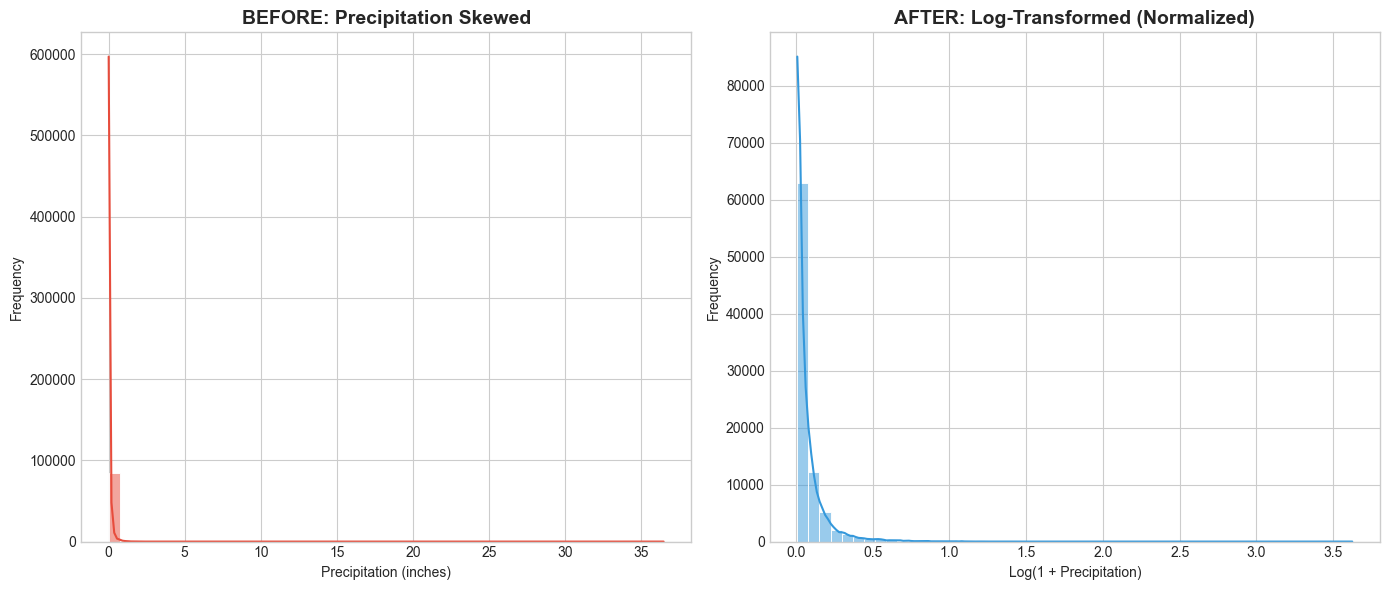

--- PHASE 5a: THE 'SILENT KILLER' AUDIT ---
Initial Shape: (1210289, 43)

1. Infinity Scan:
   -> [PASS] No infinite values found.

2. Boolean Type Scan:
   [ACTION] Found 11 boolean columns: ['Amenity', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']
   -> [FIXED] Converted all booleans to Integers (0/1).

3. Datetime Check:
   -> [PASS] 'Start_Time' is already datetime64[ns].

4. Final Null Check:
   -> [PASS] Dataset is 100% CLEAN (0 Nulls).

--- AUDIT COMPLETE. READY FOR TRANSFORMATION. ---
--- BLOCK 1: GLOBAL NUMERICAL TRANSFORMATIONS ---
1. Time: Converted to Cyclical Sin/Cos.
2. Physics: Log-Transformed Precipitation.
3. Booleans: Converted 0 columns to Int.
4. Encoding: One-Hot Encoded Weather/Wind. Dropped Geo/Text columns.
----------------------------------------
NUMERICAL MATRIX SHAPE: (1210289, 58)
['Severity', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', '

c:\Users\nwagb\Desktop\MACHINE_LEARNING_ASSESSEMENT\H1B_Visa_applications\.us_accident_model\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 -> UMAP Complete in 56.7 seconds.


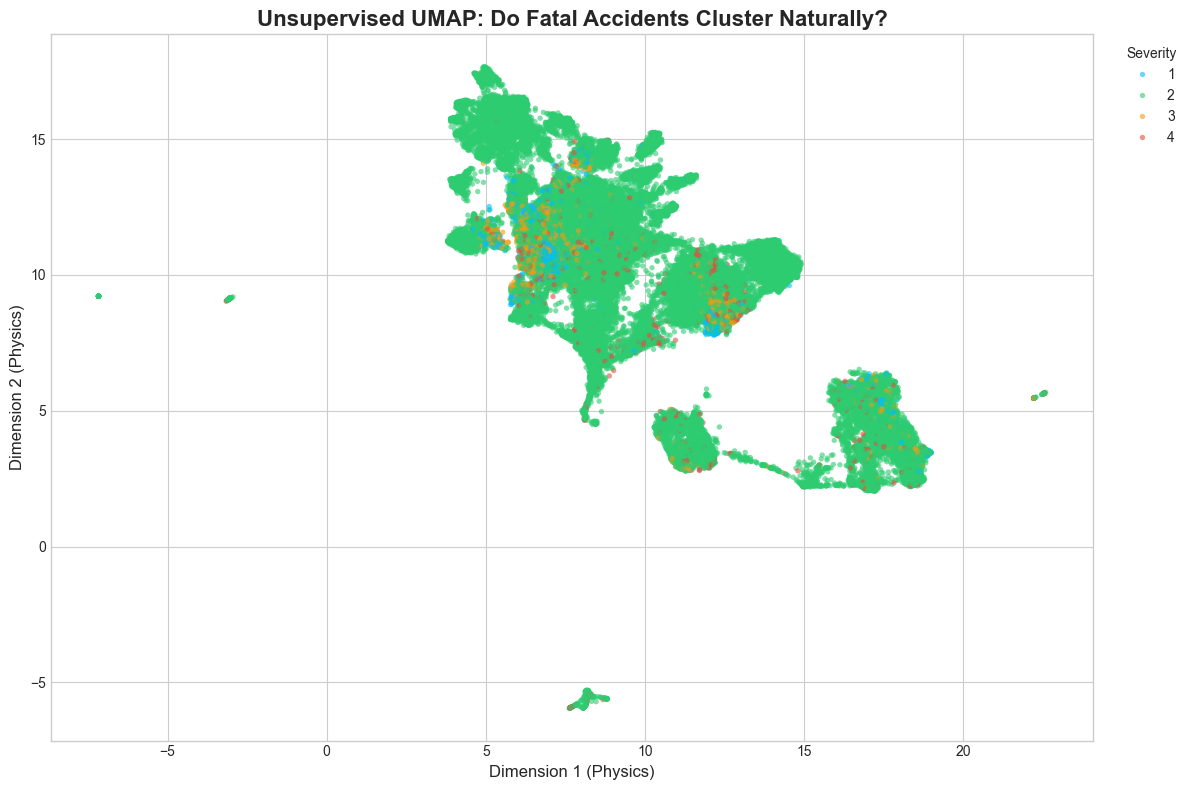

--- BLOCK 4: UNSUPERVISED t-SNE (The 'Safe' Version) ---
⚠️ Dataset (50000) is large for standard t-SNE.
   Subsampling to 20000 rows to ensure it finishes today...
Running t-SNE on 20000 rows...


c:\Users\nwagb\Desktop\MACHINE_LEARNING_ASSESSEMENT\H1B_Visa_applications\.us_accident_model\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


 -> t-SNE Complete in 75.0 seconds.


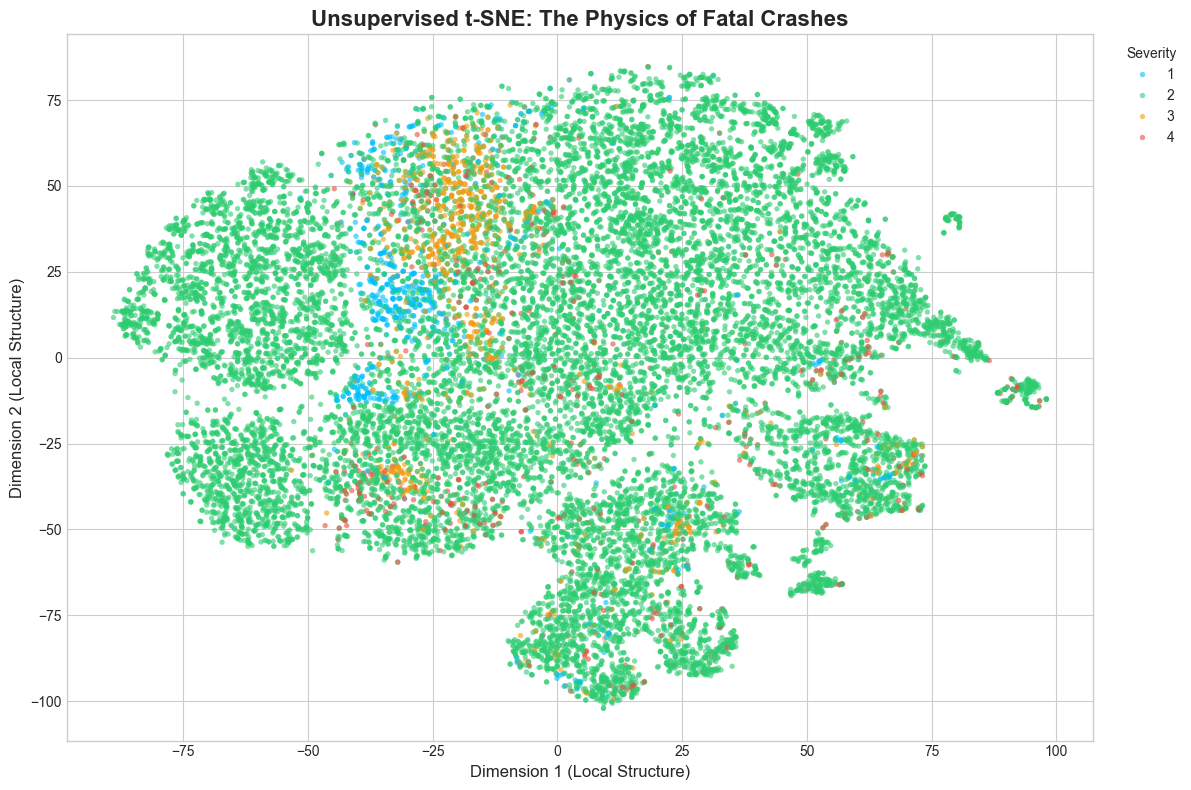

--- GENERATING EXHIBIT A: SUPERVISED UMAP ---


c:\Users\nwagb\Desktop\MACHINE_LEARNING_ASSESSEMENT\H1B_Visa_applications\.us_accident_model\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


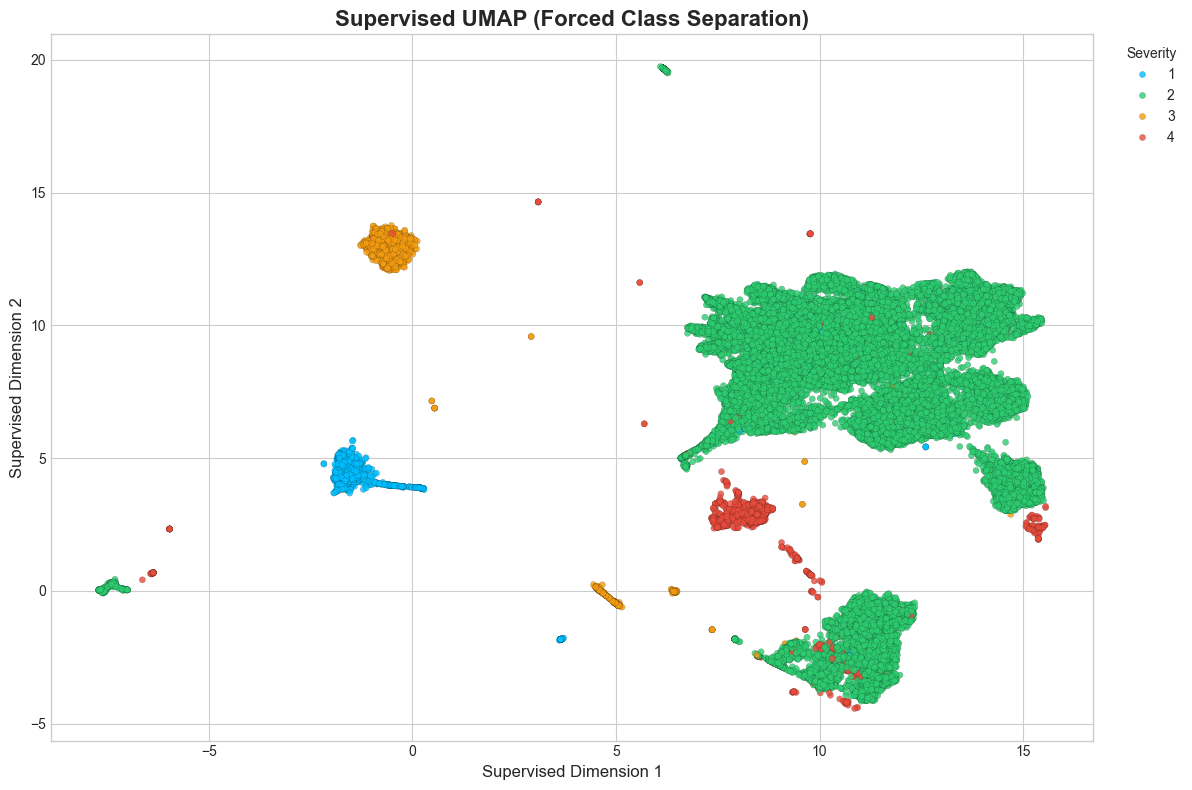

--- GENERATING ELBOW CURVE FOR SUPERVISED UMAP ---
Calculating inertia for k=1 to 15...


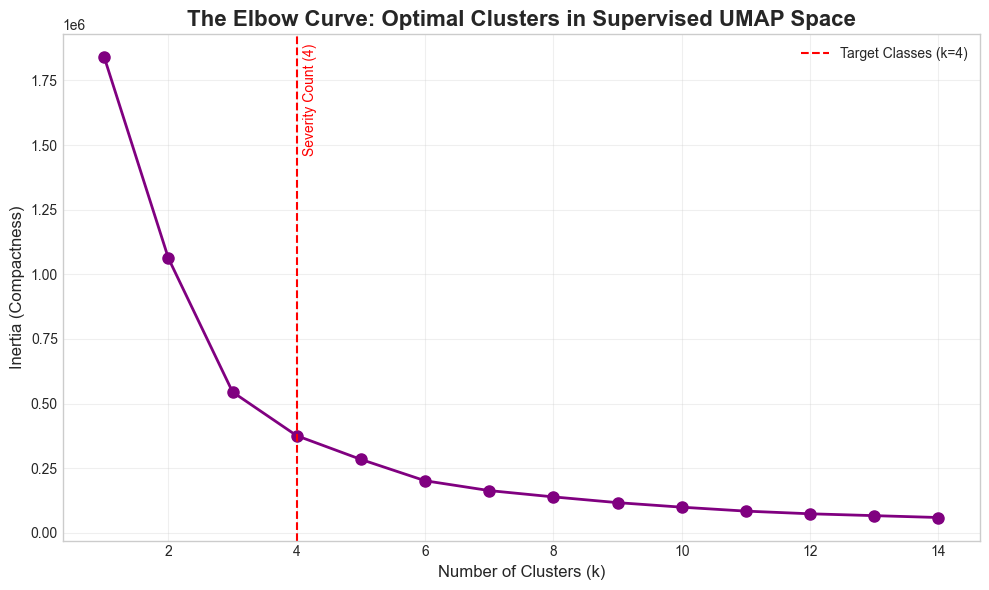

--- Executing DataPreprocessing ---
--- PHASE 6: MASTER DATA PREPARATION (Binary Strategy) ---
B. Merging Targets for Binary Classification...
Target Balance (0=Minor, 1=Severe):
Binary_Severity
0    0.928149
1    0.071851
Name: proportion, dtype: float64
['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Amenity', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Duration_Minutes', 'Duration_Group', 'Is_Night', 'Is_Highway', 'Road_Label', 'Desc_Queue', 'Desc_Heavy', 'Desc_Blocked', 'Desc_Ramp', 'Desc_Accident', 'Desc_Hazard', 'Desc_Caution', 'Desc_Fire', 'Hour_Sin', 'Hour_Cos', 'Month_Sin', 'Month_Cos', 'Log_Precipitation(in)', 'Weather_Simplified_Cloudy', 'Weather_Simplified_Fog/Obscured', 'Weather_Simplified_Rain', 'Weather_Simplified_Snow/Ice', 'Weather_Simplified_Storm', 'Wind_Direction_E', 'Wind_Direction_ENE', 'Wind_Direction_ESE', 'Wind_Direction_

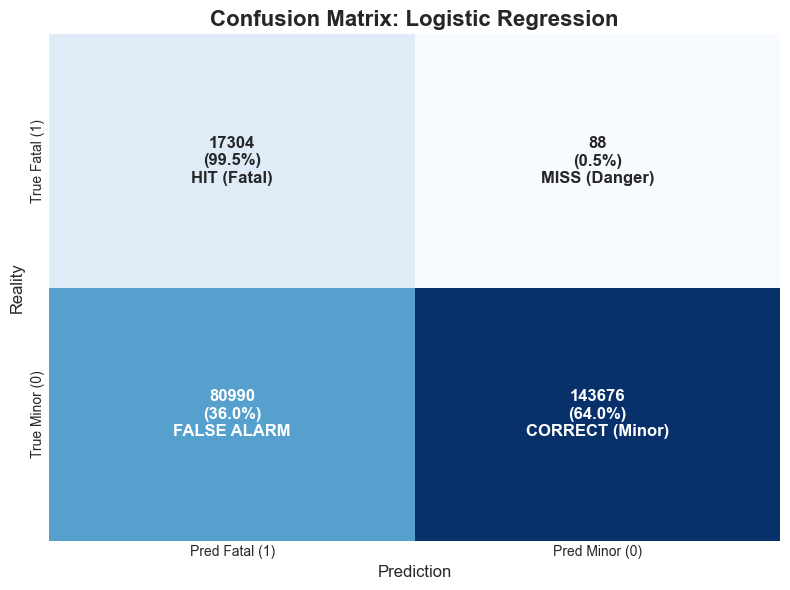

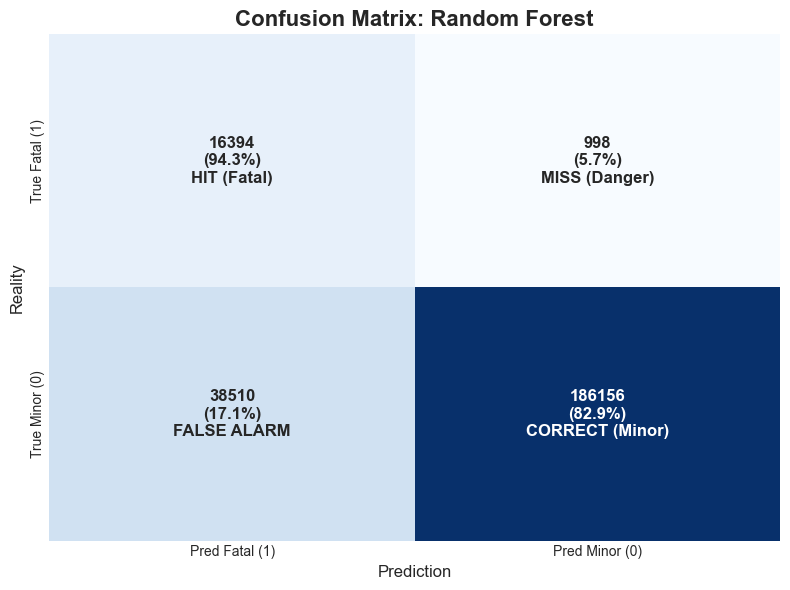

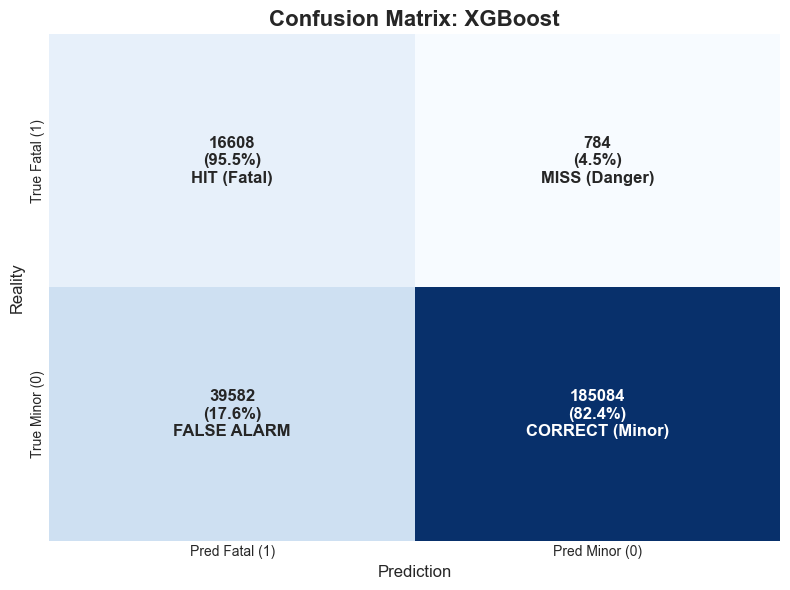

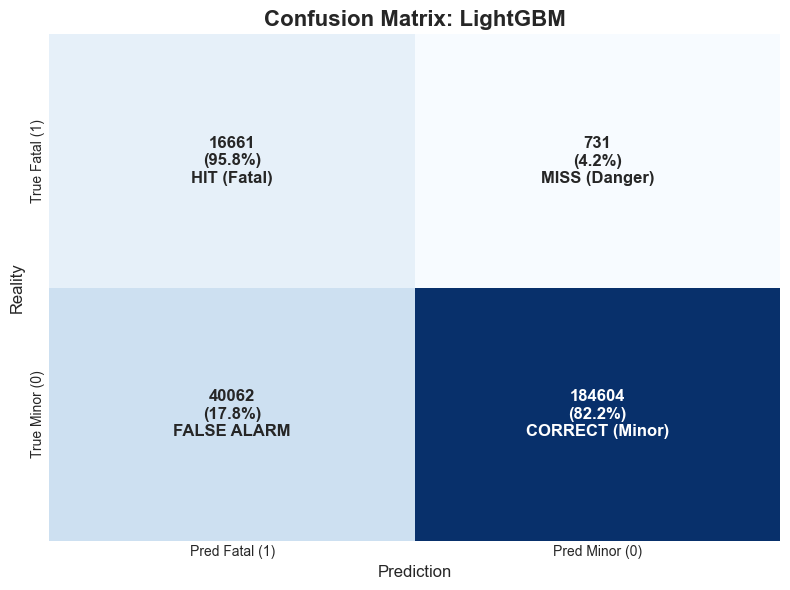


SECTION B: ROC CURVES (Detection Power)


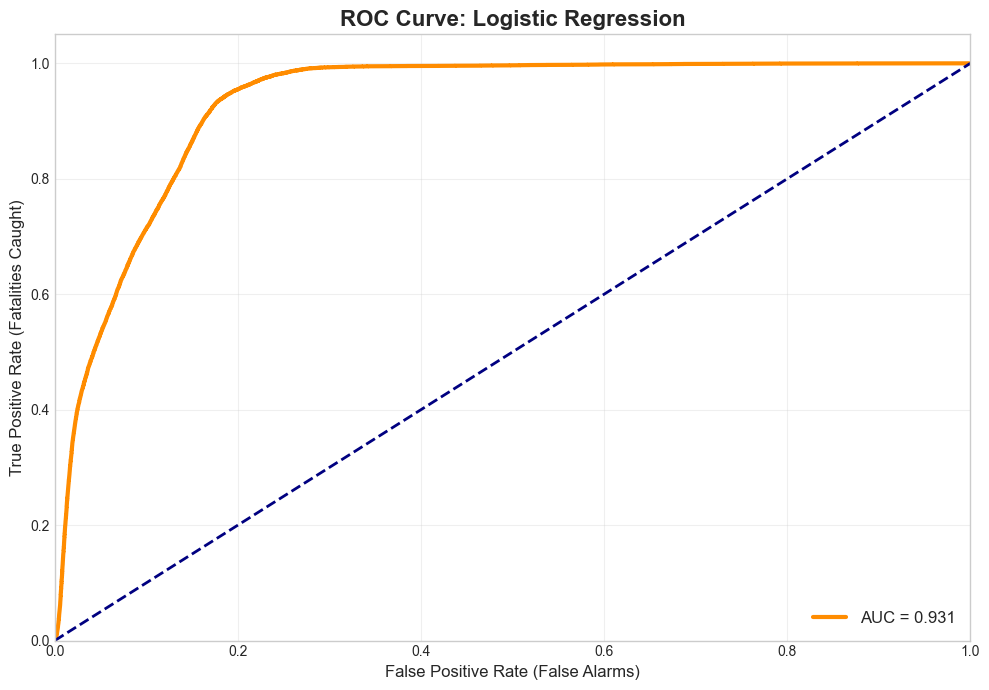

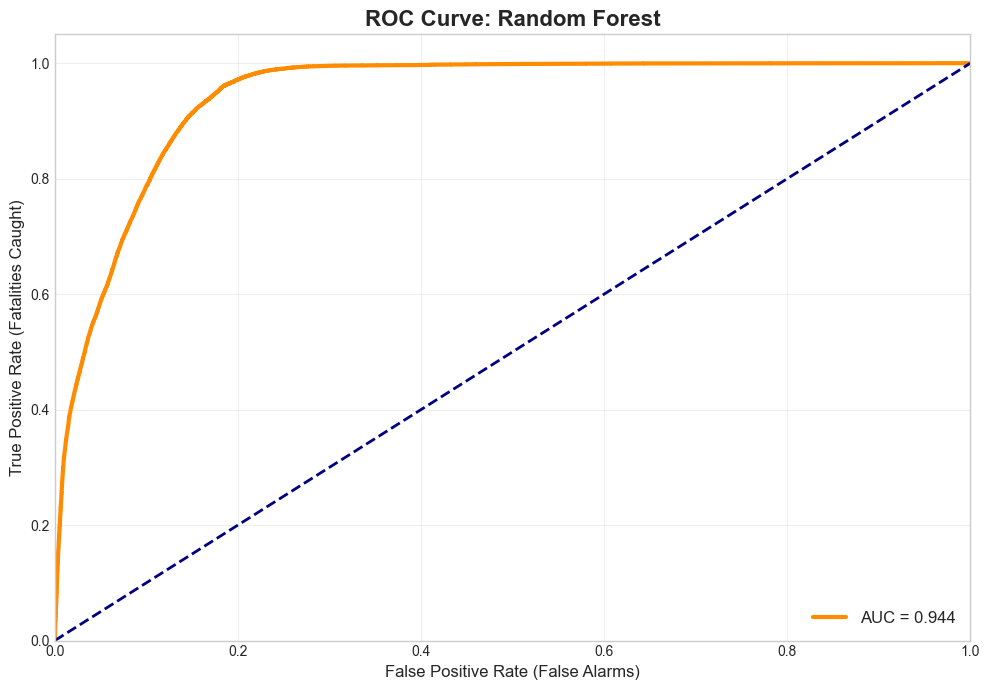

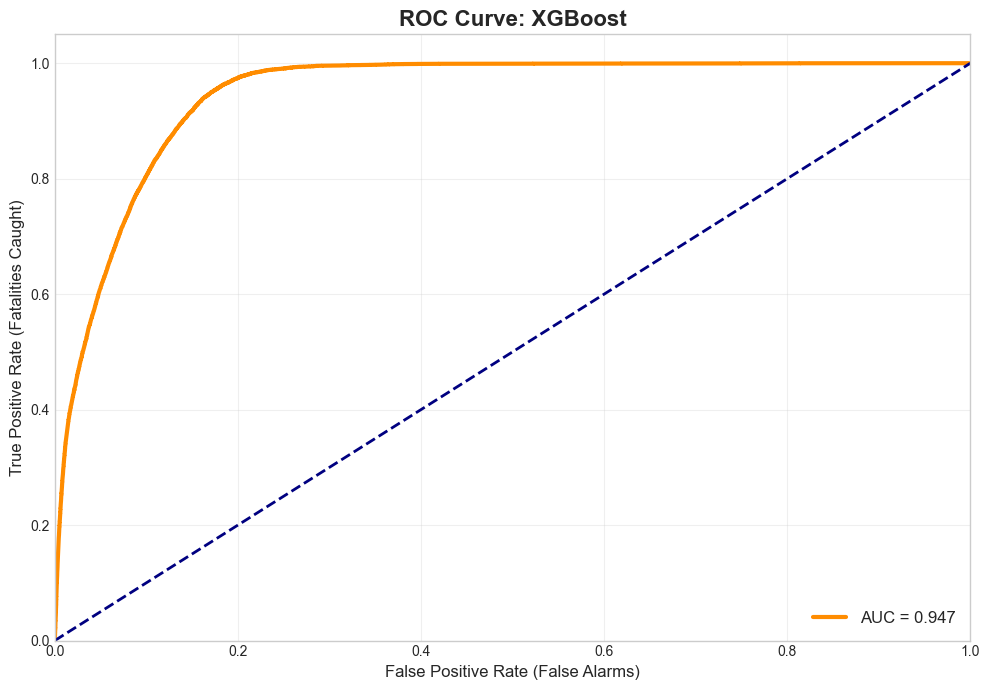

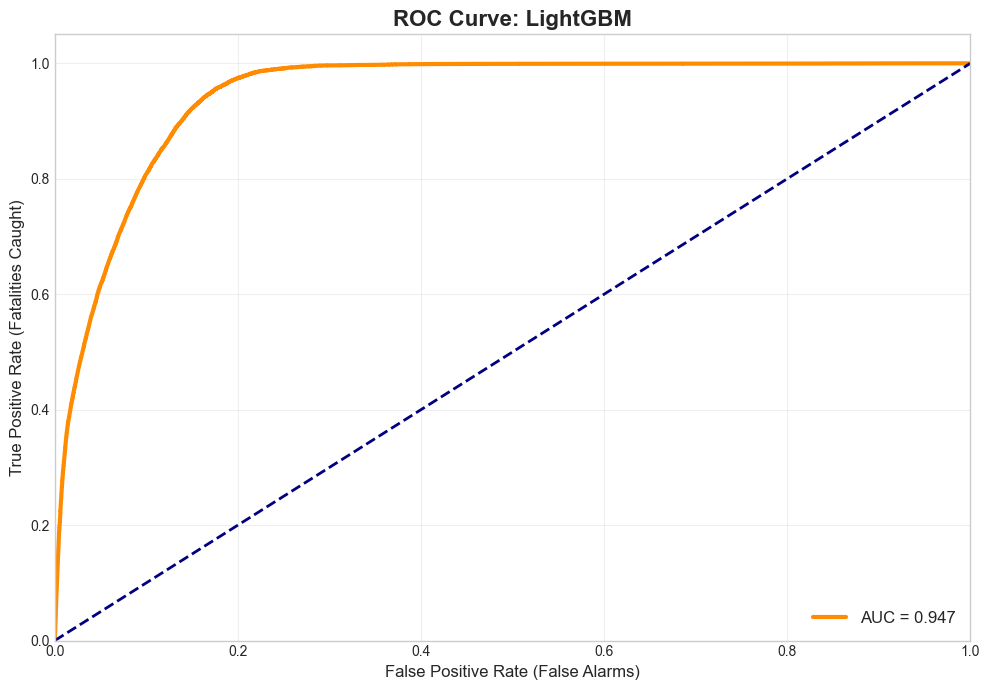


SECTION C: CLASSIFICATION REPORTS

--- Logistic Regression ---
              precision    recall  f1-score   support

   Minor (0)       1.00      0.64      0.78    224666
   Fatal (1)       0.18      0.99      0.30     17392

    accuracy                           0.67    242058
   macro avg       0.59      0.82      0.54    242058
weighted avg       0.94      0.67      0.75    242058


--- Random Forest ---
              precision    recall  f1-score   support

   Minor (0)       0.99      0.83      0.90    224666
   Fatal (1)       0.30      0.94      0.45     17392

    accuracy                           0.84    242058
   macro avg       0.65      0.89      0.68    242058
weighted avg       0.94      0.84      0.87    242058


--- XGBoost ---
              precision    recall  f1-score   support

   Minor (0)       1.00      0.82      0.90    224666
   Fatal (1)       0.30      0.95      0.45     17392

    accuracy                           0.83    242058
   macro avg       0.65 

Output()

Training Tuned LightGBM...


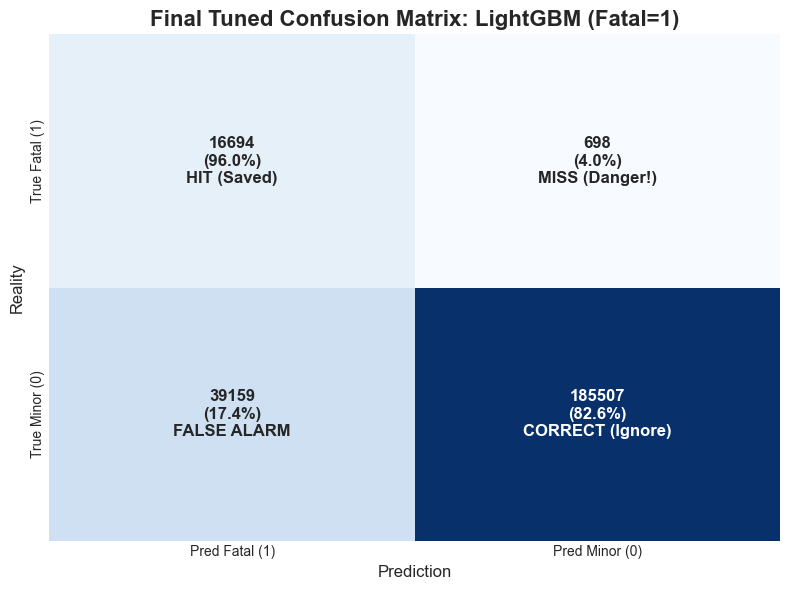

Model saved successfully!
--- Executing FinalModelEvaluation ---
Evaluation function ready (Fatal=1).
--- FINAL MODEL LEADERBOARD (Sorted by Safety/Recall) ---


Accuracy Recall (Safety) Precision (Trust) F1 Score  \
Model                                                                  
LightGBM (Tuned)    83.5%           96.0%             29.9%    0.456   

                 Training Time  
Model                           
LightGBM (Tuned)          4.0s

--- GENERATING PRECISION-RECALL CURVE (The Imbalance Truth) ---


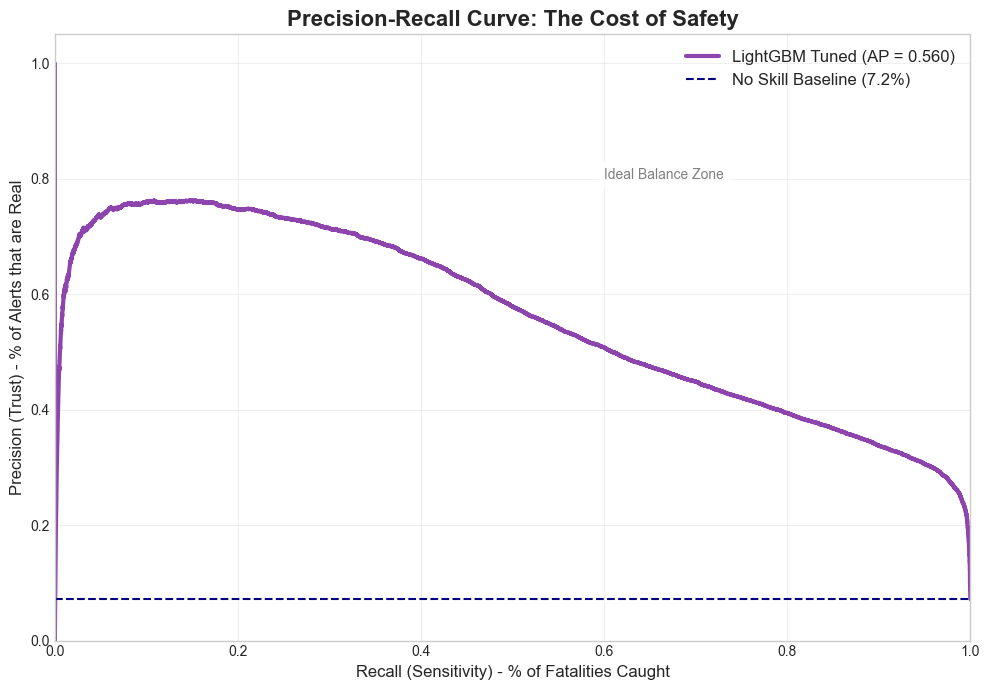

--- Executing FeatureImportance ---


C:\Users\nwagb\AppData\Local\Temp\ipykernel_36020\2930621446.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Value", y="Feature", data=top_10_features, palette="mako")


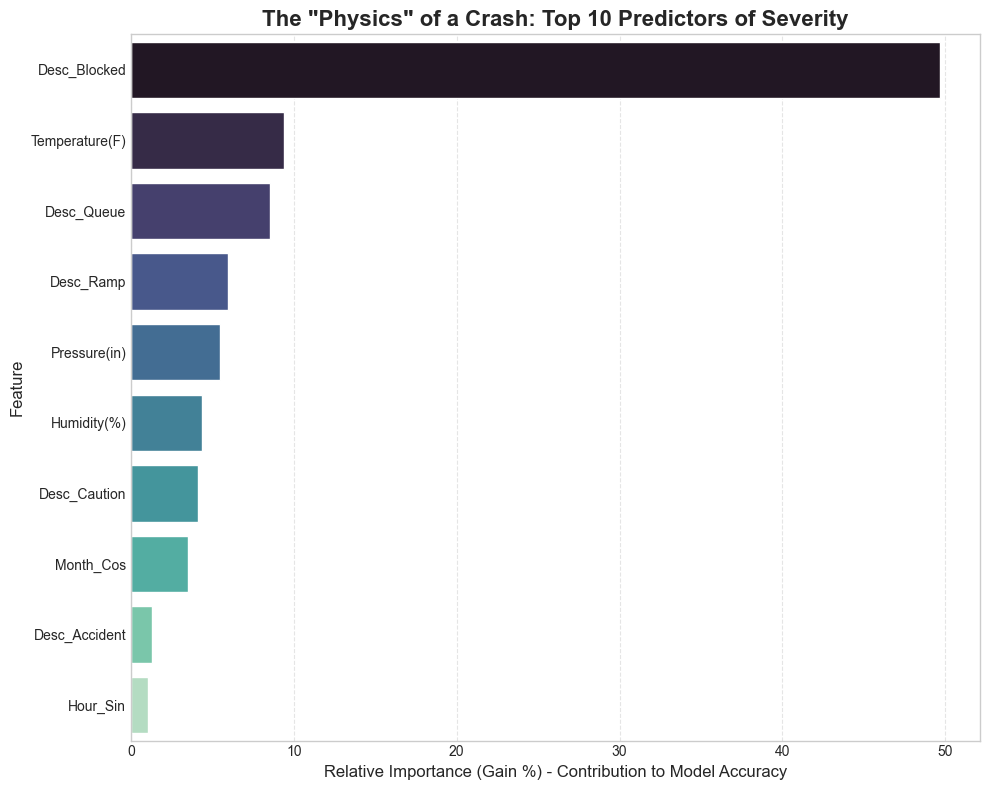

--- INTERPRETATION OF TOP DRIVERS ---
Feature: Desc_Blocked (49.6%)
 -> CONTEXTUAL FACTOR: A nuanced modifier of accident physics.
----------------------------------------
Feature: Temperature(F) (9.4%)
 -> CONTEXTUAL FACTOR: A nuanced modifier of accident physics.
----------------------------------------
Feature: Desc_Queue (8.6%)
 -> CONTEXTUAL FACTOR: A nuanced modifier of accident physics.
----------------------------------------
Feature: Desc_Ramp (6.0%)
 -> CONTEXTUAL FACTOR: A nuanced modifier of accident physics.
----------------------------------------
Feature: Pressure(in) (5.5%)
 -> STORM FRONTS: Barometric pressure is the best proxy for incoming severe weather systems.
----------------------------------------
Feature: Humidity(%) (4.3%)
 -> CONTEXTUAL FACTOR: A nuanced modifier of accident physics.
----------------------------------------
Feature: Desc_Caution (4.1%)
 -> CONTEXTUAL FACTOR: A nuanced modifier of accident physics.
----------------------------------------
Feat

c:\Users\nwagb\Desktop\MACHINE_LEARNING_ASSESSEMENT\H1B_Visa_applications\.us_accident_model\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


 -> Detected Binary Output: Explaining Class 1 (Fatal)


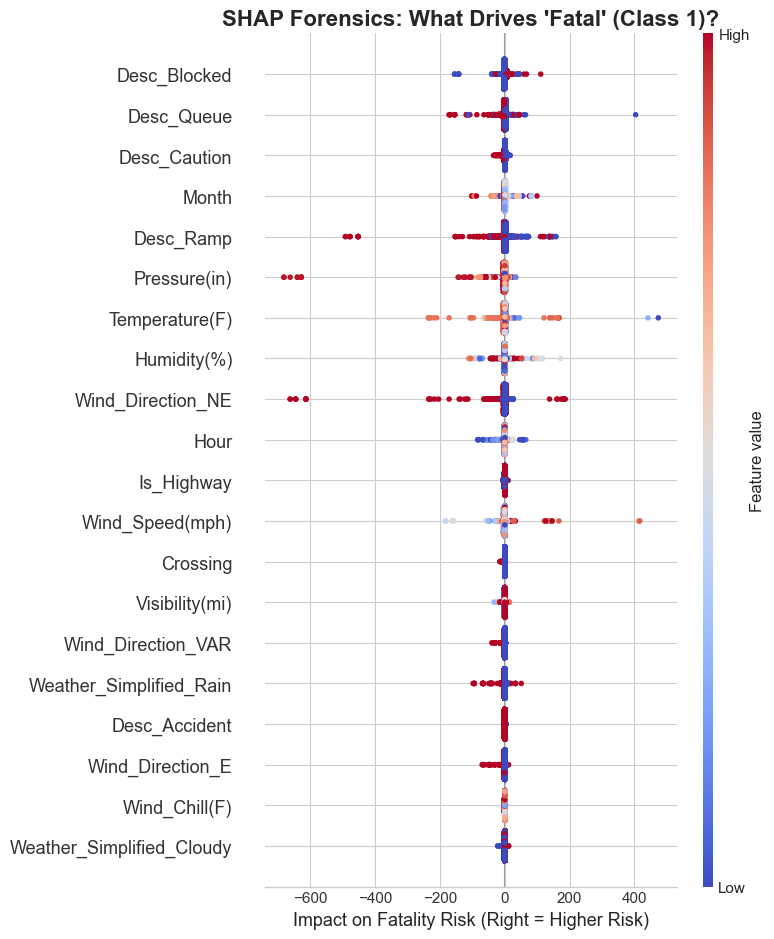

--- INDIVIDUAL FORENSICS: ANATOMY OF A FATAL CRASH ---
Analyzing Test Set Index #28403
Model Prediction: 100.00% Probability of Fatality


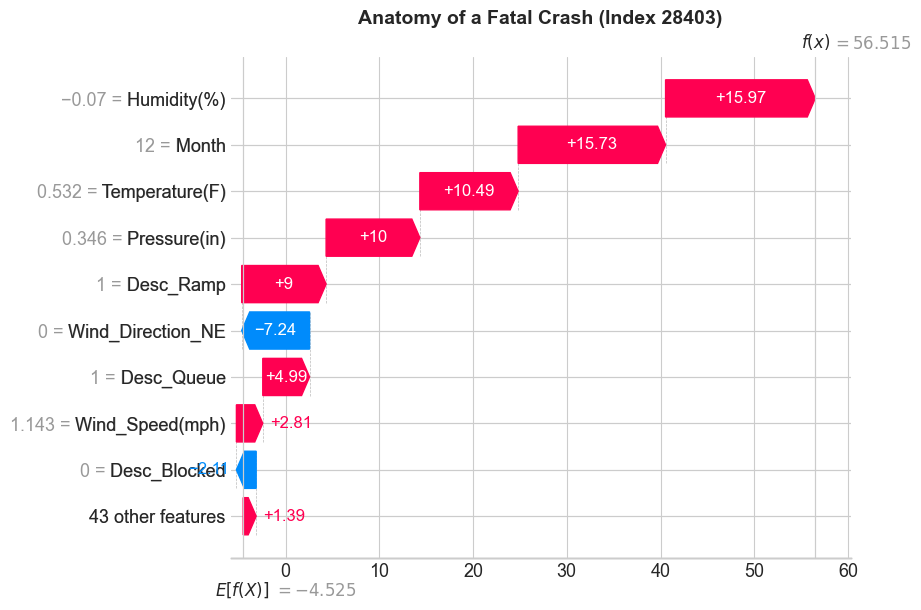

--- DEPENDENCE PLOT: THE TRUE HOURLY RISK CURVE ---


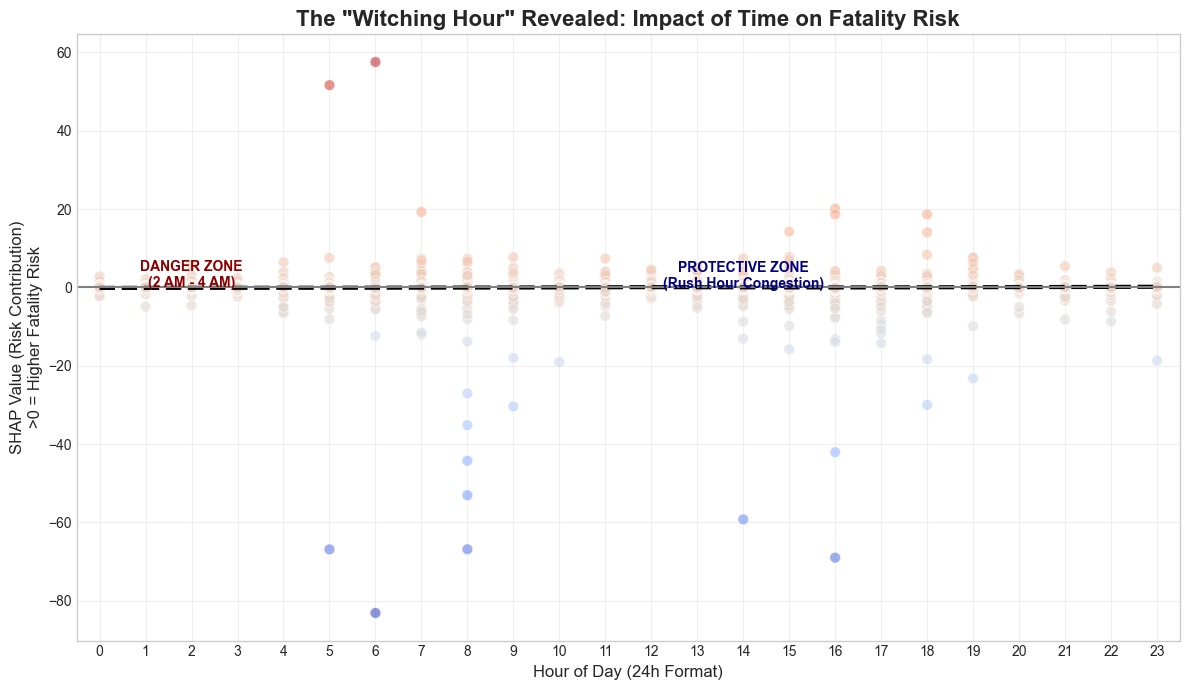

In [18]:
def main():
    state = {}
    instance = DataExtraction()
    state = instance.execute(state)
    instance = FinalDataExtraction()
    state = instance.execute(state)
    instance = DataCleaning()
    state = instance.execute(state)
    instance = UnivariateAnalysis()
    state = instance.execute(state)
    instance = BivariateAnalysis()
    state = instance.execute(state)
    instance = FeatureEngineering()
    state = instance.execute(state)
    instance = UnsupervisedLearning()
    state = instance.execute(state)
    instance = DataPreprocessing()
    state = instance.execute(state)
    instance = ModelTraining()
    state = instance.execute(state)
    instance = ModelEvaluation()
    state = instance.execute(state)
    instance = HyperParameterTuning()
    state = instance.execute(state)
    instance = FinalModelEvaluation()
    state = instance.execute(state)
    instance = FeatureImportance()
    state = instance.execute(state)
    instance = ShapAnalysis()
    state = instance.execute(state)

if __name__ == '__main__':
    main()
